# Financial Derivatives & Risk Management Group Task
## Cryptocurrencies Option Pricing

## Francisco Perestrello 20241560 | Gonçalo Gomes 20211007 | Nuno Vieira 20241111

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import tensorflow as tf
import plotly.graph_objects as go
import requests
import re
import time
import subprocess
import sys

from datetime import datetime, timedelta
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from IPython.display import Image

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols
from scipy.optimize import minimize
#from google.colab import drive
#drive.mount('/content/drive')
#!pip install nelson-siegel-svensson
#!pip install xlrd

np.random.seed(42)  # Set seed for reproducibility

### 1. Pick a crypto currency (Bitcoin BTC, Ethereum ETH, Binance BNB, Solana SOL, or Ripple XRP) you will analyse.

--> For this Group Project, we will pick SOLANA (SOL) for the following reasons:

1. High Volatility;
2. Liquid Options Market: It has a wide range of maturities with multiple strikes. It has also enough volume to make representative analysis;
3. Relevance of the project: It is one of the top Layer 1 blockchain ecossystems;
4. Recent Price Cycle: Solana has experienced recent booms and downs which make it ideal for comparing historical with implied volatility, for example;

In [ ]:
# Checking if Solana is supported in Deribit

def get_currencies():
    url = "https://www.deribit.com/api/v2/public/get_currencies"
    response = requests.get(url)
    return response.json()

# Supported currencies

supported_currencies = []

for i in range(len(get_currencies()["result"])):
  supported_currencies.append(get_currencies()["result"][i]["currency"])

print(supported_currencies)

['XRP', 'USYC', 'USDT', 'USDE', 'USDC', 'STETH', 'SOL', 'PAXG', 'MATIC', 'EURR', 'ETHW', 'ETH', 'BUIDL', 'BTC', 'BNB']


#### a) Download the options and historical prices to csv that you will use so that all analysis can be recreated.

In [ ]:
# Defining the file paths for the data extracted for all maturities available regarding SOL-USDC Pair

file_paths = {
    "30MAY25": "/content/drive/MyDrive/Nova Ims/Financial Derivatives/Group Project/SOL-USDC Options/SOL_USDC-30MAY25-export.csv",
    "25APR25": "/content/drive/MyDrive/Nova Ims/Financial Derivatives/Group Project/SOL-USDC Options/SOL_USDC-25APR25-export.csv",
    "18APR25": "/content/drive/MyDrive/Nova Ims/Financial Derivatives/Group Project/SOL-USDC Options/SOL_USDC-18APR25-export.csv",
    "11APR25": "/content/drive/MyDrive/Nova Ims/Financial Derivatives/Group Project/SOL-USDC Options/SOL_USDC-11APR25-export.csv",
    "6APR25": "/content/drive/MyDrive/Nova Ims/Financial Derivatives/Group Project/SOL-USDC Options/SOL_USDC-6APR25-export.csv",
    "5APR25": "/content/drive/MyDrive/Nova Ims/Financial Derivatives/Group Project/SOL-USDC Options/SOL_USDC-5APR25-export.csv"
}

# Underlying Solana price (04/04/2025) for all the selected maturities was the same in Deribit --> 115$. That's why we used a fixed variable

underlying_price = 115

# Function to extract strike price from "Instrument" column

def extract_strike(instrument):

    match = re.search(r'-(\d+(?:\.\d+)?)-', instrument)

    return float(match.group(1)) if match else None

# We process and filter each extracted file to extract strike price from "Instrument" column --> We only want the closest strike to current price

atm_options = {}

for label, path in file_paths.items():

    df = pd.read_csv(path)

    df['Strike'] = df['Instrument'].apply(extract_strike)

    df['Type'] = df['Instrument'].apply(lambda x: 'call' if x.endswith('C') else 'put')

    # Finding the closest strike to the underlying asset price

    df['Distance'] = abs(df['Strike'] - underlying_price)

    closest_strike = df.loc[df['Distance'].idxmin(), 'Strike']

    # Filtering to that strike for both call and put options

    atm_df = df[df['Strike'] == closest_strike].copy()

    atm_options[label] = atm_df[['Instrument', 'Volume', 'Open', 'ExtValue', 'Rho', 'Theta', 'Vega', 'Gamma', 'Δ|Delta', 'Last', 'Size', 'Type', 'Strike', 'Bid', 'Ask', 'Mark', 'IV Bid', 'IV Ask']]


# We achieve a dictionary that has, for each maturity, the call and put options that have the closest strike price to the actual price

atm_options

In [ ]:
# Combining the dictionary created earlier into a table format

df_options = pd.concat(
    [df.assign(Maturity=maturity) for maturity, df in atm_options.items()],
    ignore_index=True
)

df_options

In [ ]:
# Downloading historical prices

sol_data = yf.download("SOL-USD", start = "2024-04-04", end = "2025-04-04")

# Flatenning the multiindex that comes by default

sol_data.columns = sol_data.columns.get_level_values(0)

sol_data = sol_data.reset_index()
sol_data.columns.name = None

sol_data.head()

In [ ]:
# Saving both the Options and Historical data

# df_options.to_csv("/content/drive/MyDrive/Nova Ims/Financial Derivatives/Group Project/df_options.csv", index = False)
# sol_data.to_csv("/content/drive/MyDrive/Nova Ims/Financial Derivatives/Group Project/sol_data.csv", index = False)

In [ ]:
# Checkpoint for reading the saved data

df_options = pd.read_csv("C:/Users/20241560/Desktop/Financial Derivatives/FD_Gonçalo/FD_Gonçalo/df_options.csv")
sol_data = pd.read_csv("C:/Users/20241560/Desktop/Financial Derivatives/FD_Gonçalo/FD_Gonçalo/sol_data.csv")

In [ ]:
df_options

Instrument  Volume   Open  ExtValue      Rho    Theta  \
0   SOL_USDC-30MAY25-110-C     830    990       NaN  0.08227 -0.13768   
1   SOL_USDC-30MAY25-110-P     400    370       NaN -0.08592 -0.13768   
2   SOL_USDC-25APR25-110-C     560   1160       NaN  0.03419 -0.23859   
3   SOL_USDC-25APR25-110-P    1940  14140       NaN -0.02852 -0.23859   
4   SOL_USDC-18APR25-116-C     490   1330       NaN  0.02016 -0.31773   
5   SOL_USDC-18APR25-116-P      10     10       NaN -0.02373 -0.31773   
6   SOL_USDC-11APR25-116-C    7740  11040       NaN  0.01010 -0.49741   
7   SOL_USDC-11APR25-116-P    5240  12380       NaN -0.01154 -0.49741   
8    SOL_USDC-6APR25-114-C      30     30       NaN  0.00324 -0.89533   
9    SOL_USDC-6APR25-114-P     320    320       NaN -0.00241 -0.89533   
10   SOL_USDC-5APR25-114-C    1160    880       NaN  0.00151 -1.26647   
11   SOL_USDC-5APR25-114-P     600   1240       NaN -0.00102 -1.26647   

       Vega    Gamma  Δ|Delta  Last  Size  Type  Strike   Bid   Ask     Mark  \
0   0.17153  0.00933  0.62670  18.6   250  call   110.0  17.6  19.4  18.7871   
1   0.17153  0.00933 -0.37330  12.0   130   put   110.0  12.3  13.6  12.9524   
2   0.10411  0.01427  0.63355  12.2   250  call   110.0  12.5  13.8  13.4007   
3   0.10411  0.01427 -0.36645   8.0   250   put   110.0   7.3   7.9   7.5897   
4   0.08955  0.01800  0.53521   7.9   240  call   116.0   8.4   8.9   8.7194   
5   0.08955  0.01800 -0.46479   9.5   240   put   116.0   8.6   9.2   8.8847   
6   0.06299  0.02340  0.52541   6.2   220  call   116.0   6.4   6.9   6.6922   
7   0.06299  0.02340 -0.47459   7.0   220   put   116.0   6.6   7.2   6.8812   
8   0.03149  0.04598  0.60123   3.8   250  call   114.0   4.1   4.5   4.3051   
9   0.03149  0.04598 -0.39877   2.8   540   put   114.0   2.3   2.6   2.4941   
10  0.02078  0.05731  0.61916   3.1   250  call   114.0   3.4   3.9   3.6605   
11  0.02078  0.05731 -0.38084   2.3   520   put   114.0   1.6   2.0   1.8085   

    IV Bid  IV Ask Maturity  
0    82.61   93.10  30MAY25  
1    85.83   93.40  30MAY25  
2    86.49   99.00  25APR25  
3    92.72   98.48  25APR25  
4    94.36   99.95  18APR25  
5    94.88  101.58  18APR25  
6   102.71  110.65  11APR25  
7   104.85  112.79  11APR25  
8    95.94  108.65   6APR25  
9    97.05  106.58   6APR25  
10  110.52  129.79   5APR25  
11  111.05  130.32   5APR25

#### b) Estimate volatility using different historical time series of varying lengths.


* We are now calculating the annualized standard deviation of Solana's daily log returns (volatility), which tells us how much Solana's price tends to fluctuate over time.

--> Since we are dealing with high volatile assets, we are analyzing volatility based on log returns, which scale better when prices move significantly, like in this case.

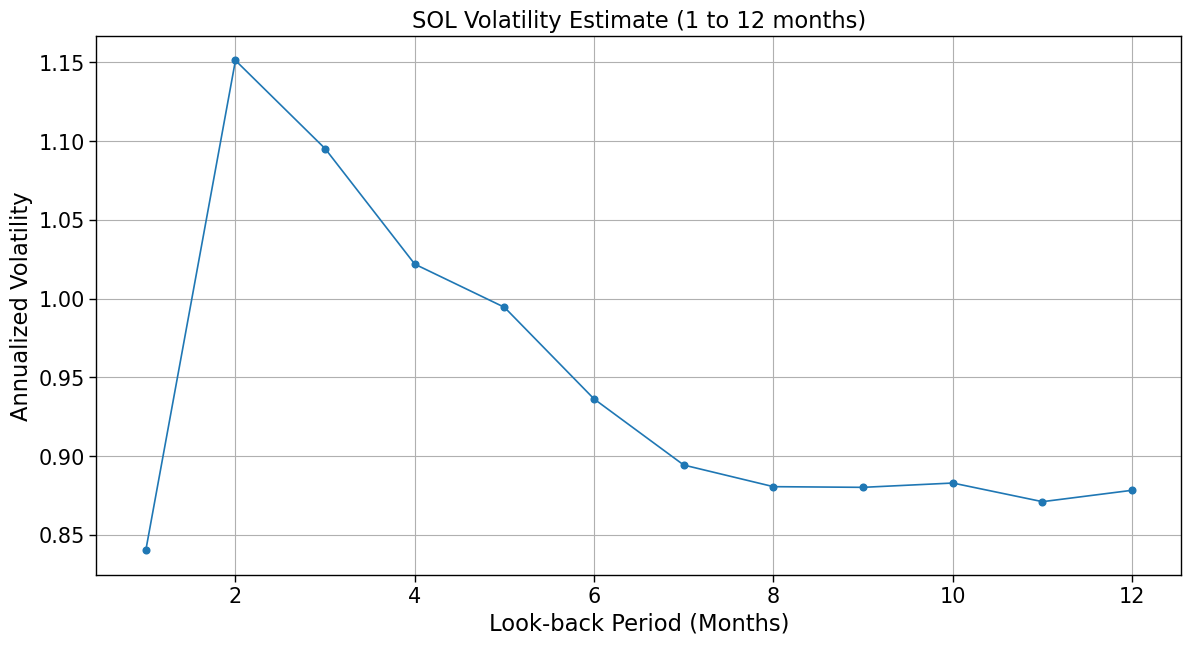

In [ ]:
# Look-Back Volatility Estimate (1 to 12 motnhs)

# Using the close price for returns

S = sol_data['Close'].dropna()

# Calculating the daily log returns

ln_r = np.log(S / S.shift(1)).dropna()

# Calculating volatility for previous 1 to 12 months and converting months to days

look_back_volatility = {}

for months in range(1, 12 + 1):

    # Approximate number of trading days in "months"

    days = months * 30

    if len(ln_r) >= days:

        # Calculating the standard deviation of log returns for the look-back period and Annualizing the volatility

        # Since there are 365 trading days per year in crypto, the scaling factor should be around that number. We will use 360 because we have 365 days of data and we will keep the rolling window logic.

        vol = ln_r.iloc[-days:].std() * np.sqrt(360)

        look_back_volatility[months] = vol

# Creating a DataFrame from the look-back volatility dictionary

volatility_df = pd.DataFrame(list(look_back_volatility.items()), columns=['Months', 'Volatility'])

# Look Back period volatility

plt.figure(figsize=(14, 7))
plt.plot(volatility_df['Months'], volatility_df['Volatility'], marker='o')
plt.title('SOL Volatility Estimate (1 to 12 months)')
plt.xlabel('Look-back Period (Months)')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.show()

Important note: Since cryptocurrencies trade continuously throughout the year, we assume 360 trading days when annualizing historical volatility. This rounded value aligns with the 24/7 nature of the crypto market while also allowing for complete rolling volatility calculations on our 365-day dataset.

--> This chart displays the annualized historical volatility of Solana across several look-back periods ranging between 1 to 12 months and calculated using the log returns.

* From the analysis, we can see that the look-back volatility curve for Solana shows a big short-term spike, with volatility peaking over 115% around the 2-month mark, followed by a steady decline and stabilization near 88%.
This is a typical behaviour in cryptocurrencies which often experience short bursts of intense volatility followed be longer periods of stabilization.


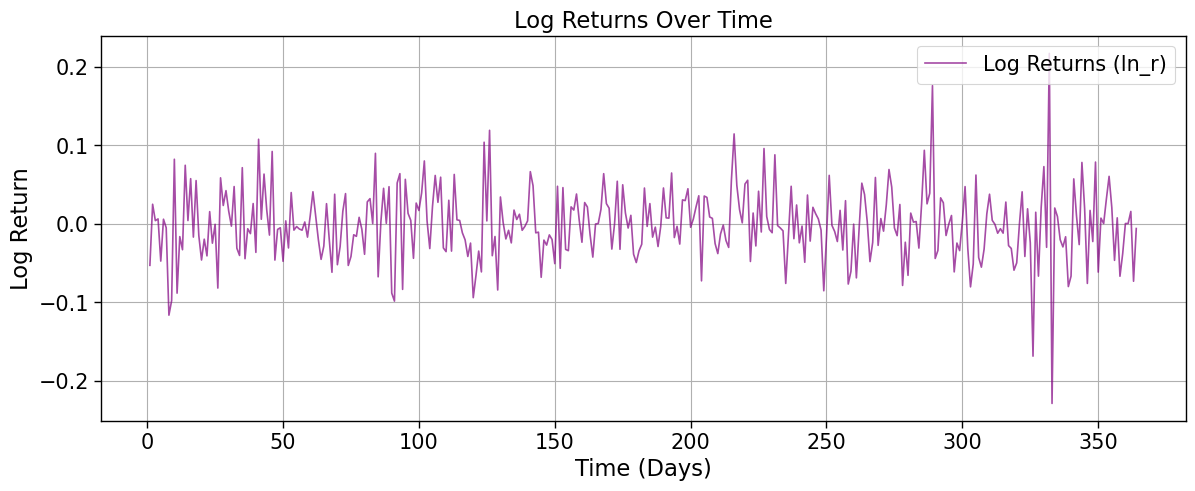

In [ ]:
rolling_volatility = {}

for months in [1, 3, 6, 12]:

    days = months * 30

    # Rolling standard deviation of log annualized log returns

    rolling_volatility[months] = ln_r.rolling(window=days).std() * np.sqrt(360)

# Creating a DataFrame from the rolling volatility dictionary

volatility_df = pd.DataFrame(rolling_volatility, index=ln_r.index)

# Plotting the Log Returns

plt.figure(figsize=(14, 5))

plt.plot(ln_r, label='Log Returns (ln_r)', color='purple', alpha=0.7)
plt.title('Log Returns Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Log Return')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

* This time-series of log-returns displays the typical behaviour for cryptocurrencies like Solana.
We can clearly see volatility clusters, in which periods of high volatility are followed by similar behaviour.
Additionally, the plot shows large and sudden jumps both upward and downward, consistent with the speculative nature of crypto.

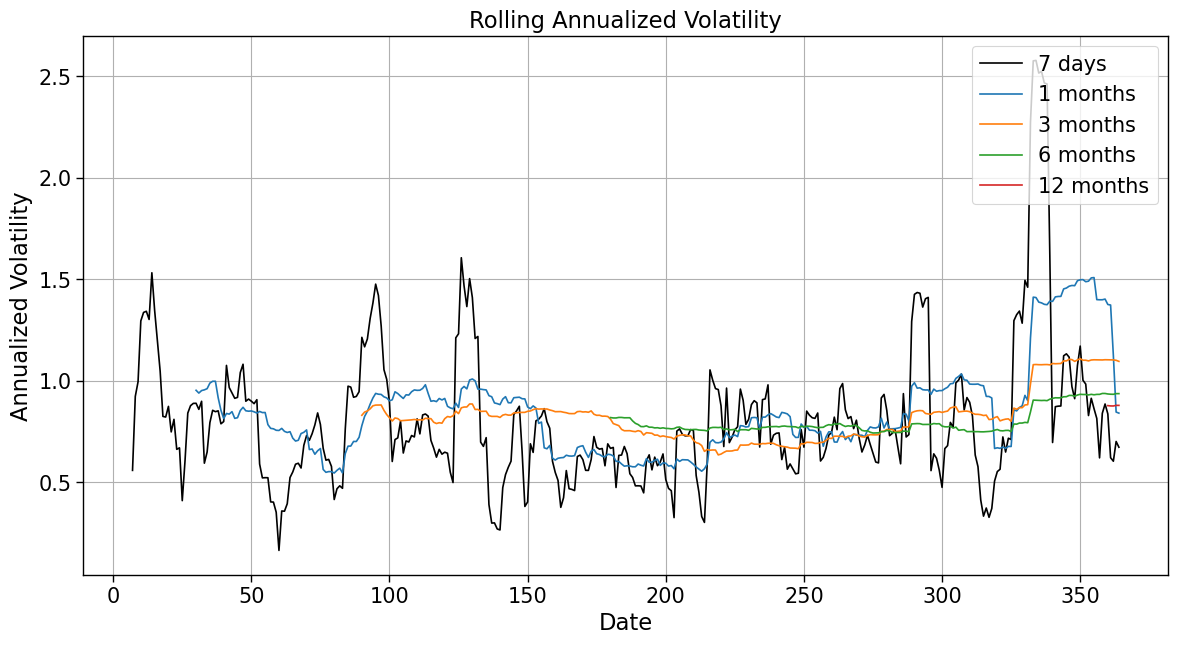

In [ ]:
# Adding the 7-day rolling window to existing volatility dictionary

volatility_df['7d'] = ln_r.rolling(window=7).std() * np.sqrt(360)

# Plotting the rolling volatility, including the 7-day window

plt.figure(figsize=(14, 7))
plt.plot(volatility_df['7d'], label='7 days', color='black')

for months in [1, 3, 6, 12]:

    plt.plot(volatility_df[months], label=f'{months} months')

plt.title('Rolling Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

* This rolling volatility plot reveals strong time-varying behaviour regarding historical volatility considering different horizons. The short-term 7-day volatility is extremely reactive and noisy, spiking above 250% during volatile events.
Also, both the 1-month and 3-month volatility windows are smoother but still responsive to trends and shocks.
Longer-term measures like 6 and 12-month volatilities remain much smoother and stable.

In [ ]:
# Converting the Date column to DateTime (it was an object type previously)

sol_data["Date"] = pd.to_datetime(sol_data["Date"])
sol_data.sort_values("Date", inplace = True)

# Calgulating log returns for the closing price

sol_data["LogReturn"] = np.log(sol_data["Close"] / sol_data["Close"].shift(1))
sol_data.dropna(inplace = True)

# Estimating volatility for different time windows

windows = [7, 30, 90, 180, 360]

vol_estimates = {}

for window in windows:

    rolling_std = sol_data['LogReturn'].rolling(window=window).std()

    annualized_vol = rolling_std * np.sqrt(360)

    # We want to retrieve the most recent estimate

    vol_estimates[f"{window}_day_vol"] = annualized_vol.iloc[-1]

# Formating the result as a DataFrame

vol_df = pd.DataFrame(list(vol_estimates.items()), columns=['Window', 'Annualized Volatility'])
vol_df

Window  Annualized Volatility
0    7_day_vol               0.672228
1   30_day_vol               0.840197
2   90_day_vol               1.095275
3  180_day_vol               0.936313
4  360_day_vol               0.878376

* In this section, we rely on the most recent value from each historical volatility estimate. This choice is deliberate, as we aim to compare historical volatility with implied volatility, which represents the market's expectations of future risk as of today. In essence, we are answering the question: “Based on the most recent X days of returns, what would be the annualized historical volatility if we measured it today?”

* Additionally, by using multiple look-back periods, specifically 7, 30, 90, 180, and 360 days, as we are mimicking the maturities of the option contracts in our dataset. This allows for a meaningful and time-aligned comparison between recent historical volatility and the implied volatility observed across different option maturities.

Important Note: We intentionally exclude extremely short look-back periods, such as 1 or 2-day windows even if they match ultra-short-dated options (like daily maturities). The reason is that such short historical volatility estimates tend to be highly noisy, and do not provide reliable measures for comparison.

#### c) Calculate the implied volatility for different option lengths and compare to the historical volatility. What does this tell you?


In [ ]:
df_options.head()

Instrument  Volume   Open  ExtValue      Rho    Theta     Vega  \
0  SOL_USDC-30MAY25-110-C     830    990       NaN  0.08227 -0.13768  0.17153   
1  SOL_USDC-30MAY25-110-P     400    370       NaN -0.08592 -0.13768  0.17153   
2  SOL_USDC-25APR25-110-C     560   1160       NaN  0.03419 -0.23859  0.10411   
3  SOL_USDC-25APR25-110-P    1940  14140       NaN -0.02852 -0.23859  0.10411   
4  SOL_USDC-18APR25-116-C     490   1330       NaN  0.02016 -0.31773  0.08955   

     Gamma  Δ|Delta  Last  Size  Type  Strike   Bid   Ask     Mark  IV Bid  \
0  0.00933  0.62670  18.6   250  call   110.0  17.6  19.4  18.7871   82.61   
1  0.00933 -0.37330  12.0   130   put   110.0  12.3  13.6  12.9524   85.83   
2  0.01427  0.63355  12.2   250  call   110.0  12.5  13.8  13.4007   86.49   
3  0.01427 -0.36645   8.0   250   put   110.0   7.3   7.9   7.5897   92.72   
4  0.01800  0.53521   7.9   240  call   116.0   8.4   8.9   8.7194   94.36   

   IV Ask Maturity  
0   93.10  30MAY25  
1   93.40  30MAY25  
2   99.00  25APR25  
3   98.48  25APR25  
4   99.95  18APR25

In [ ]:
# Converting the Implied Volatility to numeric and scaling it

df_options["IV Bid"] = pd.to_numeric(df_options["IV Bid"], errors='coerce') / 100
df_options["IV Ask"] = pd.to_numeric(df_options["IV Ask"], errors='coerce') / 100

# Computing the Mid Implied Volatility as the average regarding Bid and Ask

df_options["IV Mid"] = (df_options["IV Bid"] + df_options["IV Ask"]) / 2

# grouping by maturity and computing the average implied volatility

iv_summary = df_options.groupby("Maturity")["IV Mid"].mean().reset_index()
iv_summary.columns = ["Maturity", "Avg_Implied_Volatility"]

iv_summary["Maturity"] = pd.to_datetime(iv_summary["Maturity"])
iv_summary.sort_values("Maturity", inplace=True)
iv_summary

C:\Users\20241560\AppData\Local\Temp\ipykernel_9508\3389960753.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  iv_summary["Maturity"] = pd.to_datetime(iv_summary["Maturity"])


Maturity  Avg_Implied_Volatility
4 2025-04-05                1.204200
5 2025-04-06                1.020550
0 2025-04-11                1.077500
1 2025-04-18                0.976925
2 2025-04-25                0.941725
3 2025-05-30                0.887350

Comparing both implied and historical volatilities can provide insights into the market sentiment and option price dynamics!

As we know, the implied volatility is basically the market's expectation of future price volatility, which is embedded in the price of an option.
It is important in the sense that it reflects the market's sentiment and expectations regarding future risk!

* In this analysis, we are comparing implied volatility from Solana options with recent historical volatilities over different look-back periods. To ensure consistency, each historical volatility estimate is being compared with the corresponding time to maturity of the options data.
For instance, as of April 4th 2025, the 7-day historical volatility is aproximately 67.2%. This value reflects the volatility over the past week and is best compared with the implied volatility of the option expiring on April 11th 2025, showing an upward adjustment by the market in antecipation of future uncertainty. This discrepancy shows that market participants expect higher volatility in the immediate futurethat what was observed recently.
This is seen across longer maturities. For example:
  * The 30-day recent historical volatility of 84% is best compared with monthly options. In our dataset, this corresponds well to the maturities on April 25th 2025 and May 30th 2025, which show volatilies of 94.17% and 88.74%, respectively. This shows a consistent pattern in which implied volatility exceeds historical volatility, highlighting the presence of risk premium.
  
  * Another important point is that the trend structure of implied volatility is downward-slopping, meaning that implied volatility decreases with longer maturities, which tells us that volatility tends to mean-revert and stabilize over time.

Overall, the implied volatility consistently exceeds historical volatility across all maturities, reflecting a classic volatility premium due to speculation.



#### d) Explore the market implied volatility (volatility surfaces) what do you find? What does it tell you about crypto currency?


In [ ]:
# Converting maturity to datetime

today = datetime(2025, 4, 4)
df_options["Maturity Date"] = pd.to_datetime(df_options["Maturity"], format="%d%b%y", errors='coerce')

# Calculating time to maturity in days

df_options["TTM"] = (df_options["Maturity Date"] - today).dt.days

# Displaying the data

df_options[["Strike", "TTM", "IV Mid"]].head()

Strike  TTM   IV Mid
0   110.0   56  0.87855
1   110.0   56  0.89615
2   110.0   21  0.92745
3   110.0   21  0.95600
4   116.0   14  0.97155

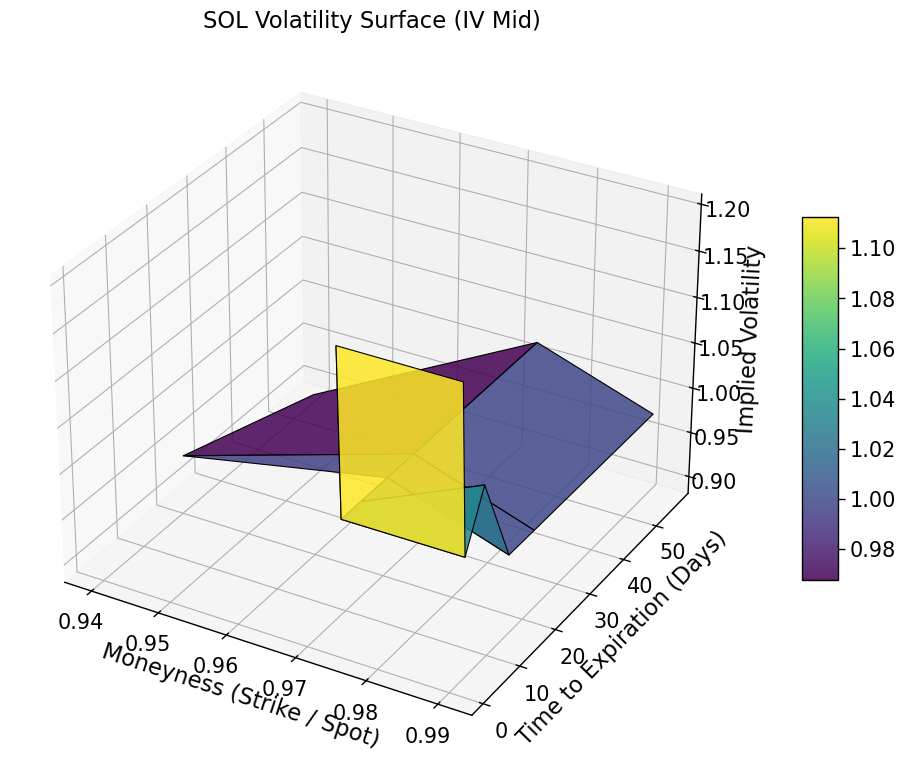

In [ ]:
# Defining the "today's" spot price

spot_price = sol_data.iloc[-1]['Close']

# Computing the moneyness

df_options["moneyness"] = df_options["Strike"] / spot_price

# Calculating the time to maturity from 2025-04-04

today = datetime(2025, 4, 4)
df_options["Maturity Date"] = pd.to_datetime(df_options["Maturity"], format="%d%b%y", errors='coerce')
df_options["expiration"] = (df_options["Maturity Date"] - today).dt.days

# Function to allow discrimination between option types. Everything else stays the same

def plot_vol_surface_by_type(option_type = None, moneyness_range=(0.7, 1.3)):

    df = df_options.copy()

    # Filtering based on selected option type
    if option_type is not None:
      df = df[df["Type"].str.lower() == option_type.lower()]

    # Cleaning and filtering the dataframe

    filtered = df[
        df["IV Mid"].notnull() &
        df["expiration"].notnull() &
        (df["expiration"] > 0) &
        (df["moneyness"] >= moneyness_range[0]) &
        (df["moneyness"] <= moneyness_range[1])
    ]

    # Pivot the data into a grid

    surface_df = filtered[["moneyness", "expiration", "IV Mid"]]
    grid = surface_df.pivot_table(index="expiration", columns="moneyness", values="IV Mid")
    grid = grid.sort_index()
    grid = grid.interpolate(axis=0).interpolate(axis=1)

    # Creating the meshgrid and the plot

    X, Y = np.meshgrid(grid.columns, grid.index)
    Z = grid.values

    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, edgecolor='k', alpha=0.85)

    if option_type is not None:
      ax.set_title(f"SOL {option_type.capitalize()} Volatility Surface (IV Mid)")
    else:
      ax.set_title(f"SOL Volatility Surface (IV Mid)")
    ax.set_xlabel("Moneyness (Strike / Spot)")
    ax.set_ylabel("Time to Expiration (Days)")
    ax.set_zlabel("Implied Volatility")
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

# Plotting the volatility surface for all options

plot_vol_surface_by_type()

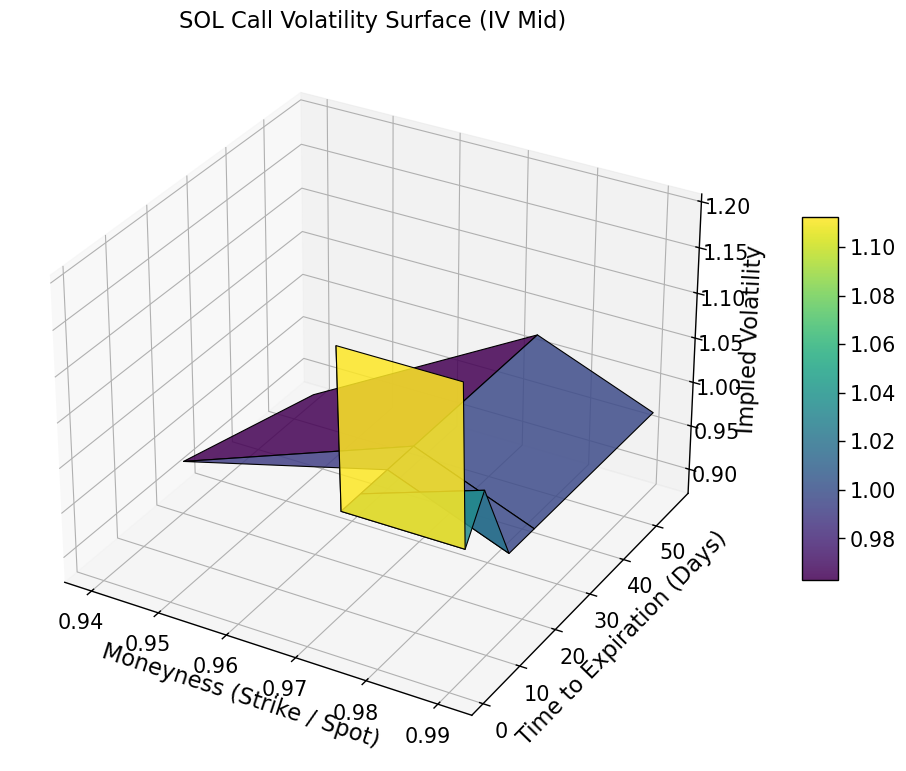

In [ ]:
# Plotting the volatility surface for call options

plot_vol_surface_by_type("call")

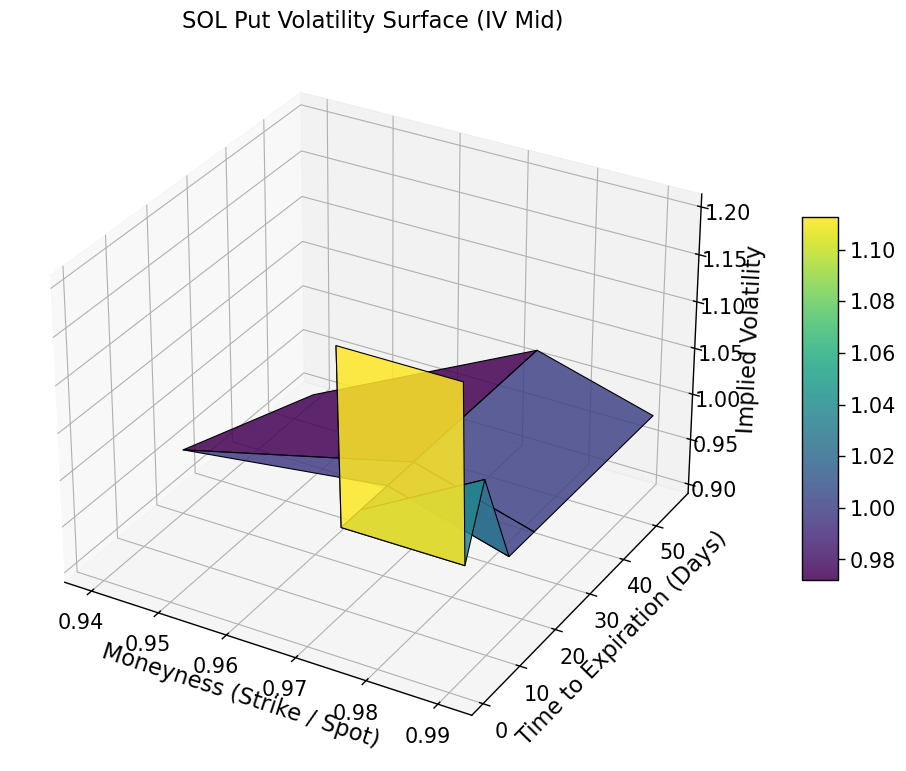

In [ ]:
# Plotting the volatility surface for put options

plot_vol_surface_by_type("put")

--> The implied volatility surfaces developed, include the combined plot and separated surfaces for both calls and puts. We thought that it was important to follow this approach in order to identify some possible pricing asymemetries, skew patterns or even sentiment biases, because in volatilie and speculative markets like crypto, these subtle signals can be highly informative!

With this being said, and considering the analysis of the plots themselves, there are several interesting factors:

* First of all, it's important to note that we are performing this analysis on a very small number of strikes and limited maturity dates.
Since the surface requires interpolation between the points, this causes uneven patches and sharp gradients in the plot.

* Across all surfaces, we observe a slight downward slope along the Time to Expiration axis, meaning that short-term options tend to have higher implied volatilites and that the opposite occurs for longer-dated options.
It suggests that the market expects volatility to decrease over time.

* Along the moneyness axis, implied volatility is relatively flat, showing a slight increase as we move towards the ATM region (between 0.99 and 1). This implies that the market gives higher uncertainty to ATM strikes, while pricing in lower implied volatility for nearby ITM and OTM options. This phenomenon is probably due to demand for protection, specially because Solana is extremely volatile. The flatness however, is likely due to the fact that we have a small number of maturities in our data.

* While separate surfaces were built for calls and puts, the structure remain nearly the same for both of them, which probably means that market participants are princing volatility symmetrically around the ATM level.

#### e) How would you use the available options to achieve the following, calculate exactly what you would buy and plot the expected payoff of the entire portfolio:


##### i.) Insure against downside risk on an existing portfolio of the underlying with a value of €10 million but retain upside exposure.


Note: The contract multiplier for Solana in Deribit is set to 10 units per contract.

Source: https://insights.deribit.com/education/new-altcoin-options-on-deribit-sol-xrp-matic/

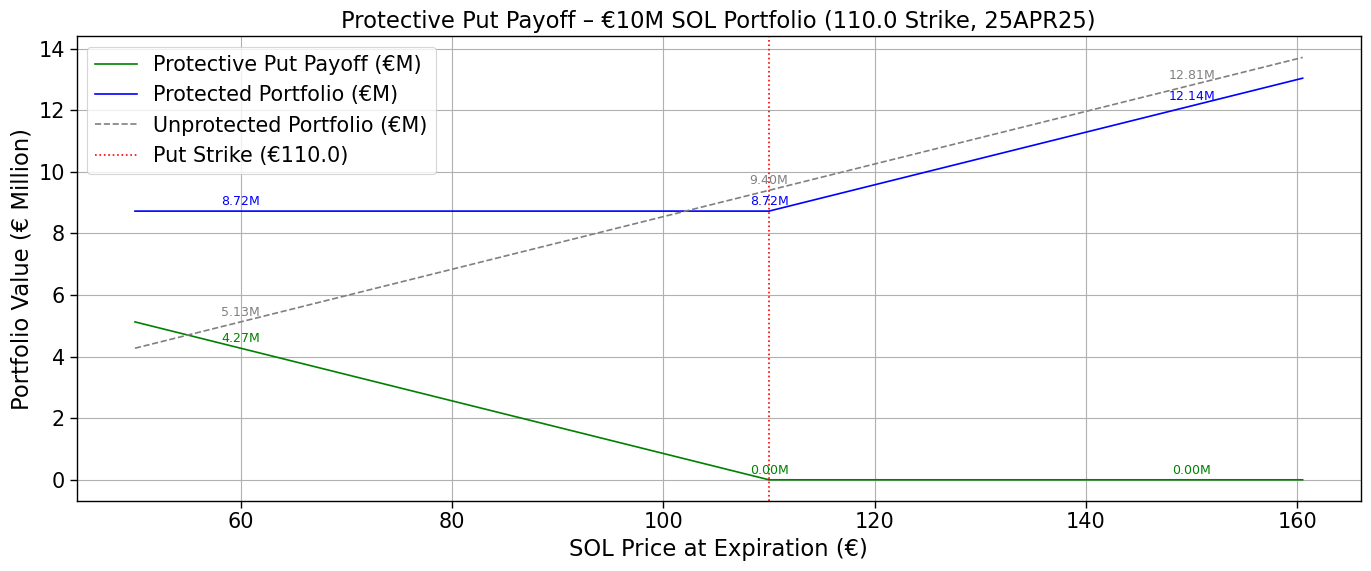

In [ ]:
# Defining the Portfolio parameters

portfolio_value = 10_000_000
spot_price = sol_data.iloc[-1]['Close']
contract_size = 10  # SOL contract multiplier

# We will build an hedge based on this maturity

desired_maturity = "25APR25"

# Filtering for put options with the desired maturity

put_options = df_options[
    (df_options['Type'].str.lower() == 'put') &
    (df_options['Maturity'].str.upper() == desired_maturity)
].copy()

# Extracting the put with strike closest to the current spot price --> We want to protect against a drop in price, so we want to insure near ATM.

# Computing the difference between each strike and current spot in order to pick the one with the minimum difference

put_options['StrikeDiff'] = abs(put_options['Strike'] - spot_price)
best_put = put_options.loc[put_options['StrikeDiff'].idxmin()]

# Extracting the strike and ask price because, as the buyer, we buy at the ask

strike_price = best_put['Strike']
option_price = best_put['Ask']
maturity = best_put['Maturity']

# Calculating how many contracts to buy and the total hedge cost

units = portfolio_value / spot_price
contracts = units / contract_size

# Since we want to fully hedge the position, for every 10 units of Solana, we buy 1 put option (will later be subtracted to account for insurance cost)

hedge_cost = contracts * option_price * contract_size

# Simulating a range of future SOlana prices from 50 to 160

prices = np.arange(50, 161, 0.5)

# Computing the values at expiration

# What our Solana is worth at each future price

underlying_value = prices * units

# Put payoff if Solana price is lower than the strike

put_payoff = np.maximum(strike_price - prices, 0) * units

# Combined portoflio and hedge payoff

total_payoff = underlying_value + put_payoff - hedge_cost

# No hedging

unprotected_payoff = underlying_value

# Plotting the payoff

plt.figure(figsize=(14, 6))

plt.plot(prices, put_payoff / 1e6, label='Protective Put Payoff (€M)', color='green')  # new
plt.plot(prices, total_payoff / 1e6, label='Protected Portfolio (€M)', color='blue')
plt.plot(prices, unprotected_payoff / 1e6, linestyle='--', color='gray', label='Unprotected Portfolio (€M)')
plt.axvline(x=strike_price, linestyle=':', color='red', label=f'Put Strike (€{strike_price})')

# Showing the price levels in the plot

for price in [60, 110, 150]:
    i = np.abs(prices - price).argmin()
    # Protective Put payoff
    plt.text(
        prices[i], put_payoff[i] / 1e6 + 0.2,
        f'{put_payoff[i]/1e6:.2f}M',
        color='green', fontsize=9, ha='center'
    )
    # Protected Portfolio payoff
    plt.text(
        prices[i], total_payoff[i] / 1e6 + 0.2,
        f'{total_payoff[i]/1e6:.2f}M',
        color='blue', fontsize=9, ha='center'
    )
    # Unprotected Portfolio payoff
    plt.text(
        prices[i], unprotected_payoff[i] / 1e6 + 0.2,
        f'{unprotected_payoff[i]/1e6:.2f}M',
        color='gray', fontsize=9, ha='center'
    )

plt.title(f'Protective Put Payoff – €10M SOL Portfolio ({strike_price} Strike, {maturity})')
plt.xlabel('SOL Price at Expiration (€)')
plt.ylabel('Portfolio Value (€ Million)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In order to insure against downside risk while retaining upside exposure, we decided to apply a protective put strategy on a 10 million euros Solana portfolio. To accomplish this, we selected a put option with a strike price of €110 (near ATM) and an expiration date of April 25th 2025.

This maturity was chosen because it is one of the closest available dates in the options dataset that still allows a few weeks of protection, roughly three weeks from the reference date of April 4, 2025 (the day we extracted the options data).

The €110 strike price was selected by filtering for the put option closest to the current spot price, making it an ATM hedge. ATM puts are typically used for downside protection because they provide immediate responsiveness to falling prices. We retrieved this specific put option directly from the df_options dataset and used its Ask price (€7.90) to reflect the real cost of entering the hedge.

* With this option, we hedged the full 10 million euros exposure by purchasing approximately 8.542 put contracts, calculated by dividing the portfolio value by the spot price, and ajusting for the contract multiplier for SOL (10). The total cost of hedging was therefore about 675.000€, which works as an insurance premium.

* In the resulting payoff chart, the gray dashed line shows the performance of the unprotected portfolio. As the SOL price decreases, the value of the portfolio falls linearly, while the opposite is true for the protective put payoff. At 60€, the unhedged portfolio would be worth approximately 5.13 million euros, exposing us to significant losses. In contrast, the protective put is worth 4.27 million at the same price level, making the blue line, which shows the protected portfolio, never drop below approximately 8.72 million euros, regardless of how low the market goes. This is the result of the put option’s intrinsic value, subtracted by the hedge cost. Importantly, when the SOL price ends up above the strike price of 110€, the put option is not exercised because there is no downside to protect against. In this case, the option expires worthless, meaning it provides no additional payout. However, the portfolio still benefits from the rise in Solana value. That is the reason why, as the price increases beyond 110€, the protected portfolio begins to follow the unhedged one, just slightly lower due to the upfront cost paid to purchase the put options.
As an example, if Solana price ends at 150€, the unprotected portfolio would be worth about 12.81 million euros, while the protected portfolio would reach around 12.14 million euros. The difference between the two (about 675.000€) represents the cost of the protection.

##### ii.) Achieve the above insurance against downside risk in a cheaper manner by giving up upside exposure.

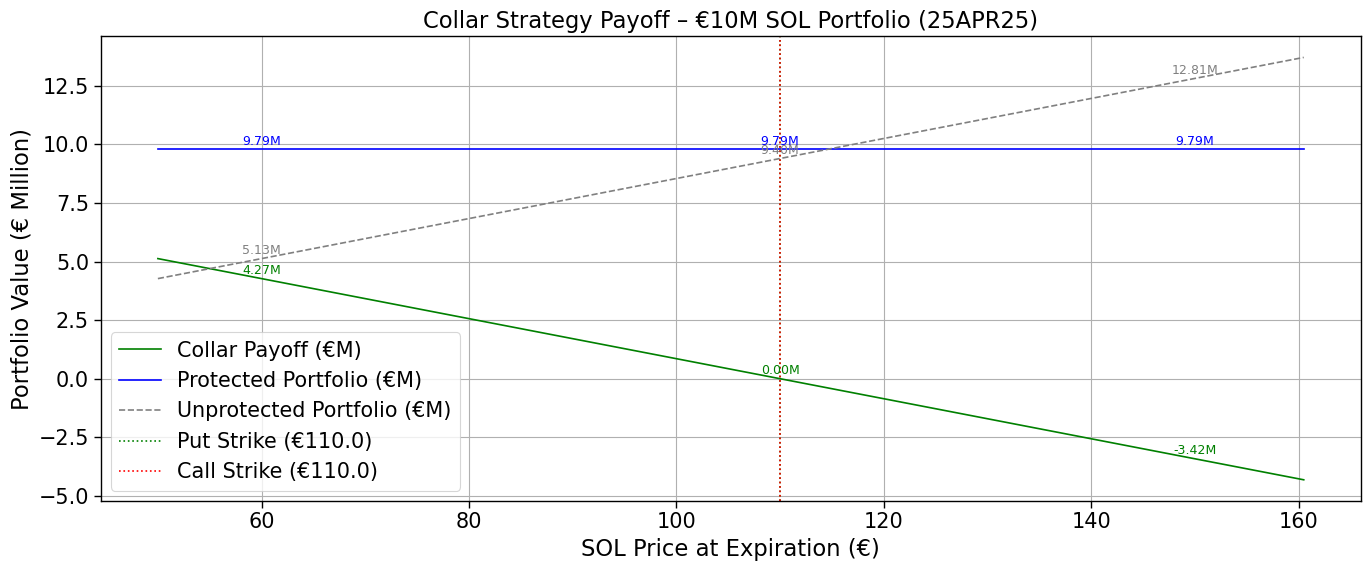

In [ ]:
# Portfolio parameters
portfolio_value = 10_000_000
spot_price = sol_data.iloc[-1]['Close']
contract_size = 10
units = portfolio_value / spot_price
contracts = units / contract_size
desired_maturity = "25APR25"

# Filtering for put and call options with the desired maturity
put_option = df_options[
    (df_options['Type'].str.lower() == 'put') &
    (df_options['Maturity'].str.upper() == desired_maturity)
].copy()

call_option = df_options[
    (df_options['Type'].str.lower() == 'call') &
    (df_options['Maturity'].str.upper() == desired_maturity)
].copy()

# Option prices
put_strike = put_option['Strike'].values[0]
put_price = put_option['Ask'].values[0]  # Ask price (per unit) because we are buying
call_strike = call_option['Strike'].values[0]
call_price = call_option['Bid'].values[0]  # Bid price (per unit) because we are selling

# Costs
put_cost = contracts * put_price * contract_size
call_premium = contracts * call_price * contract_size
net_cost = put_cost - call_premium

# Price range for payoff
prices = np.arange(50, 161, 0.5)

# Payoffs
underlying_value = prices * units
put_payoff = np.maximum(put_strike - prices, 0) * units
call_payoff = -np.maximum(prices - call_strike, 0) * units  # Negative since we are selling
total_payoff = underlying_value + put_payoff + call_payoff - net_cost
unprotected_payoff = underlying_value

# Plot
plt.figure(figsize=(14, 6))
plt.plot(prices, (put_payoff + call_payoff) / 1e6, label='Collar Payoff (€M)', color='green')  # new
plt.plot(prices, total_payoff / 1e6, label='Protected Portfolio (€M)', color='blue')
plt.plot(prices, unprotected_payoff / 1e6, '--', color='gray', label='Unprotected Portfolio (€M)')
plt.axvline(put_strike, linestyle=':', color='green', label=f'Put Strike (€{put_strike})')
plt.axvline(call_strike, linestyle=':', color='red', label=f'Call Strike (€{call_strike})')

# Showing Strategy and Underlying payoffs at key prices
for price in [60, 110, 150]:
    i = np.abs(prices - price).argmin()
    # Collar payoff
    plt.text(
        prices[i], (put_payoff[i] + call_payoff[i]) / 1e6 + 0.2,
        f'{(put_payoff[i] + call_payoff[i])/1e6:.2f}M',
        color='green', fontsize=9, ha='center'
    )
    # Protected Portfolio payoff
    plt.text(
        prices[i], total_payoff[i] / 1e6 + 0.2,
        f'{total_payoff[i]/1e6:.2f}M',
        color='blue', fontsize=9, ha='center'
    )
    # Unprotected Portfolio payoff
    plt.text(
        prices[i], unprotected_payoff[i] / 1e6 + 0.2,
        f'{unprotected_payoff[i]/1e6:.2f}M',
        color='gray', fontsize=9, ha='center'
    )

# Plot
plt.title(f'Collar Strategy Payoff – €10M SOL Portfolio ({desired_maturity})')
plt.xlabel('SOL Price at Expiration (€)')
plt.ylabel('Portfolio Value (€ Million)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

To insure against downside risk in a cost-effective way while accepting a trade-off in upside potential, we implemented a collar strategy for the €10 million Solana (SOL) portfolio. This approach involved buying put options with a strike price of €110 to safeguard against price drops and selling call options at the same €110 strike to offset the cost of the puts. Using the df_options dataframe, we selected options near the current spot price for April 25th 2025, with the put’s ask price at €7.90 and the call’s bid price at €12.50, reflecting actual costs of building the strategy. For the 85,425 SOL units — derived by dividing the portfolio value by the spot price — we purchased and sold 8,542 put and call contracts, respectively, given each contract represents 10 units of Solana. The total cost of the puts was approximately €675,000 (85,425 × 7.90), while the calls generated around €1,030,000 (85,425 × 12.50), yielding a net credit of about €355,000. This effectively made the hedge cost-free and even provided a small income.

In the payoff chart, the unprotected portfolio, shown as a gray dashed line, decreases linearly with SOL’s price, dropping to around €5.13 million at €60. The collar-protected portfolio, depicted by a blue line, maintains a stable value of approximately €9.79 million (85,425 × 110, adjusted for the net credit) across all expiration prices. This stability arises because, below €110, the put option offsets losses, while above €110, the sold call limits gains. Compared to the protective put strategy from part (i), which cost €913,000 (falso) but preserved unlimited upside, the collar eliminates both downside risk and upside potential at no net cost. For instance, at €150, the collar still yields €9.79 million, missing out on significant gains. This strategy suits investors seeking certainty in volatile markets like cryptocurrencies, but it sacrifices growth potential, making it less ideal when bullish trends are anticipated.

##### iii.) Profit from the belief that volatility in the future will be higher than currently priced by the market.

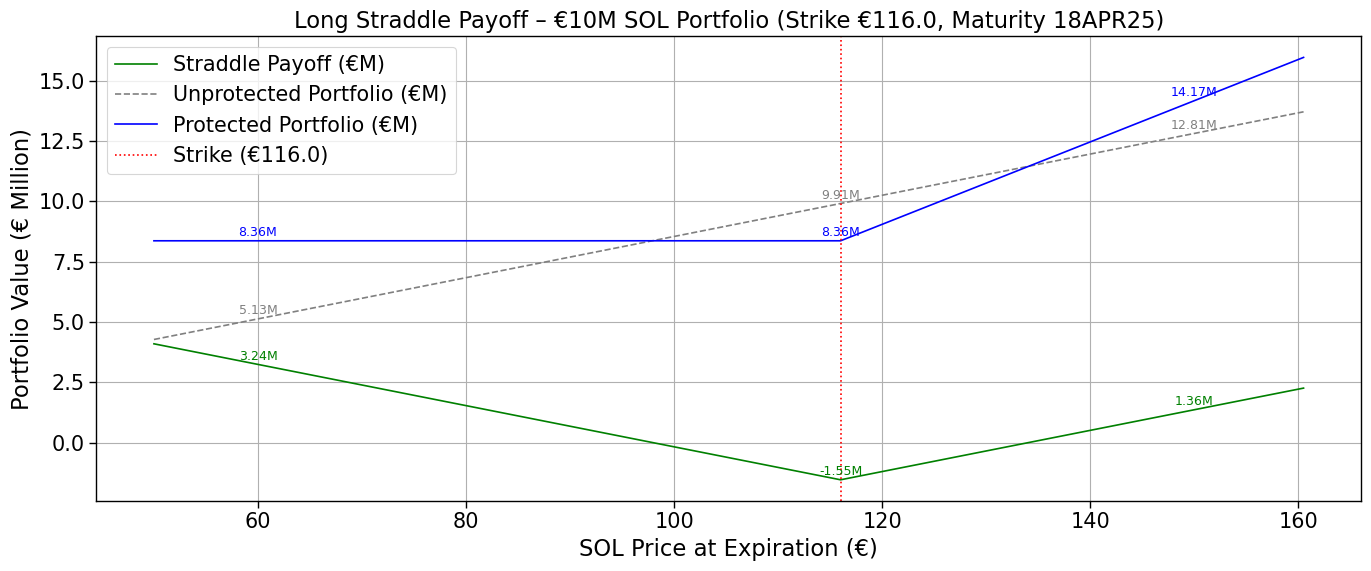

In [ ]:
# Portfolio parameters
portfolio_value = 10_000_000
spot_price = sol_data.iloc[-1]['Close']
contract_size = 10
units = portfolio_value / spot_price
contracts = units / contract_size

# Find the maturity with strike closest to spot price
maturities = df_options['Maturity'].str.upper().unique()
best_maturity = None
best_strike = None
min_strike_diff = float('inf')
best_call = None
best_put = None

for maturity in maturities:
    # Filter call and put options for this maturity
    call_options = df_options[
        (df_options['Type'].str.lower() == 'call') &
        (df_options['Maturity'].str.upper() == maturity)
    ].copy()
    put_options = df_options[
        (df_options['Type'].str.lower() == 'put') &
        (df_options['Maturity'].str.upper() == maturity)
    ].copy()

    # Find strike closest to spot price for both call and put
    call_options['StrikeDiff'] = abs(call_options['Strike'] - spot_price)
    put_options['StrikeDiff'] = abs(put_options['Strike'] - spot_price)

    strike_diff = call_options['StrikeDiff'].min()  # could be put_options['StrikeDiff'].min(), the strike prices are the same for puts and calls with the same maturity

    if strike_diff < min_strike_diff:
        min_strike_diff = strike_diff
        best_maturity = maturity
        best_call = call_options.loc[call_options['StrikeDiff'].idxmin()]
        best_put = put_options.loc[put_options['StrikeDiff'].idxmin()]
        best_strike = best_call['Strike']  # again, could be best_put['Strike'] as the strike prices are the same

# Extract option details
call_price = best_call['Ask']  # Ask price per unit (buying)
put_price = best_put['Ask']  # Ask price per unit (buying)

# Calculate costs
total_cost = (call_price + put_price) * contract_size * contracts

# Price range for payoff
prices = np.arange(50, 161, 0.5)

# Payoff calculation
underlying_value = prices * units
unprotected_payoff = underlying_value
call_payoff = np.maximum(prices - best_strike, 0) * units
put_payoff = np.maximum(best_strike - prices, 0) * units
straddle_payoff = (call_payoff + put_payoff) - total_cost
total_payoff = unprotected_payoff + straddle_payoff  # new


# Plotting
plt.figure(figsize=(14, 6))
plt.plot(prices, straddle_payoff / 1e6, color='green', label='Straddle Payoff (€M)')  # new
plt.plot(prices, unprotected_payoff / 1e6, '--', color='gray', label='Unprotected Portfolio (€M)')
plt.plot(prices, total_payoff / 1e6, color='blue', label='Protected Portfolio (€M)')
plt.axvline(best_strike, linestyle=':', color='red', label=f'Strike (€{best_strike})')

# Showing Strategy and Underlying payoffs at key prices
for price in [60, best_strike, 150]:
    i = np.abs(prices - price).argmin()
    # Straddle payoff
    plt.text(
        prices[i], straddle_payoff[i] / 1e6 + 0.2,
        f'{straddle_payoff[i]/1e6:.2f}M',
        color='green', fontsize=9, ha='center'
    )
    # Unprotected Portfolio payoff
    plt.text(
        prices[i], unprotected_payoff[i] / 1e6 + 0.2,
        f'{unprotected_payoff[i]/1e6:.2f}M',
        color='gray', fontsize=9, ha='center'
    )
    # Total Payoff
    plt.text(
        prices[i], total_payoff[i] / 1e6 + 0.2,
        f'{total_payoff[i]/1e6:.2f}M',
        color='blue', fontsize=9, ha='center'
    )

plt.title(f'Long Straddle Payoff – €10M SOL Portfolio (Strike €{best_strike}, Maturity {best_maturity})')
plt.xlabel('SOL Price at Expiration (€)')
plt.ylabel('Portfolio Value (€ Million)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

To profit from the belief that future volatility in Solana (SOL) will exceed current market expectations, we implemented a long straddle strategy on the €10 million SOL portfolio. This approach involved purchasing both a call and a put option with a strike price of €116.0, maturing on 18 April 2025, selected for being the maturity where strike prices were closest to the current spot price. To simulate actual implementation, we used the call’s ask price at €8.9 and the put’s ask price at €9.2. For the 85,425 SOL units in the portfolio, we bought approximately 8,542 call and put contracts, resulting in a total cost of about €1.55 million. This strategy is designed to capitalize on significant price movements in either direction, as it benefits from large deviations from the strike price, regardless of whether the price rises or falls.

In the payoff chart, the blue line represents the combined value of the portfolio with the straddle. At a SOL price of €60, the unprotected portfolio would be worth approximately €5.13 million, but the straddle’s put option helps offset this drop, bringing the total portfolio value to €8.36 million, in the worst case scenario. At the strike price of €116, both options expire worthless, resulting in a net loss equal to the €1.55 million premium, reducing the portfolio value to €8.36 million compared to the unprotected value of €9.91 million. However, when the SOL price rises above the strike price, the call option doubles the gains, pushing the portfolio value to €14.17 million, which exceeds the unprotected portfolio’s value of €12.81 million. Though at a higher cost than the protective put, the long straddle allows for retaining downside exposure while finding a way to enhance returns on the upside, something the protective put was not able to do.
This V-shaped payoff profile demonstrates the straddle’s ability to enhance returns in volatile markets, with the potential to offset the premium cost through gains from large price swings. For investors anticipating higher volatility, this strategy effectively leverages the portfolio’s exposure to benefit from market uncertainty, though it requires careful consideration of the premium’s impact on overall returns.

#### f) Use an approach of your choice to value options and compare to traded prices (assuming underlying follows GBM). Do you find any potential opportunities? What might this say about your approach or the market?

In [ ]:
# Create a function to calculate BSM option price for a call option
def bsm_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / sigma*np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    C = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return C

# Create a function to calculate BSM option price for a put option
def bsm_put_price(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / sigma*np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    P = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return P

In [ ]:
def get_risk_free_rate(period='3mo'):
    # Fetching the treasury rates data from Yahoo Finance
    treasury = yf.Ticker("^IRX")  # ^IRX is the symbol for 13-week (3-month) T-Bill (smallest existing timeframe in yahoo finance)
    hist = treasury.history(period='1y', start="2024-04-04", end="2025-04-04")  # Get data for the last year

    # Get the latest rate (current)
    latest_rate = hist['Close'].iloc[-1]

    # Convert the rate to a proportion (Yahoo Finance gives it in percentage points)
    risk_free_rate = latest_rate / 100
    return risk_free_rate

get_risk_free_rate()

0.04184999942779541

In [ ]:
vol_df

Window  Annualized Volatility
0    7_day_vol               0.672228
1   30_day_vol               0.840197
2   90_day_vol               1.095275
3  180_day_vol               0.936313
4  360_day_vol               0.878376

In [ ]:
# Maturity being analyzed
maturities = df_options['Maturity'].unique()

# BSM Parameters
S = sol_data.Close.iloc[-1]  # Current stock price
r = get_risk_free_rate()
sigmas = {
    'Weekly': vol_df['Annualized Volatility'][0],    # Weekly rolling window volatility
    'Monthly': vol_df['Annualized Volatility'][1]    # Monthly rolling window volatility
}

print(f"S = {S:.2f}, r = {r:.3f}, Weekly sigma = {sigmas['Weekly']:.3f}, Monthly sigma = {sigmas['Monthly']:.3f}")

S = 117.06, r = 0.042, Weekly sigma = 0.672, Monthly sigma = 0.840


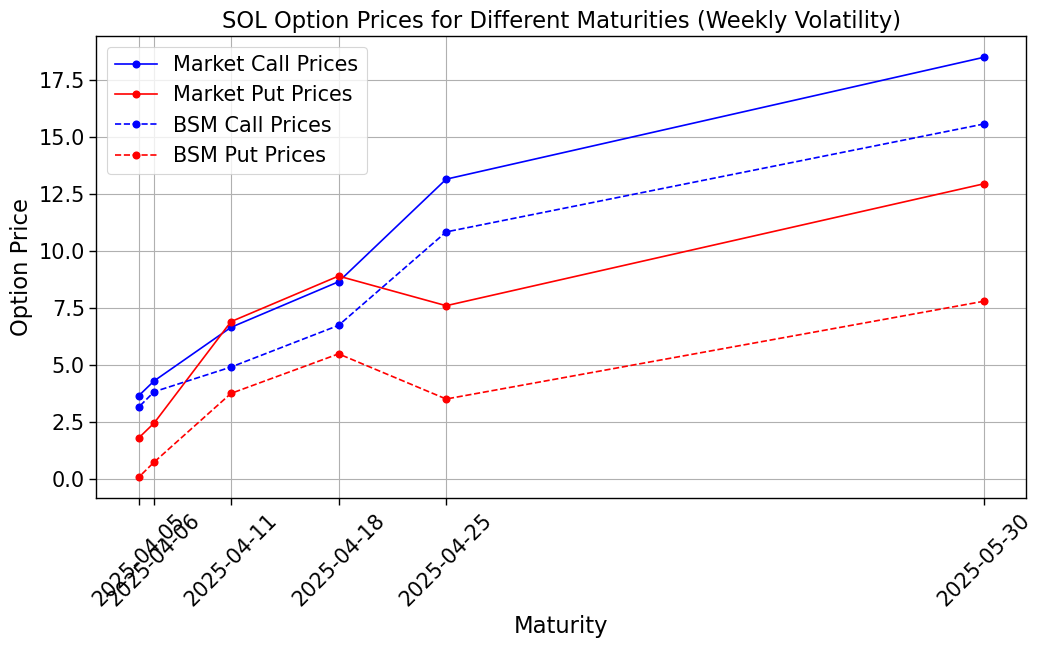

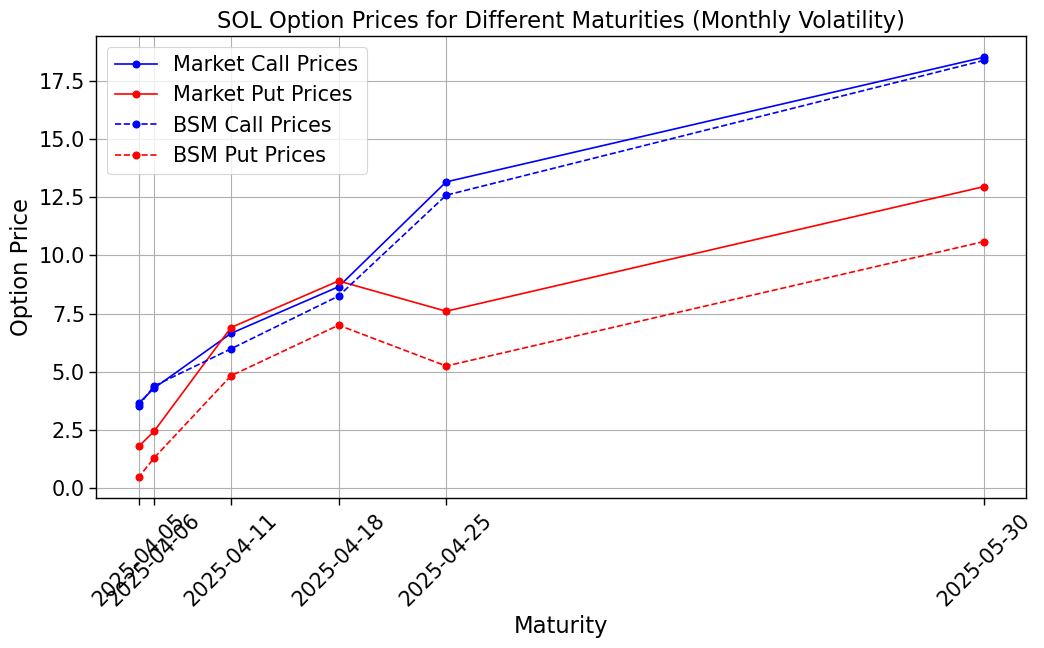

In [ ]:
# Function to calculate BSM prices for calls and puts
def calculate_bsm_prices(S, r, sigma, calls, puts):
    call_prices_bsm = [bsm_call_price(S, K, T / 360.0, r, sigma) for K, T in calls[['Strike', 'expiration']].values]
    put_prices_bsm = [bsm_put_price(S, K, T / 360.0, r, sigma) for K, T in puts[['Strike', 'expiration']].values]
    return call_prices_bsm, put_prices_bsm

# Function to plot option prices
def plot_option_prices(calls, puts, call_prices_bsm, put_prices_bsm, unique_dates, sigma, title_suffix):
    plt.figure(figsize=(12, 6))

    # Plot market call and put prices
    plt.plot(calls['Maturity Date'], calls['Mid'], label='Market Call Prices', marker='o', color='blue')
    plt.plot(puts['Maturity Date'], puts['Mid'], label='Market Put Prices', marker='o', color='red')

    # Plot BSM call and put prices
    plt.plot(calls['Maturity Date'], call_prices_bsm, label='BSM Call Prices', linestyle='--', marker='o', color='blue')
    plt.plot(puts['Maturity Date'], put_prices_bsm, label='BSM Put Prices', linestyle='--', marker='o', color='red')

    # Set x-axis ticks and labels
    plt.xticks(unique_dates, rotation=45)  # Rotate labels for readability

    # Adding title and labels
    plt.title(f'SOL Option Prices for Different Maturities ({title_suffix})')
    plt.xlabel('Maturity')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Get Mid Price
df_options['Mid'] = (df_options['Bid'] + df_options['Ask']) / 2

# Separate calls and puts
calls = df_options[df_options["Type"] == 'call']
puts = df_options[df_options["Type"] == 'put']

# Get unique maturity dates for x-axis ticks
unique_dates = df_options['Maturity Date'].unique()

# Generate plots for each sigma
for period, sigma in sigmas.items():
    # Calculate BSM prices
    call_prices_bsm, put_prices_bsm = calculate_bsm_prices(S, r, sigma, calls, puts)

    # Plot the results
    plot_option_prices(calls, puts, call_prices_bsm, put_prices_bsm, unique_dates, sigma, f"{period} Volatility")

To value the options, we employed the Black-Scholes-Merton (BSM) model with both weekly and monthly historical annualized volatilities, comparing theoretical prices to traded market prices across daily, weekly, and monthly maturities. Using weekly volatility, the BSM model closely matched market prices for daily calls, indicating that short-term volatility estimates align well with market expectations for near-term expirations; however, the gap between BSM and market prices widened significantly for weekly and monthly maturities, suggesting an undervaluation as maturity increases. This approach consistently undervalued put options. In contrast, using monthly volatility provided a very close match for call options across all maturities, reflecting better alignment with market pricing for calls, but still consistently undervalued put options, though with a smaller gap and not increasing as maturities increase.

The consistent undervaluation of puts using monthly volatility, alongside the increasing gap for longer maturities with weekly volatility, suggests potential arbitrage opportunities. This discrepancy indicates that the BSM model’s constant volatility assumption struggles to capture SOL’s complex price dynamics, particularly for puts, which may be influenced by market-specific factors like downside risk premiums or speculative behavior in cryptocurrencies. The better performance of monthly volatility for calls suggests it might be more suitable for our analysis, while the market’s higher pricing could reflect inefficiencies or unmodeled risks, encouraging further investigation into alternative models or market conditions to exploit these pricing differences.

### 2. Research and select an alternative model (or multiple alternative models) for cryptocurrency option pricing.

#### Alternative Model 1

#### a) Explain your approach and the theoretical advantages over Black-Scholes-Merton and why it is more appropriate for cryptocurrency.

The first alternative approach we will be testing is a Bidirectional 2-Layered LSTM neural network to predict future realized volatility, which can then be plugged into the BSM's option pricing formulas instead of realized volatility. The Bi-LSTM is a type of recurrent neural network (RNN) that is well-suited to analyze time series data. It is a variant of the Long Short-Term Memory (LSTM) model that is capable of processing input sequences in both forward and backward directions. The basic LSTM model is a type of RNN that is commonly used for sequential data analysis, such as time series forecasting. The Bi-LSTM model extends the basic LSTM by adding a second LSTM layer that processes the input sequence in reverse order. This allows the model to capture both forward and backward dependencies in the input data, which can be useful for tasks such as stock price prediction and volatility prediction, as the model learns patterns more comprehensively than unidirectional LSTMs. (From: *Challenge and Opportunity: Deep Learning-Based Stock Price Prediction by Using Bi-Directional LSTM Model*, by Chenyu Han and Xiaoyu Fu. ISSN: 2766-824X, Frontiers in Business, Economics and Management).

"Relying on knowledge of the future seems at first sight to violate causality. How can we base our understanding of what we’ve heard on something that hasn’t been said yet? However, human listeners do exactly that. Sounds, words, and even whole sentences that at first mean nothing are found to make sense in the light of future context. What we must remember is the distinction between tasks that are truly online – requiring an output after every input – and those where outputs are only needed at the end of some input segment." - Alex Graves and Jurgen Schmidhuber, *Framewise Phoneme Classification with Bidirectional LSTM and Other Neural Network Architectures*, 2005.

The model processes multivariate inputs — current volatility, trading volume, high-low spread, and close-open spread — to forecast vol_future in 7 days. To compete with BSM's best approach seen above, this prediction will be the average daily realized volatility of the 30 days prior to the future date, the equivalent to the monthly rolling volatility. The final prediction will then be annualized and plugged in BSM's formulas for option pricing. The LSTM’s architecture, with 32 and 16 units in two bidirectional layers followed by a single dense layer, captures temporal dependencies and non-linear patterns, trained with MSE loss and RMSPE metrics to ensure accuracy. We use a batch size of 64 and train the model for 200 epochs, or until validation RMSPE stops increasing for 30 epochs.

**Theoretical Advantages Over BSM:**

- Dynamic Volatility: Unlike BSM’s constant volatility, the LSTM models volatility as a time-varying process, adapting to recent market trends.
- Multivariate Inputs: Incorporates volume and spread data, capturing broader market signals ignored by BSM.
- Non-Linear Modeling: Learns complex patterns, unlike BSM’s lognormal assumption.
- Adaptability: Continuously updates with new data, staying relevant in fast-changing markets like cryptocurrency markets.

**Why it is More Appropriate for Cryptocurrency:**

Cryptocurrency markets are highly volatile, non-stationary, and driven by speculative and sentiment-based trading, challenging BSM’s assumptions of constant volatility and efficient markets. This BiLSTM model excels in this environment by capturing volatility clustering and regime shifts, which are common in crypto. It can also adapt to 24/7 trading with real-time data and model inefficiencies via multivariate inputs, as well as handle extreme events better than BSM’s lognormal framework.

This approach should provide a more robust and flexible framework for volatility forecasting, making it particularly suited for pricing options and managing risk in the dynamic cryptocurrency market.


#### b) Fit the model(s) and compare your pricing results, how do they compare to the previously calculated values in question 1?

As this approach will use a Deep Learning model, we will gather as much data as possible to better train the model. The oldest data available on Yahoo Finance dates back to April 10th 2020.

In [ ]:
sol_data = yf.download('SOL-USD', start="2020-04-10", end='2025-04-03', multi_level_index=False)
sol_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Close      High       Low      Open    Volume
Date                                                        
2020-04-10  0.951054  1.313487  0.694187  0.832005  87364276
2020-04-11  0.776819  1.049073  0.765020  0.951054  43862444
2020-04-12  0.882507  0.956670  0.762426  0.785448  38736897
2020-04-13  0.777832  0.891603  0.773976  0.890760  18211285
2020-04-14  0.661925  0.796472  0.628169  0.777832  16747614

In [ ]:
df = sol_data.copy()
df['log_returns'] = np.log(df.Close/df.Close.shift(1))  # Compute log returns
df.dropna(inplace=True)

df.head()

Close      High       Low      Open    Volume  log_returns
Date                                                                     
2020-04-11  0.776819  1.049073  0.765020  0.951054  43862444    -0.202363
2020-04-12  0.882507  0.956670  0.762426  0.785448  38736897     0.127559
2020-04-13  0.777832  0.891603  0.773976  0.890760  18211285    -0.126256
2020-04-14  0.661925  0.796472  0.628169  0.777832  16747614    -0.161358
2020-04-15  0.646651  0.704964  0.621531  0.669289  13075275    -0.023346

In [ ]:
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated
    as the sample standard deviation of log returns
    """
    return np.std(series_log_return, ddof=1) # ddof = 1 To ensure calculation of sample standard deviation

Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Target "future" data in this case is obtained by shifting the current volatility backward by the number of n_future lags.

For example, respected to last week's Monday, this week's Monday is the "future"; therefore we just need to shift the volatility this week back by 7 days, and use it as the desired "future" output for last week's, which we would then use for Neural Networks training and model performance evaluation.

The target here would be **vol_future** which represents the daily realized volatility of the next **n_future** days from today (average daily volatility from **t + n_future - WINDOW** to time step **t + n_future**). **WINDOW** refers to the lookback period.

For example, using an **n_future** value of 7 and a **WINDOW** of 30, the value that I want to predict at time step **t** would be the average daily realized volatility from time step **t-22** to time step **t+7** (equivalent to monthly rolling volatility).

In [ ]:
WINDOW = 30
n_future = 7


df['vol_current'] = df.log_returns.rolling(window=WINDOW)\
                                   .apply(realized_volatility_daily)

df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=WINDOW)\
                                 .apply(realized_volatility_daily)

df.dropna(inplace=True) # The first 30 and last 7 observations have insufficient input data / NaN future volatility, so we remove these observations
df.head()

Close      High       Low      Open   Volume  log_returns  \
Date                                                                       
2020-05-10  0.537034  0.612303  0.513081  0.604461  2327581    -0.118385   
2020-05-11  0.515273  0.571860  0.505194  0.536255  2098481    -0.041365   
2020-05-12  0.538576  0.559759  0.505251  0.513391  2198625     0.044232   
2020-05-13  0.550532  0.564874  0.518038  0.538372  2326446     0.021956   
2020-05-14  0.569118  0.580946  0.550110  0.550532  2047897     0.033203   

            vol_current  vol_future  
Date                                 
2020-05-10     0.091494    0.073823  
2020-05-11     0.084852    0.074552  
2020-05-12     0.081361    0.071894  
2020-05-13     0.078928    0.069785  
2020-05-14     0.074033    0.068567

In [ ]:
df.describe()

Close         High          Low         Open        Volume  \
count  1782.000000  1782.000000  1782.000000  1782.000000  1.782000e+03   
mean     75.121598    78.084315    72.059236    75.062202  1.781658e+09   
std      71.056997    73.681056    68.353668    71.091288  2.280964e+09   
min       0.515273     0.559759     0.505194     0.513391  6.520200e+05   
25%      19.475195    19.975141    19.092960    19.457784  2.919506e+08   
50%      38.531967    40.435625    36.441355    38.515244  1.141349e+09   
75%     139.326809   144.359165   134.013721   139.309464  2.559945e+09   
max     261.869751   294.334961   253.187439   261.872437  3.317296e+10   

       log_returns  vol_current   vol_future  
count  1782.000000  1782.000000  1782.000000  
mean      0.003045     0.060759     0.060709  
std       0.066479     0.026202     0.026183  
min      -0.549582     0.025450     0.025450  
25%      -0.031264     0.042866     0.042866  
50%       0.000169     0.053218     0.053181  
75%       0.035149     0.072964     0.072595  
max       0.387184     0.150261     0.150261

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1782 entries, 2020-05-10 to 2025-03-26
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        1782 non-null   float64
 1   High         1782 non-null   float64
 2   Low          1782 non-null   float64
 3   Open         1782 non-null   float64
 4   Volume       1782 non-null   int64  
 5   log_returns  1782 non-null   float64
 6   vol_current  1782 non-null   float64
 7   vol_future   1782 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 125.3 KB


##### Data Preprocessing

###### 1. Feature Engineering

The Open/High/Low/Close prices are usually very similar and highly correlated to each other. Therefore, instead of keeping all of them in the dataset, we will add 2 more features:

- **High-Low Spread** - which is the logarithm of the difference between the Highest and Lowest prices intraday as a percentage of the Closing price

- **Open-Close Spread** - which is the difference between the Close and Open prices intraday as a percentage of the Closing price
and then for Volume:

The Volume column has very large values that are billions/millions of times larger than the other features. Therefore we are going to the get log of it, to hopefully transform it into a more normal looking distribution.

In [ ]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

df.head()

Close      High       Low      Open     Volume  log_returns  \
Date                                                                         
2020-05-10  0.537034  0.612303  0.513081  0.604461  14.660340    -0.118385   
2020-05-11  0.515273  0.571860  0.505194  0.536255  14.556724    -0.041365   
2020-05-12  0.538576  0.559759  0.505251  0.513391  14.603343     0.044232   
2020-05-13  0.550532  0.564874  0.518038  0.538372  14.659852     0.021956   
2020-05-14  0.569118  0.580946  0.550110  0.550532  14.532324     0.033203   

            vol_current  vol_future   HL_sprd   CO_sprd  
Date                                                     
2020-05-10     0.091494    0.073823 -1.688702 -0.111549  
2020-05-11     0.084852    0.074552 -2.045002 -0.039127  
2020-05-12     0.081361    0.071894 -2.290581  0.049056  
2020-05-13     0.078928    0.069785 -2.464233  0.022587  
2020-05-14     0.074033    0.068567 -2.915404  0.033760

Since **vol_current** is already derived from **log_returns**, we are not going to include **log_returns** in the model.

Finally, we will eliminate the **Close, Open, High, Low** columns.

In [ ]:
features = ['Volume', 'vol_current', 'HL_sprd', 'CO_sprd']

# Separate input data frame
df_input = df[features]

df_input.head()

Volume  vol_current   HL_sprd   CO_sprd
Date                                                  
2020-05-10  14.660340     0.091494 -1.688702 -0.111549
2020-05-11  14.556724     0.084852 -2.045002 -0.039127
2020-05-12  14.603343     0.081361 -2.290581  0.049056
2020-05-13  14.659852     0.078928 -2.464233  0.022587
2020-05-14  14.532324     0.074033 -2.915404  0.033760

###### 2. Train-Validation-Test Splits

There're a total of 1782 usable datapoints in this dataset which covers a period of almost 5 years from April 2020 until today (early April 2025). Since cryptocurrencies are not traded on a regulated exchange, the market is open 24/7, thus 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

We will split the dataset into 3 parts as follows:

- the most recent 30 usable datapoints would be used for Final Model Testing - approx. 1.7%
- 1 full year (365 days) for Validation and Model Tuning during training - approx. 20.5%
- and the remaining for Training - approx. 77.8%

In [ ]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df_input) - (val_size + test_size)
split_time_2 = len(df_input) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df_input.index[:split_time_1]
val_idx = df_input.index[split_time_1:split_time_2]
test_idx = df_input.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2020-05-10 00:00:00 	to: 2024-02-25 00:00:00 	1387 days
VALIDATION 	From: 2024-02-26 00:00:00 	to: 2025-02-24 00:00:00 	365 days
TEST 		From: 2025-02-25 00:00:00 	to: 2025-03-26 00:00:00 	30 days


In [ ]:
# SPLIT THE DATA INTO THE 3 PARTS
# These will be the inputs for the LSTM model
X_train = df_input.loc[train_idx]
X_val = df_input.loc[val_idx]
X_test = df_input.loc[test_idx]

In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS
# These will be the targets
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [ ]:
print(df_input.info())
print('\t')
print(X_train.info())
print('\t')
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1782 entries, 2020-05-10 to 2025-03-26
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Volume       1782 non-null   float64
 1   vol_current  1782 non-null   float64
 2   HL_sprd      1782 non-null   float64
 3   CO_sprd      1782 non-null   float64
dtypes: float64(4)
memory usage: 134.1 KB
None
	
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2020-05-10 to 2024-02-25
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Volume       1387 non-null   float64
 1   vol_current  1387 non-null   float64
 2   HL_sprd      1387 non-null   float64
 3   CO_sprd      1387 non-null   float64
dtypes: float64(4)
memory usage: 54.2 KB
None
	
<class 'pandas.core.series.Series'>
DatetimeIndex: 1387 entries, 2020-05-10 to 2024-02-25
Series name: vol_future
Non-Null Count  Dtype  
-------------

###### 3. Feature Normalization
It is usually best practice to normalize the volatilities to standardize the predictions. Additionally, LSTM models uses sigmoid and tanh activation functions, which are very sensitive to feature magnitude.
We will be following the other examples and use **MinMaxScaler**.

In [ ]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on training data only
X_train_scaled = scaler.fit_transform(X_train)
# Transform validation and test sets using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


# Initialize the target variable scaler
y_scaler = MinMaxScaler()

# Scale the targets
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Convert back to Dated Series
y_train_scaled = pd.Series(y_train_scaled, index=y_train.index)
y_val_scaled = pd.Series(y_val_scaled, index=y_val.index)
y_test_scaled = pd.Series(y_test_scaled, index=y_test.index)

In [ ]:
X_train_scaled.describe()

Volume  vol_current      HL_sprd      CO_sprd
count  1387.000000  1387.000000  1387.000000  1387.000000
mean      0.621328     0.319626     0.480120     0.479684
std       0.205266     0.219831     0.135306     0.079898
min       0.000000     0.000000     0.000000     0.000000
25%       0.560047     0.168341     0.390687     0.436998
50%       0.673755     0.255027     0.478597     0.473107
75%       0.772788     0.427581     0.565849     0.515935
max       1.000000     1.000000     1.000000     1.000000

In [ ]:
X_train.head(), X_train_scaled.head()

(               Volume  vol_current   HL_sprd   CO_sprd
 Date                                                  
 2020-05-10  14.660340     0.091494 -1.688702 -0.111549
 2020-05-11  14.556724     0.084852 -2.045002 -0.039127
 2020-05-12  14.603343     0.081361 -2.290581  0.049056
 2020-05-13  14.659852     0.078928 -2.464233  0.022587
 2020-05-14  14.532324     0.074033 -2.915404  0.033760,
               Volume  vol_current   HL_sprd   CO_sprd
 Date                                                 
 2020-05-10  0.125091     0.529154  0.665400  0.348152
 2020-05-11  0.114905     0.475934  0.586422  0.429118
 2020-05-12  0.119488     0.447965  0.531987  0.527704
 2020-05-13  0.125043     0.428468  0.493495  0.498111
 2020-05-14  0.112507     0.389251  0.393488  0.510603)

In [ ]:
y_train.head(), y_train_scaled.head()

(Date
 2020-05-10    0.073823
 2020-05-11    0.074552
 2020-05-12    0.071894
 2020-05-13    0.069785
 2020-05-14    0.068567
 Name: vol_future, dtype: float64,
 Date
 2020-05-10    0.387567
 2020-05-11    0.393413
 2020-05-12    0.372113
 2020-05-13    0.355220
 2020-05-14    0.345458
 dtype: float64)

###### Train-Validation-Test Visualization

Visualization will be easier on the scaled targets.

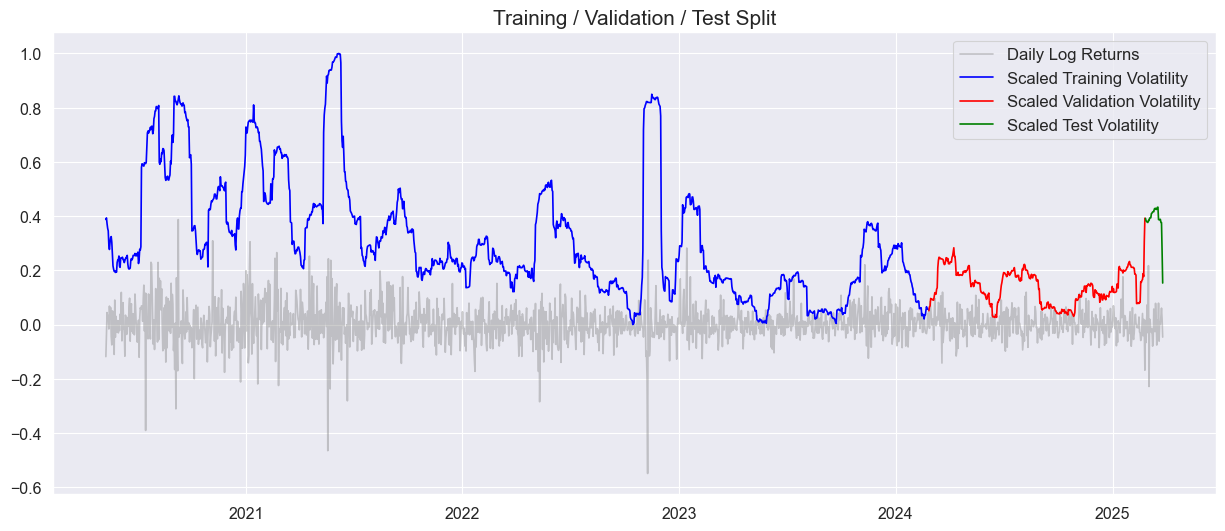

In [ ]:
sns.set_context("paper", font_scale=1.3)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(15,6))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue',
             label='Scaled Training Volatility')
    plt.plot(y_val_scaled, color='red',
             label='Scaled Validation Volatility')
    plt.plot(y_test_scaled, color='green',
             label='Scaled Test Volatility')

    plt.plot()
    plt.title('Training / Validation / Test Split', fontsize=15)
    plt.legend(frameon=True, fontsize=12)

    plt.show();

##### Useful Functions

In [ ]:
def RMSPE(y_true, y_pred):                        # Calculated using TensorFlow
    """
    Compute Root Mean Squared Percentage Error between 2 tensors
    """
    # Ensure y_true and y_pred are float32 for compatibility
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Compute RMSPE using TensorFlow operations
    squared_diff = tf.square((y_true - y_pred) / y_true)
    mean_squared_diff = tf.reduce_mean(squared_diff)
    rmspe = tf.sqrt(mean_squared_diff)

    return rmspe

In [ ]:
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(X_val.vol_current, color='gray',  ls=':',
                label=f"Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

For Neural Networks, instead of feeding all available datapoints into the network at once, we will use a sliding lookback window to extract uniform input arrays and target outputs. We will use a stride value of 1 to make sure we get all the inputs and output combinations available since 1782 datapoints is not really a whole lot to spare.

Here is a demonstration of a sliding window:

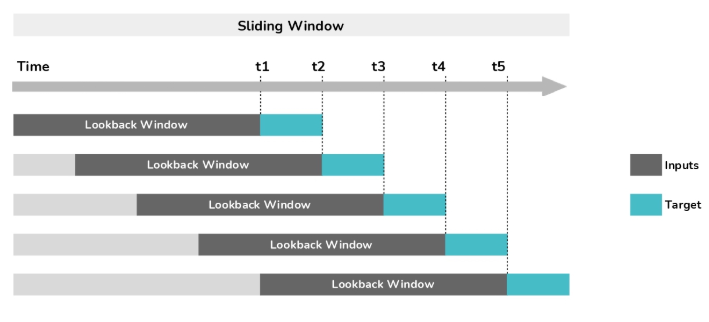

In [ ]:
Image(filename='C:/Users/20241560/Desktop/Financial Derivatives/Sliding Window.png')

In [ ]:
# CONVERT A SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

To generate predictions, we will use the same sliding window concept:

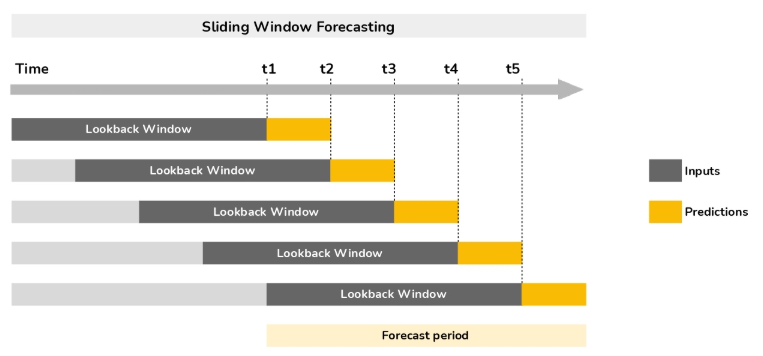

In [ ]:
Image(filename='C:/Users/20241560/Desktop/Financial Derivatives/Sliding Window Forecast.png')

This means that to generate future predictions for a time step t, we will need to traverse back in time and collect the last n_past datapoints (from time step t - n_past + 1 to t inclusively). That's why the shape of the inputs into these Neural Networks need to be [batch_size, n_past, 1].

In [ ]:
# FORECAST USING DIFFERENT MODELS AND DIFFERENT RANGES
def forecast_multi(model, range_idx, input_scaler):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]

    # Get corresponding data and scale it
    input_data = df_input[start_idx:end_idx]
    input_scaled = input_scaler.transform(input_data)
    input_scaled = pd.DataFrame(input_scaled, columns=df_input.columns, index=input_data.index)

    # Get the sliding window for input
    mat_X, _ = windowed_dataset(input_scaled,
                                df.vol_future[range_idx], n_past)
    preds = model.predict(mat_X)[:, 0]

    return pd.Series(preds, index=range_idx)

In [ ]:
# VISUALIZE TRAINING AND VALIDATION ERROR METRICS
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

In [ ]:
# VISUALIZE TRAINING AND VALIDATION ERROR METRICS
def viz_train_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['loss'], color='red',
                    label='Training MSE', lw=2)

        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['rmspe'], color='blue', lw=2,
                    label='Training RMSPE')

        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln21
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training Learning Curves')
        plt.show();

##### Multivariate 2-Layered Bidirectional LSTM Model

Will be using a simple 2 layered BiLSTM model that will include dropout. As usual in the deep learning industry, a recurrent dropout path will be applied instead of a naive dropout path. Making predictions on non-scaled targets generated better results. To avoid adding unnecessary information to an already packed notebook, we will ommit this analysis.

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(42)

n_past = 30
batch_size = 64
n_dims = df_input.shape[1]

# PREPARE TRAINING AND VALIDATION DATA
#mat_X_train, mat_y_train = windowed_dataset(X_train_scaled, y_train_scaled, n_past)
mat_X_train, mat_y_train = windowed_dataset(X_train_scaled, y_train, n_past) # non scaled testing
#mat_X_val, mat_y_val = windowed_dataset(X_val_scaled, y_val_scaled, n_past)
mat_X_val, mat_y_val = windowed_dataset(X_val_scaled, y_val, n_past) # non scaled testing

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
bilstm = Sequential()
bilstm.add(InputLayer(input_shape=[n_past, n_dims]))
# ADDING 1st LSTM LAYER
bilstm.add(Bidirectional(LSTM(32, recurrent_dropout=0.1, return_sequences=True)))
# ADDING 2nd LSTM LAYER
bilstm.add(Bidirectional(LSTM(16, recurrent_dropout=0.1)))
# DENSE OUTPUT LAYER
bilstm.add(Dense(1))

bilstm.compile(loss='mse',
             optimizer="adam",
             metrics=[RMSPE])

checkpoint_cb = ModelCheckpoint('bilstm.keras',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe',
                                  mode='min')

print(bilstm.summary())

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 30, 64)              │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,873 (77.63 KB)

 Trainable params: 19,873 (77.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# FITTING TO TRAINING DATA
bilstm_res = bilstm.fit(mat_X_train, mat_y_train,
                      callbacks=[checkpoint_cb, early_stopping_cb],
                      validation_data=(mat_X_val, mat_y_val), shuffle=False,
                      verbose=0, batch_size=batch_size, epochs=200)

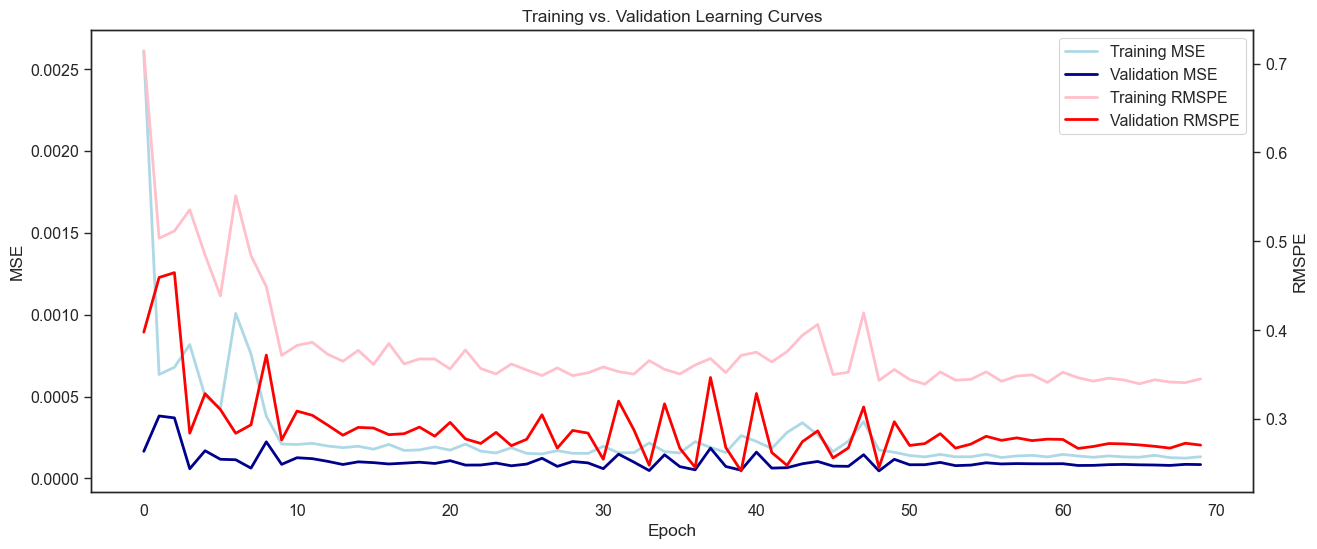

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(bilstm_res)

We can see training stopped a just before epoch number 70, thanks to the early stopping callback which stopped the training if validation RMSPE hadn't improved for 30 epochs.

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step


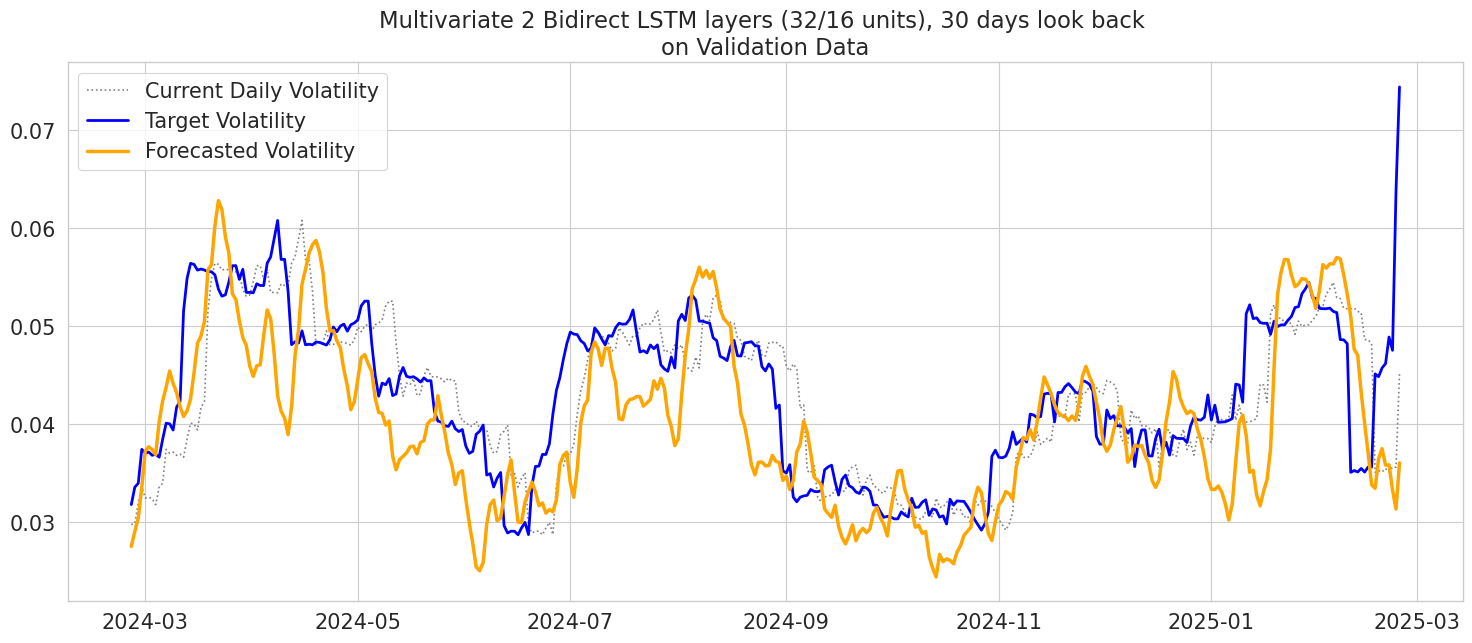

In [ ]:
# FORECASTING ON VALIDATION SET
bilstm_preds = forecast_multi(bilstm, val_idx, scaler)

# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val, bilstm_preds,
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")

plt.show();

In [ ]:
['BiLSTM',
RMSPE(y_val, bilstm_preds),
RMSE(y_val, bilstm_preds)]

['BiLSTM',
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14986304938793182>,
 0.006991711085113994]

It is interesting to see the model performs relatively well on the validation set, with a ~0.15 root mean square percentage error, but it was still unable to understand the abrupt volatility movement in the final part of the dataset. Nonetheless, we can see the predictions above matched actual volatility pretty well across the rest of time.

We are pretty happy with the model results. Let us then take this final model and train it on training plus validation and run predictions for the test set.

In [ ]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
X_train_val = df_input[:split_time_2]
y_train_val = df.vol_future[:split_time_2]

# GET CORRESPONDING DATETIME INDEX
train_val_idx = df_input.index[:split_time_2]

In [ ]:
# SCALE
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on training & validation data
X_train_val_scaled = scaler.fit_transform(X_train_val)
# Transform test set using the same scaler
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_val_scaled = pd.DataFrame(X_train_val_scaled, columns=X_train_val.columns, index=X_train_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


# Initialize the target variable scaler
y_scaler = MinMaxScaler()

# Scale the targets
y_train_val_scaled = y_scaler.fit_transform(y_train_val.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Convert back to Dated Series
y_train_val_scaled = pd.Series(y_train_val_scaled, index=y_train_val.index)
y_test_scaled = pd.Series(y_test_scaled, index=y_test.index)

In [ ]:
# PREPARE TRAINING & VALIDATION DATA
mat_X_tv, mat_y_tv = windowed_dataset(X_train_val_scaled, y_train_val, n_past)

# SETTING NEW CHECKPOINT CALLBACK
checkpoint_cb = ModelCheckpoint('final_bilstm.keras',
                               monitor='rmspe',
                               save_best_only=True,
                               mode='min')

Following standard practice, we will re-train the model reusing the trained weights, allowing the model to fine-tune rather than relearn from scratch in an efficient way.

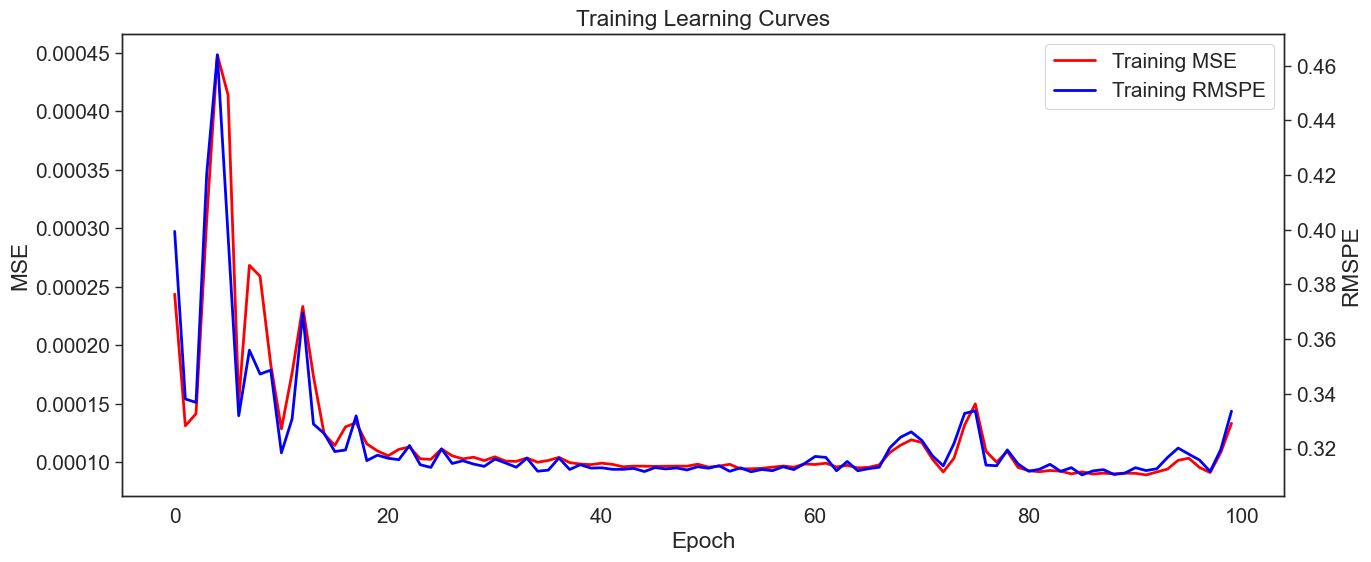

In [ ]:
# FITTING TO TRAINING & VALIDATION DATA
final_bilstm_res = bilstm.fit(mat_X_tv, mat_y_tv,
                      callbacks=[checkpoint_cb],
                      validation_split=0.0, shuffle=False,          # No validation split
                      verbose=0, batch_size=batch_size, epochs=100)  # Train for a bit longer than the best model

# VISUALIZING LEARNING CURVES
viz_train_metrics(final_bilstm_res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


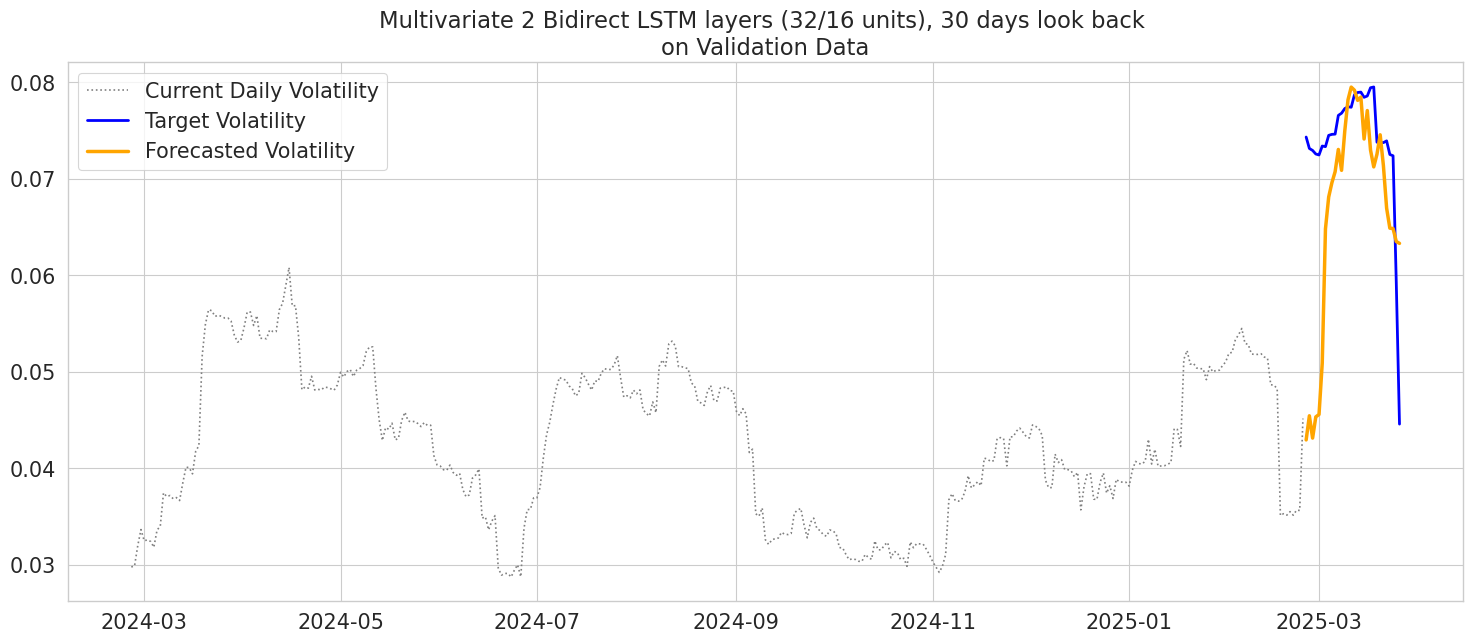

In [ ]:
# FORECASTING ON TEST SET
final_bilstm_preds = forecast_multi(bilstm, test_idx, scaler)

# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_test, final_bilstm_preds,
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")

plt.show();

In [ ]:
['Final BiLSTM',
RMSPE(y_test, final_bilstm_preds),
RMSE(y_test, final_bilstm_preds)]

['Final BiLSTM',
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1944458782672882>,
 0.013531961071268661]

Predictions on the test matched actual volatility pretty well, especially given the turbulent times lived around this time.

With our model finalized, we can proceed to predicting future volatility and use it as input for the BSM approach to option pricing, as opposed to historical volatility.

##### Predict Future Volatility as of Today

In [ ]:
WINDOW = 30

# Data Preprocessing
df_new = sol_data.copy()
df_new['log_returns'] = np.log(df_new.Close/df_new.Close.shift(1))
df_new['vol_current'] = df_new.log_returns.rolling(window=WINDOW)\
                              .apply(realized_volatility_daily)

df_new['HL_sprd'] = np.log((df_new.High - df_new.Low) / df_new.Close)
df_new['CO_sprd'] = (df_new.Close - df_new.Open) / df_new.Open
df_new['Volume'] = np.log(df_new.Volume)

df_new = df_new[features]

# Select the 30 most recent observations
X_final = df_new.tail(WINDOW)

# Transform using the same scaler as the final model
X_final_scaled = scaler.transform(X_final)

# Reshape input for the model which expects (batch_size, timesteps, features)
n_dims = X_final.shape[1]
X_final_scaled = X_final_scaled.reshape(1, WINDOW, n_dims)

# Making the prediction
pred = bilstm.predict(X_final_scaled)[:, 0]
volatility_prediction = pred[0]

# Annualizing
annualized_volatility_prediction = volatility_prediction * np.sqrt(360)

# Output
print(f"Predicted 30-day future volatility: {volatility_prediction:.4f}")
print(f"Annualized volatility: {annualized_volatility_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted 30-day future volatility: 0.0513
Annualized volatility: 0.9726347549038183


This prediction can now be used as an input into the BSM model to compare pricing results.

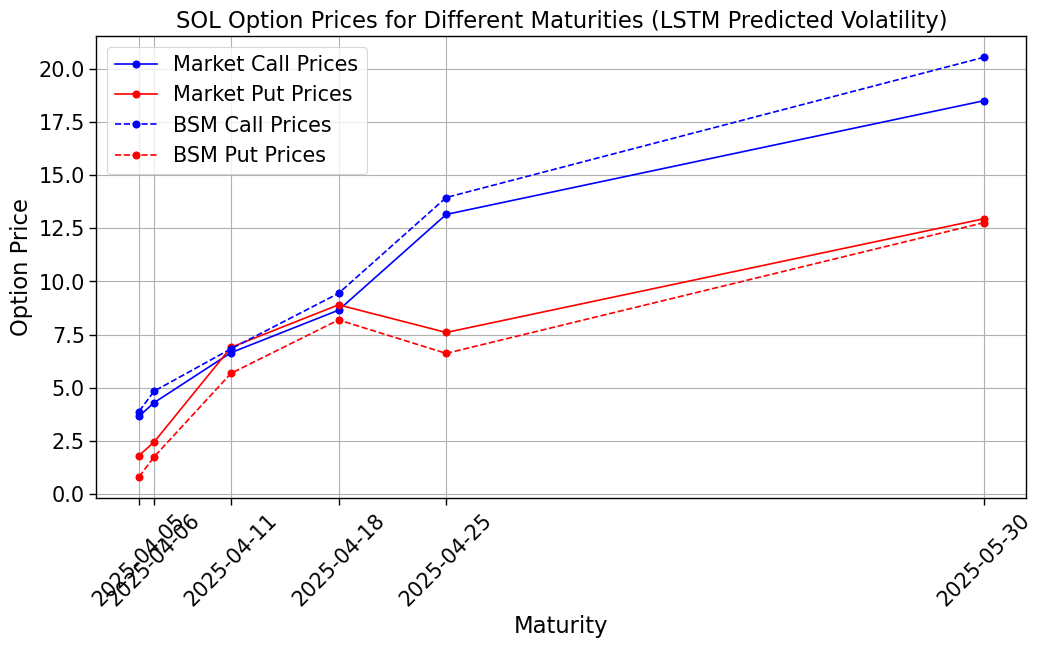

In [ ]:
# Calculate BSM prices with LSTM volatility prediction
call_prices_bilstm, put_prices_bilstm = calculate_bsm_prices(S, r, annualized_volatility_prediction, calls, puts)

# Plot the results
plot_option_prices(calls, puts, call_prices_bilstm, put_prices_bilstm, unique_dates, annualized_volatility_prediction, f"LSTM Predicted Volatility")

In [ ]:
print('BiLSTM fit to Market Calls')
print(f'RMSPE: {RMSPE(call_prices_bilstm, calls['Mid']):.4}')
print(f'RMSE: {RMSE(call_prices_bilstm, calls['Mid']):.4f}')

BiLSTM fit to Market Calls
RMSPE: 0.07805
RMSE: 0.9836


In [ ]:
print('BiLSTM fit to Market Puts')
print(f'RMSPE: {RMSPE(put_prices_bilstm, puts['Mid']):.4}')
print(f'RMSE: {RMSE(put_prices_bilstm, puts['Mid']):.4f}')

BiLSTM fit to Market Puts
RMSPE: 0.553
RMSE: 0.8658


Let us recall BSM's fit to Market Prices.

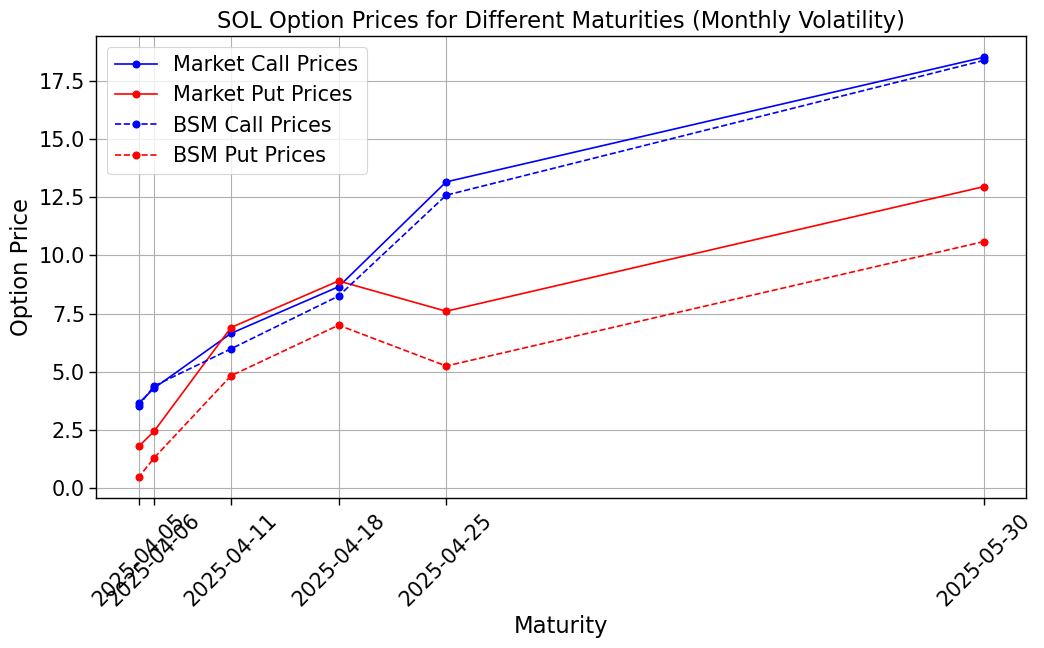

In [ ]:
plot_option_prices(calls, puts, call_prices_bsm, put_prices_bsm, unique_dates, sigmas['Monthly'], 'Monthly Volatility')

In [ ]:
print('BSM fit to Market Calls')
print(f'RMSPE: {RMSPE(call_prices_bsm, calls['Mid']):.4f}')
print(f'RMSE: {RMSE(call_prices_bsm, calls['Mid']):.4f}')

BSM fit to Market Calls
RMSPE: 0.0548
RMSE: 0.4006


In [ ]:
print('BSM fit to Market Puts')
print(f'RMSPE: {RMSPE(put_prices_bsm, puts['Mid']):.4f}')
print(f'RMSE: {RMSE(put_prices_bsm, puts['Mid']):.4f}')

BSM fit to Market Puts
RMSPE: 1.2201
RMSE: 1.9166


Indeed, our Bidirectional LSTM approach generated good volatility predictions. Calculating the option prices using this prediction instead of historical volatility, we were able to match market prices closely, both illustrated by the smaller error metrics in Puts, but even visually, where we see the BiLSTM option prices for Calls closely matching the BSM's for all maturities except the longest, where the usual BSM produced better results. As for Puts, even though prices still didn't exactly match, the BiLSTM volatility approach was able to shorten the gap between option prices and market prices that BSM showed. The usual BSM showed gaps in put prices up to 2.5, while the BiLSTM's widest gap was only around 0.5.

#### c) Use Monte Carlos Simulation to compare the distribution of potential payoffs between your approach and an approach that uses the BSM model/assumptions.

In [ ]:
# Create Monte Carlo Simulation function
def monte_carlo_simulation(S0, K, T, r, sigma, num_simulations, call_option=True):
    Z = np.random.normal(size=num_simulations)
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)  # Lognormal Approximation (Exact GBM solution) - we only care about the price at the end
    if call_option:
        payoffs = np.maximum(S_T - K, 0)
    else:
        payoffs = np.maximum(K - S_T, 0)
    return payoffs

def plot_payoffs(payoffs, model, bins = 50):
    plt.hist(payoffs, bins=bins, density=True)
    plt.xlabel("Payoff")
    plt.ylabel("Density")
    plt.title(f"Distribution of Potential Payoffs ({model})")
    plt.show()

# Plotting function for comparing two approaches
def plot_payoffs_comparison(payoffs_alternative, payoffs_bsm, option_type, alternative_model, option_index):
    sns.kdeplot(payoffs_alternative, label=f'{alternative_model} Payoffs', fill=True)
    sns.kdeplot(payoffs_bsm, label='BSM Payoffs', fill=True)
    plt.xlabel("Payoff")
    plt.ylabel("Density")
    plt.title(f"Payoff Distribution Comparison for {option_type} Option {option_index}")
    plt.legend()
    plt.grid()
    plt.show()

# Parameters
num_simulations = 10000  # Number of Monte Carlo Simulations

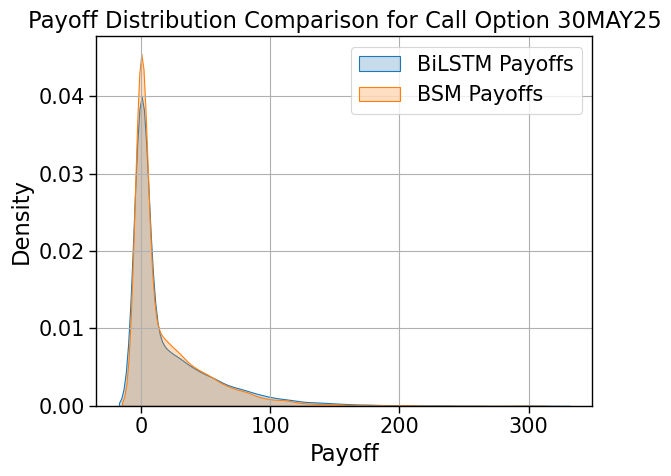

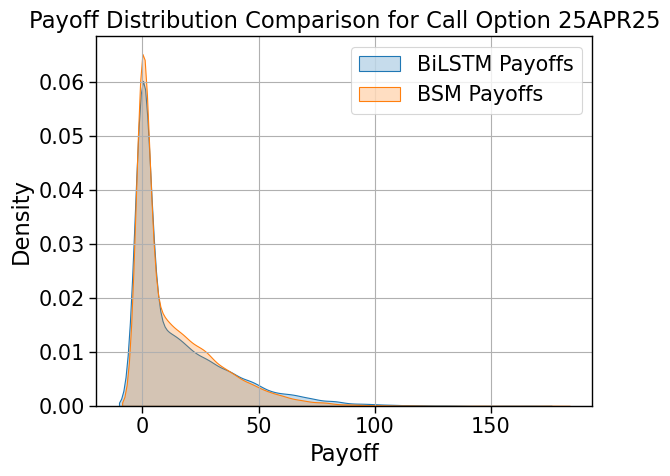

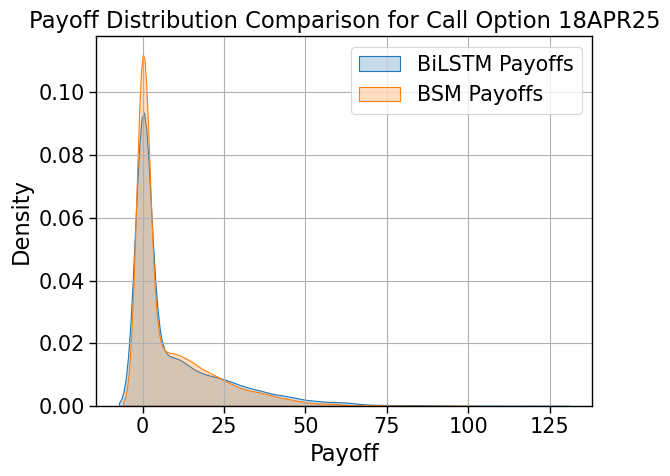

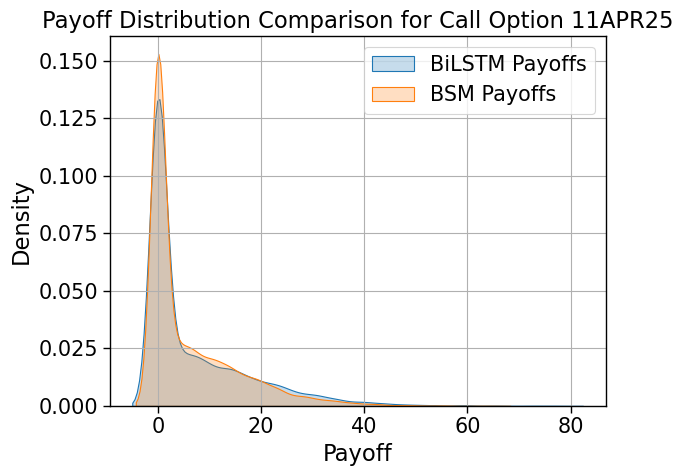

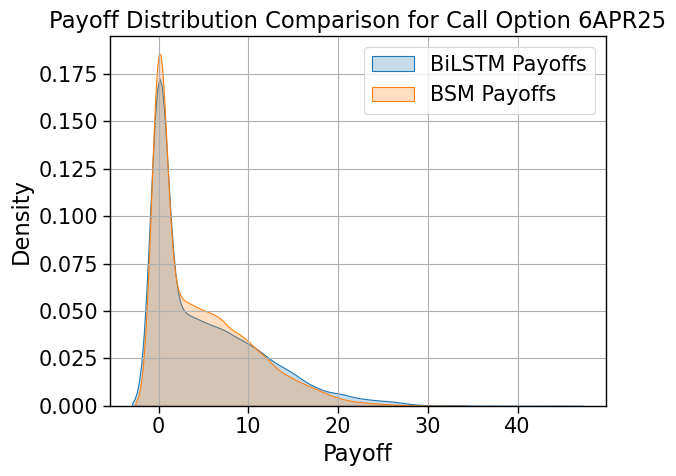

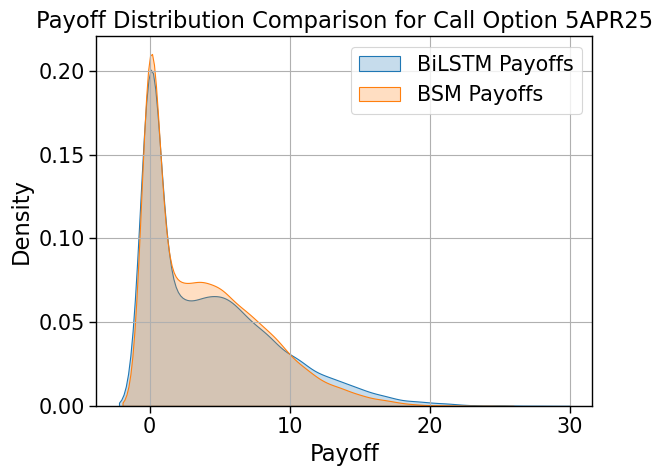

In [ ]:
# BSM Calls Payoffs Monte Carlo Simulation
bsm_call_payoffs = np.zeros((len(calls), num_simulations))
for i in range(len(calls)):
    bsm_call_payoffs[i] = monte_carlo_simulation(S, calls.iloc[i]['Strike'], calls.iloc[i]['expiration']/360, r, sigmas['Monthly'], num_simulations, call_option=True)

# BiLSTM Calls Payoffs Monte Carlo Simulation
bilstm_call_payoffs = np.zeros((len(calls), num_simulations))
for i in range(len(calls)):
    bilstm_call_payoffs[i] = monte_carlo_simulation(S, calls.iloc[i]['Strike'], calls.iloc[i]['expiration']/360, r, annualized_volatility_prediction, num_simulations, call_option=True)

# Plot comparisons for calls
for i in range(len(calls)):
    plot_payoffs_comparison(bilstm_call_payoffs[i], bsm_call_payoffs[i], "Call", 'BiLSTM', calls['Maturity'].iloc[i])

From the plots, we can see the BSM model, using historical volatility, yields a payoff distribution with a narrower spread, concentrating most outcomes around zero or moderate gains, reflecting its assumption of constant volatility and resulting in a more predictable but constrained payoff profile. In contrast, the BiLSTM-enhanced BSM model, leveraging predicted volatility, produces a distribution with a heavier right tail, indicating a higher likelihood of larger gains, as the model captures dynamic volatility patterns in SOL’s price movements, leading to more extreme payoff scenarios. This is especially visible on shorter maturities, where the scale of payoffs is smaller.

This comparison reveals that the BiLSTM approach introduces greater variability in call option payoffs, offering the potential for higher returns in volatile scenarios, which could appeal to investors seeking to capitalize on SOL’s price swings. The standard BSM model’s tighter distribution suggests a more conservative strategy, potentially underestimating volatility in cryptocurrencies, where the BiLSTM’s ability to adapt to changing market conditions provides a more realistic reflection of possible outcomes.

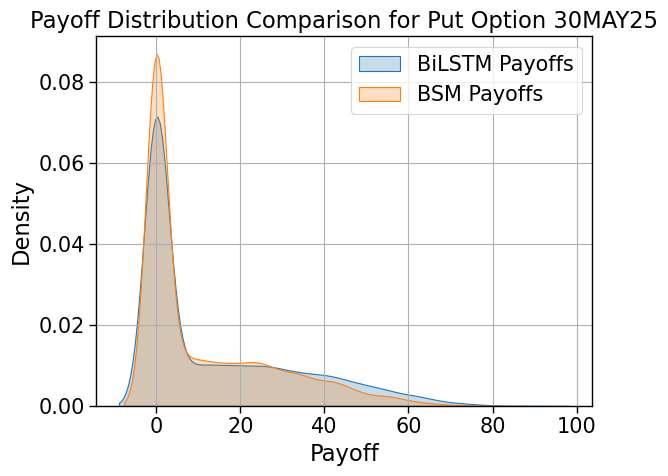

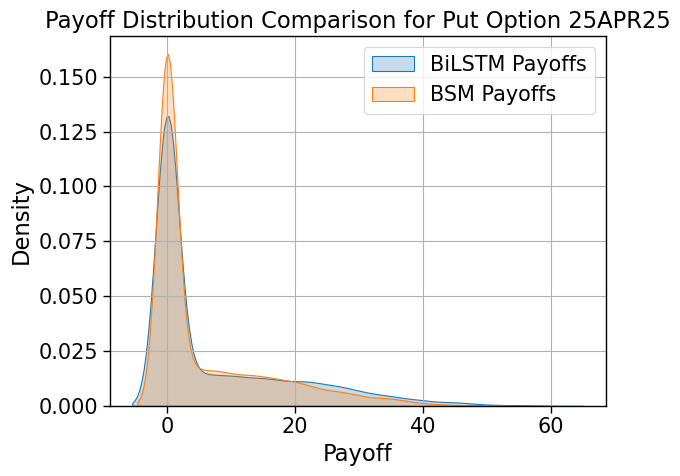

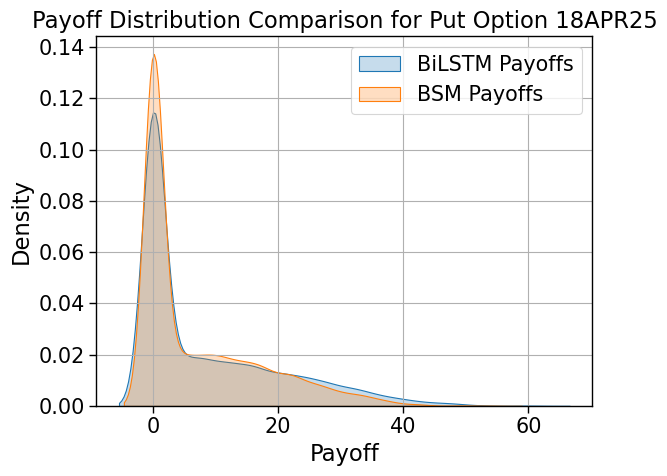

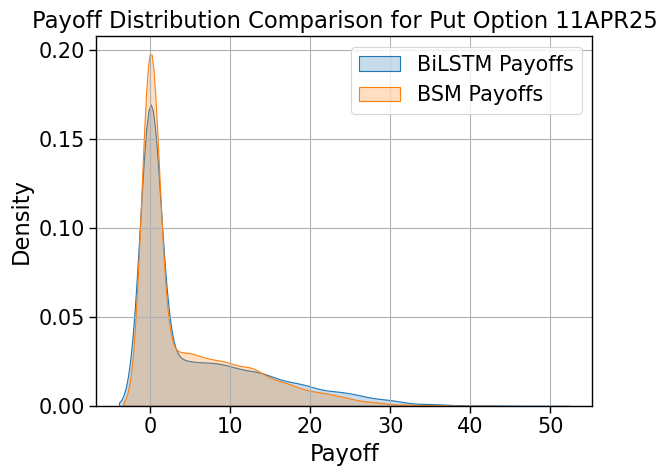

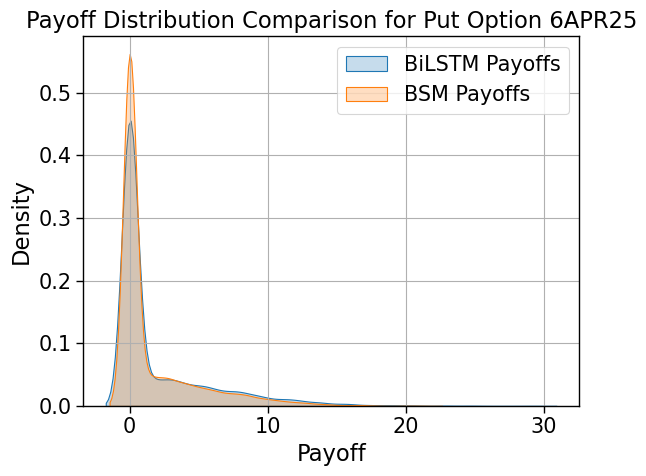

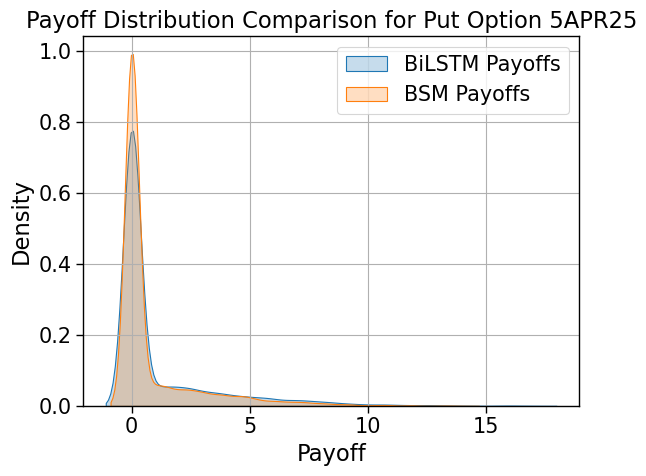

In [ ]:
# BSM Puts Payoffs Monte Carlo Simulation
bsm_put_payoffs = np.zeros((len(puts), num_simulations))
for i in range(len(puts)):
    bsm_put_payoffs[i] = monte_carlo_simulation(S, puts.iloc[i]['Strike'], puts.iloc[i]['expiration']/360, r, sigmas['Monthly'], num_simulations, call_option=False)

# BiLSTM Puts Payoffs Monte Carlo Simulation
bilstm_put_payoffs = np.zeros((len(puts), num_simulations))
for i in range(len(puts)):
    bilstm_put_payoffs[i] = monte_carlo_simulation(S, puts.iloc[i]['Strike'], puts.iloc[i]['expiration']/360, r, annualized_volatility_prediction, num_simulations, call_option=False)

# Plot comparisons for puts
for i in range(len(puts)):
    plot_payoffs_comparison(bilstm_put_payoffs[i], bsm_put_payoffs[i], "Put", 'BiLSTM', puts['Maturity'].iloc[i])

For Puts, despite most of the analysis being similar - BSM predicting more scenarios with no payoff and BiLSTM having a larger density on the right tail - the effect of maturity is reversed, and the longer we are from maturity, the clearer differences get. It is also interesting to note the density of 0 payoff scenarios is much larger than those of call options, and this is especially true in our daily options, likely indicating an upward trend in SOL price that would put most put options Out-of-the-Money.

#### d) Calculate or estimate the Greeks and compare to an approach that uses the BSM model/assumptions

In [ ]:
# Create a function to calculate BSM parameters
def bsm_parameters(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

# BSM Greeks functions
def bsm_greeks(option_type, S0, K, T, r, sigma):
    # Get Parameters
    d1, d2 = bsm_parameters(S0, K, T, r, sigma)

    # Delta
    if option_type == 'call':
        delta = norm.cdf(d1)
    else:  # put
        delta = norm.cdf(d1) - 1

    # Gamma
    gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))

    # Theta (Daily)
    if option_type == 'call':
        theta = (-(S0 * sigma * norm.pdf(d1)) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)) / 360  # daily theta
    else:  # put
        theta = (-(S0 * sigma * norm.pdf(d1)) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)) / 360  # daily theta

    # Vega
    vega = S0 * norm.pdf(d1) * np.sqrt(T)

    # Rho
    if option_type == 'call':
        rho = K * T * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

    return delta, gamma, theta, vega / 100, rho / 100   # / 100 to match yfinance's format

In [ ]:
# BSM Calls
bsm_call_greeks = np.zeros((len(calls), 5))  # 5 Greeks
for i in range(len(calls)):
    bsm_call_greeks[i] = bsm_greeks('call', S, calls.iloc[i]['Strike'], calls.iloc[i]['expiration']/360, r, sigmas['Monthly'])

# BSM Puts
bsm_put_greeks = np.zeros((len(puts), 5))
for i in range(len(puts)):
    bsm_put_greeks[i] = bsm_greeks('put', S, puts.iloc[i]['Strike'], puts.iloc[i]['expiration']/360, r, sigmas['Monthly'])

# BiLSTM Calls
bilstm_call_greeks = np.zeros((len(calls), 5))
for i in range(len(calls)):
    bilstm_call_greeks[i] = bsm_greeks('call', S, calls.iloc[i]['Strike'], calls.iloc[i]['expiration']/360, r, annualized_volatility_prediction)

# BiLSTM Puts
bilstm_put_greeks = np.zeros((len(puts), 5))
for i in range(len(puts)):
    bilstm_put_greeks[i] = bsm_greeks('put', S, puts.iloc[i]['Strike'], puts.iloc[i]['expiration']/360, r, annualized_volatility_prediction)

#### e) What do you find? How do results compare to the market and to BSM? Can you draw any insights?

The “Greeks” measure the sensitivity of an option’s price to various factors:

- Delta (Δ): Sensitivity to the underlying price (𝑆).
- Gamma (Γ): Sensitivity of Delta to changes in the underlying price.
- Theta (Θ): Sensitivity to the passage of time (time decay).
- Vega (𝜈): Sensitivity to changes in implied volatility (𝜎).
- Rho (𝜌): Sensitivity to changes in the risk-free interest rate (𝑟).

In [ ]:
# Extract and rename market Greeks from the 'calls' DataFrame
market_call_greeks = calls[['Maturity Date', 'Δ|Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy()
market_call_greeks.columns = ['Maturity Date', 'Market_Delta', 'Market_Gamma', 'Market_Theta', 'Market_Vega', 'Market_Rho']
market_call_greeks.index = calls['Maturity Date']

# Create DataFrames for BSM and Your Greeks from the arrays
bsm_call_greeks = pd.DataFrame(bsm_call_greeks, columns=['BSM_Delta', 'BSM_Gamma', 'BSM_Theta', 'BSM_Vega', 'BSM_Rho'], index=calls['Maturity Date'])
bilstm_call_greeks = pd.DataFrame(bilstm_call_greeks, columns=['BiLSTM_Delta', 'BiLSTM_Gamma', 'BiLSTM_Theta', 'BiLSTM_Vega', 'BiLSTM_Rho'], index=calls['Maturity Date'])

# Concatenate all DataFrames into one comprehensive table
comparison_df = pd.concat([market_call_greeks, bsm_call_greeks, bilstm_call_greeks], axis=1)

# Define the list of Greeks and calculate differences
greeks = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
for greek in greeks:
    comparison_df[f'BiLSTM_Minus_Market_{greek}'] = comparison_df[f'BiLSTM_{greek}'] - comparison_df[f'Market_{greek}']
    comparison_df[f'BiLSTM_Minus_BSM_{greek}'] = comparison_df[f'BiLSTM_{greek}'] - comparison_df[f'BSM_{greek}']
    comparison_df[f'BSM_Minus_Market_{greek}'] = comparison_df[f'BSM_{greek}'] - comparison_df[f'Market_{greek}']

# Round the values for better readability
comparison_df = comparison_df.round(4)

# Display the comparison tables for each Greek
for greek in greeks:
    columns = [
        f'Market_{greek}', f'BSM_{greek}', f'BiLSTM_{greek}',
        f'BiLSTM_Minus_Market_{greek}', f'BiLSTM_Minus_BSM_{greek}', f'BSM_Minus_Market_{greek}'
    ]
    print(f"\nComparison Table for Calls {greek}:")
    print(comparison_df[columns])
    print("\n" + "-"*75)


Comparison Table for Calls Delta:
               Market_Delta  BSM_Delta  BiLSTM_Delta  \
Maturity Date                                          
2025-05-30           0.6267     0.6455        0.6447   
2025-04-25           0.6335     0.6628        0.6527   
2025-04-18           0.5352     0.5587        0.5604   
2025-04-11           0.5254     0.5570        0.5561   
2025-04-06           0.6012     0.6766        0.6573   
2025-04-05           0.6192     0.7334        0.7071   

               BiLSTM_Minus_Market_Delta  BiLSTM_Minus_BSM_Delta  \
Maturity Date                                                      
2025-05-30                        0.0180                 -0.0008   
2025-04-25                        0.0192                 -0.0101   
2025-04-18                        0.0251                  0.0017   
2025-04-11                        0.0306                 -0.0009   
2025-04-06                        0.0560                 -0.0193   
2025-04-05                        0.0879

For call options, the tables show that both models generally align with market values. BSM consistently overestimates the greeks relative to the market, especially for shorter maturities for Delta, Gamma and Theta, and for longer maturities in the case of Rho, while the BiLSTM approach brings these values slightly closer to market levels, demonstrating smaller deviations, as it correclty underestimates all greeks but Vega when compared to BSM, showing better alignment with market greeks, indicating a more adaptive response to volatility dynamics across different timeframes.

This analysis suggests that the BiLSTM-enhanced BSM model captures market risk sensitivities more accurately, due to its ability to forecast volatility dynamically, whereas BSM’s static volatility assumption leads to overestimations that could misguide option pricing or hedging decisions. The closer alignment of BiLSTM to market Greeks points to potential market inefficiencies or unmodeled factors like sentiment affecting traded prices, offering opportunities to refine pricing strategies, though its slight overestimations highlight areas for further model improvement. These findings underscore the limitations of BSM in volatile markets like cryptocurrencies and the value of integrating machine learning for better volatility prediction, encouraging a deeper investigation into market dynamics or model adjustments.

In [ ]:
# Extract and rename market Greeks from the 'puts' DataFrame
market_put_greeks = puts[['Maturity Date', 'Δ|Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy()
market_put_greeks.columns = ['Maturity Date', 'Market_Delta', 'Market_Gamma', 'Market_Theta', 'Market_Vega', 'Market_Rho']
market_put_greeks.index = puts['Maturity Date']

# Create DataFrames for BSM and Your Greeks from the arrays
bsm_put_greeks = pd.DataFrame(bsm_put_greeks, columns=['BSM_Delta', 'BSM_Gamma', 'BSM_Theta', 'BSM_Vega', 'BSM_Rho'], index=puts['Maturity Date'])
bilstm_put_greeks = pd.DataFrame(bilstm_put_greeks, columns=['BiLSTM_Delta', 'BiLSTM_Gamma', 'BiLSTM_Theta', 'BiLSTM_Vega', 'BiLSTM_Rho'], index=puts['Maturity Date'])

# Concatenate all DataFrames into one comprehensive table
comparison_df = pd.concat([market_put_greeks, bsm_put_greeks, bilstm_put_greeks], axis=1)

# Define the list of Greeks and calculate differences
greeks = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
for greek in greeks:
    comparison_df[f'BiLSTM_Minus_Market_{greek}'] = comparison_df[f'BiLSTM_{greek}'] - comparison_df[f'Market_{greek}']
    comparison_df[f'BiLSTM_Minus_BSM_{greek}'] = comparison_df[f'BiLSTM_{greek}'] - comparison_df[f'BSM_{greek}']
    comparison_df[f'BSM_Minus_Market_{greek}'] = comparison_df[f'BSM_{greek}'] - comparison_df[f'Market_{greek}']

# Round the values for better readability
comparison_df = comparison_df.round(4)

# Display the comparison tables for each Greek
for greek in greeks:
    columns = [
        f'Market_{greek}', f'BSM_{greek}', f'BiLSTM_{greek}',
        f'BiLSTM_Minus_Market_{greek}', f'BiLSTM_Minus_BSM_{greek}', f'BSM_Minus_Market_{greek}'
    ]
    print(f"\nComparison Table for Puts {greek}:")
    print(comparison_df[columns])
    print("\n" + "-"*75)


Comparison Table for Puts Delta:
               Market_Delta  BSM_Delta  BiLSTM_Delta  \
Maturity Date                                          
2025-05-30          -0.3733    -0.3545       -0.3553   
2025-04-25          -0.3664    -0.3372       -0.3473   
2025-04-18          -0.4648    -0.4413       -0.4396   
2025-04-11          -0.4746    -0.4430       -0.4439   
2025-04-06          -0.3988    -0.3234       -0.3427   
2025-04-05          -0.3808    -0.2666       -0.2929   

               BiLSTM_Minus_Market_Delta  BiLSTM_Minus_BSM_Delta  \
Maturity Date                                                      
2025-05-30                        0.0180                 -0.0008   
2025-04-25                        0.0192                 -0.0101   
2025-04-18                        0.0251                  0.0017   
2025-04-11                        0.0306                 -0.0009   
2025-04-06                        0.0560                 -0.0193   
2025-04-05                        0.0879 

From the table, we observe that the patterns are largely similar but not identical. For both puts and calls, the BiLSTM-enhanced BSM model generally aligns more closely with market values than the standard BSM model, particularly for Delta and Theta, where BSM tends to overestimate relative to the market, especially for shorter maturities. Additionally, BiLSTM correclty underestimates Gamma and Theta compared to BSM, and the differences in Vega and Rho remain small across all maturities, suggesting a structural consistency in how these models handle volatility and interest rate sensitivities for both option types.

Interestingly, most differences apart from Theta remained constant between Call and Put options. This is generally expected due to the structural properties of the BSM framework and the market dynamics of volatile assets like cryptocurrencies. The BSM model assumes symmetry in volatility and underlying price dynamics for puts and calls, leading to consistent differences in Greeks like Delta and Gamma, which are primarily driven by price sensitivity and convexity, and Vega and Rho, which depend on volatility and interest rates that are identical for both option types. However, Theta, which measures time decay, exhibits greater variation because puts and calls experience different time decay profiles in practice, especially in markets with asymmetric risk perceptions - puts may face higher demand due to downside protection needs, causing market Theta to diverge more noticeably from model predictions.

These findings indicate that market pricing for puts may embed additional risk premiums or behavioral factors not accounted for by BSM, offering opportunities to refine hedging or trading approaches, particularly in managing downside exposure in turbulent markets.

#### Alternative Model 2

#### a) Explain your approach and the theoretical advantages over Black-Scholes-Merton and why it is more appropriate for cryptocurrency.

**Black-Scholes-Merton (BSM) Model**

The BSM model is an option pricing framework that relies on simplifying assumptions:
- **Constant volatility:** the model assumes that the volatility of the underlying asset remains fixed throughout the option's life.
- **Normally distributed returns:** asset returns are assumed to be normally distributed.

While this allows for an analytical solution, in the real world these assumptions do not hold, especially in the case of cryptocurrencies. Two major empirical violations are:
- **Stochastic volatility:** in pratice, volatility is not constant, it clusters and varies over time.
- **Non-normal returns:** financial returns, and crypto in particular, often show fat tails and skewness, violating the normality assumption.

As a result, BSM often underestimates the price of deep in/out-of-the-money options and misrepresents risk in turbulent markets.

**Heston-Nandi GARCH Model**

To address the shortcoming of the BSM model, we adopt the Heston-Nandi GARCH(1,1) framework, a discrete-time model combining GARCH volatility dynamics with a closed-form solution for European Options (the option pricing is not a closed-form solution) .

Advantages over BSM:
- **Time-varying (conditional) volatility:** HN-GARCH model captures volatility clustering and persistence by allowing today's volatility to depend on past squared returns and past volatility.
- **Leverage effect:** it models the empirically observed asymmetry where negative shocks increase future volatility more than positive ones (common in crypto markets).
- **Fat tails and skewness:** even though returns are conditionally normal, the resulting unconditional distribution exhibits excess kurtosis and skewness due to the GARCH structure.
- **Empirical realism:** these features make the model more accurate in pricing options in assets with high volatility and non-normal return distributions - both of which are a caracteristic of crytocurrencies.

**Cryptocurrencies suitability**

Crypto is known for their extreme volatility and market shocks and HN-GARCH model is well suited for this:
- It dinamically adjusts to changing volatility, reflecting the fast-moving and speculative nature of crypto markets.
- It captures asymmetric responses to shocks, which are common due to speculative bubbles, regulatory news, etc.

#### b) Fit the model(s) and compare your pricing results, how do they compare to the previously calculated values in questions 1?

###### Risk Free Rate

To obtain the appropriate risk-free rate for the Black-Scholes-Merton pricing model, the **Nelson-Siegel-Svensson (NSS)** model was used to fit the U.S. Treasury yield curve as of **02/05/2025**.

The data was sourced from the official **U.S. Daily Treasury Par Yield Curve Rates**, available at:  
https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics?data=yield%27

The NSS model was calibrated using an **Ordinary Least Squares (OLS)** approach to ensure a smooth and continuous term structure. Once fitted, the model allows for extracting the **exact risk-free rate corresponding to any specific maturity** (e.g., the time to expiration of an option).

In [ ]:
# Import (excel only contains 04/04 date) -  columns deleted before importing
treasury_rates = pd.read_excel("C:/Users/20241560/Desktop/Financial Derivatives/Group Project/daily-treasury-rates.xls")

# Drop N/A in Date
treasury_rates.dropna(subset=['Date'], inplace=True)

# Function to convert the column names into years
def convert_to_years(col):
    col = str(col).replace(' ', '')  # remove all spaces

    if 'Mo' in col or 'Month' in col:
        number = col.replace('Month', '').replace('Mo', '')
        return float(number) / 12

    elif 'Yr' in col:
        number = col.replace('Yr', '')
        return int(number)

    return col

# Apply it
treasury_rates.columns = treasury_rates.columns.map(convert_to_years)

# Drop Date column
treasury_rates.drop(['Date'], inplace=True, axis=1)

treasury_rates

0.083333  0.125  0.166667  0.25  0.333333   0.5     1     2     3     5  \
0      4.36   4.35      4.36  4.28      4.25  4.14  3.86  3.68  3.66  3.72   

      7    10    20    30  
0  3.84  4.01  4.44  4.41

In [ ]:
# Trasformation needed to calibrate
maturities = np.array(treasury_rates.columns, dtype=float)
yields = treasury_rates.iloc[0].values.astype(float)

# NSS model calibrate
curve_fit = calibrate_nss_ols(maturities,yields)
curve_fit

# Debug (needed to apply to dataframe)
curve = curve_fit[0]

In [ ]:
# Predicted yields from the curve
yields_predicted = curve(maturities)

# Error metrics
errors = yields_predicted - yields
mae = np.mean(np.abs(errors))         # Mean Absolute Error
rmse = np.sqrt(np.mean(errors**2))    # Root Mean Squared Error

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.02214717768841704
Root Mean Squared Error (RMSE): 0.02526244427510026


These values are both well below 5 basis points (0.05), indicating that the fitted NSS curve closely tracks the observed market yields

The NSS model with OLS calibration performs robustly in replicating the observed yield curve on this date.

###### Current Solana Price

In [ ]:
# Solana price
S = sol_data.iloc[-1]['Close']
S

117.75762939453125

###### Options data

In [ ]:
df_options.columns

Index(['Instrument', 'Volume', 'Open', 'ExtValue', 'Rho', 'Theta', 'Vega',
       'Gamma', 'Δ|Delta', 'Last', 'Size', 'Type', 'Strike', 'Bid', 'Ask',
       'Mark', 'IV Bid', 'IV Ask', 'Maturity', 'IV Mid', 'Maturity Date',
       'TTM', 'moneyness', 'expiration'],
      dtype='object')

In [ ]:
df_options[['Maturity Date', 'TTM', 'Strike', 'IV Mid']]

Maturity Date  TTM  Strike   IV Mid
0     2025-05-30   56   110.0  0.87855
1     2025-05-30   56   110.0  0.89615
2     2025-04-25   21   110.0  0.92745
3     2025-04-25   21   110.0  0.95600
4     2025-04-18   14   116.0  0.97155
5     2025-04-18   14   116.0  0.98230
6     2025-04-11    7   116.0  1.06680
7     2025-04-11    7   116.0  1.08820
8     2025-04-06    2   114.0  1.02295
9     2025-04-06    2   114.0  1.01815
10    2025-04-05    1   114.0  1.20155
11    2025-04-05    1   114.0  1.20685

In [ ]:
# Generate new DF to keep original information untouched
df_options_mod = df_options.copy()

# Define reference date
reference_date = datetime.strptime('04/04/2025', '%d/%m/%Y')

# Calculate Time to Maturity (years)
df_options_mod['Time to Maturity'] = df_options_mod['Maturity'].apply(
    lambda x: (datetime.strptime(x, '%d%b%y') - reference_date).days / 365
)

# Mid Price
df_options_mod['Mid Price'] = (df_options_mod['Bid'] + df_options_mod['Ask']) / 2

# Risk Free Rate / Daily Risk Free Rate
df_options_mod['Risk Free Rate'] = df_options_mod['Time to Maturity'].apply(curve) / 100
df_options_mod['Daily Risk Free Rate'] = df_options_mod['Risk Free Rate'] / 360

# Extract the volatility values from vol_df
weekly_vol = vol_df.loc[vol_df['Window'] == '7_day_vol', 'Annualized Volatility'].values[0]
monthly_vol = vol_df.loc[vol_df['Window'] == '30_day_vol', 'Annualized Volatility'].values[0]

# Define the new volatility assignment function
def assign_vol_simple(days):
    if days <= 7:
        return weekly_vol
    else:
        return monthly_vol
df_options_mod['Annualized Volatility'] = df_options_mod['TTM'].apply(assign_vol_simple)
df_options_mod['Daily Variance'] = (df_options_mod['Annualized Volatility'] ** 2) / 360

In [ ]:
df_options_mod[['Instrument', 'Strike', 'Maturity', 'Time to Maturity', 'TTM' , 'Last', 'IV Mid', 'Annualized Volatility', 'Daily Variance', 'Daily Risk Free Rate']]

Instrument  Strike Maturity  Time to Maturity  TTM  Last  \
0   SOL_USDC-30MAY25-110-C   110.0  30MAY25          0.153425   56  18.6   
1   SOL_USDC-30MAY25-110-P   110.0  30MAY25          0.153425   56  12.0   
2   SOL_USDC-25APR25-110-C   110.0  25APR25          0.057534   21  12.2   
3   SOL_USDC-25APR25-110-P   110.0  25APR25          0.057534   21   8.0   
4   SOL_USDC-18APR25-116-C   116.0  18APR25          0.038356   14   7.9   
5   SOL_USDC-18APR25-116-P   116.0  18APR25          0.038356   14   9.5   
6   SOL_USDC-11APR25-116-C   116.0  11APR25          0.019178    7   6.2   
7   SOL_USDC-11APR25-116-P   116.0  11APR25          0.019178    7   7.0   
8    SOL_USDC-6APR25-114-C   114.0   6APR25          0.005479    2   3.8   
9    SOL_USDC-6APR25-114-P   114.0   6APR25          0.005479    2   2.8   
10   SOL_USDC-5APR25-114-C   114.0   5APR25          0.002740    1   3.1   
11   SOL_USDC-5APR25-114-P   114.0   5APR25          0.002740    1   2.3   

     IV Mid  Annualized Volatility  Daily Variance  Daily Risk Free Rate  
0   0.87855               0.840197        0.001961              0.000121  
1   0.89615               0.840197        0.001961              0.000121  
2   0.92745               0.840197        0.001961              0.000123  
3   0.95600               0.840197        0.001961              0.000123  
4   0.97155               0.840197        0.001961              0.000123  
5   0.98230               0.840197        0.001961              0.000123  
6   1.06680               0.672228        0.001255              0.000124  
7   1.08820               0.672228        0.001255              0.000124  
8   1.02295               0.672228        0.001255              0.000124  
9   1.01815               0.672228        0.001255              0.000124  
10  1.20155               0.672228        0.001255              0.000124  
11  1.20685               0.672228        0.001255              0.000124

In [ ]:
# Filter for calls
df_calls = df_options_mod[df_options_mod['Type'] == 'call'].copy()

# Add BSM Pricing
calls = calls.copy()
df_calls['BSM Price'] = call_prices_bsm

# View
df_calls[['Instrument', 'Strike', 'Maturity', 'Time to Maturity', 'TTM' , 'Last', 'BSM Price', 'IV Mid', 'Annualized Volatility', 'Daily Variance', 'Daily Risk Free Rate']]

Instrument  Strike Maturity  Time to Maturity  TTM  Last  \
0   SOL_USDC-30MAY25-110-C   110.0  30MAY25          0.153425   56  18.6   
2   SOL_USDC-25APR25-110-C   110.0  25APR25          0.057534   21  12.2   
4   SOL_USDC-18APR25-116-C   116.0  18APR25          0.038356   14   7.9   
6   SOL_USDC-11APR25-116-C   116.0  11APR25          0.019178    7   6.2   
8    SOL_USDC-6APR25-114-C   114.0   6APR25          0.005479    2   3.8   
10   SOL_USDC-5APR25-114-C   114.0   5APR25          0.002740    1   3.1   

    BSM Price   IV Mid  Annualized Volatility  Daily Variance  \
0   20.472388  0.87855               0.840197        0.001961   
2   13.902070  0.92745               0.840197        0.001961   
4    9.402070  0.97155               0.840197        0.001961   
6    6.805000  1.06680               0.672228        0.001255   
8    4.825896  1.02295               0.672228        0.001255   
10   3.859096  1.20155               0.672228        0.001255   

    Daily Risk Free Rate  
0               0.000121  
2               0.000123  
4               0.000123  
6               0.000124  
8               0.000124  
10              0.000124

In [ ]:
# Filter for puts
df_puts = df_options_mod[df_options_mod['Type'] == 'put'].copy()

# Add BSM Pricing
puts = puts.copy()
df_puts['BSM Price'] = put_prices_bsm

# View
df_puts[['Instrument', 'Strike', 'Maturity', 'Time to Maturity', 'TTM' , 'Last', 'IV Mid', 'Annualized Volatility', 'Daily Variance', 'Daily Risk Free Rate']]

Instrument  Strike Maturity  Time to Maturity  TTM  Last  \
1   SOL_USDC-30MAY25-110-P   110.0  30MAY25          0.153425   56  12.0   
3   SOL_USDC-25APR25-110-P   110.0  25APR25          0.057534   21   8.0   
5   SOL_USDC-18APR25-116-P   116.0  18APR25          0.038356   14   9.5   
7   SOL_USDC-11APR25-116-P   116.0  11APR25          0.019178    7   7.0   
9    SOL_USDC-6APR25-114-P   114.0   6APR25          0.005479    2   2.8   
11   SOL_USDC-5APR25-114-P   114.0   5APR25          0.002740    1   2.3   

     IV Mid  Annualized Volatility  Daily Variance  Daily Risk Free Rate  
1   0.89615               0.840197        0.001961              0.000121  
3   0.95600               0.840197        0.001961              0.000123  
5   0.98230               0.840197        0.001961              0.000123  
7   1.08820               0.672228        0.001255              0.000124  
9   1.01815               0.672228        0.001255              0.000124  
11  1.20685               0.672228        0.001255              0.000124

###### HN-GARCH Pricing

In [ ]:
# Using demeaed log returns
# -> however, HN-GARCH has a drift/mean return term, using it like this will undermine this term
log_returns = ln_r - ln_r.mean()

# Get the closest row to 30 days maturity
target_days = 30
idx = (df_puts['TTM'] - target_days).abs().idxmin()
closest_row = df_puts.loc[idx]
closest_T = closest_row['Time to Maturity']
print(closest_T)

# Apply the curve function to get daily interest rate
daily_r = (curve(closest_T) / 100) / 360  # convert from % to decimal and convert to daily
daily_r

0.057534246575342465


0.00012265152598141493

In [ ]:
def hn_garch_log_likelihood(params, returns, daily_r):
    """
    Computes the negative log-likelihood for the Heston-Nandi GARCH(1,1) model.

    Parameters:
    - params: array-like, contains [lambda, omega, beta, alpha, gamma]
      - omega: long-run variance
      - gamma: leverage effect
      - lambda: risk-premium sensitivity
      - beta: persistance of volatility (correlation)
      - alpha: reaction to shocks/ volatility clustering
    - log_returns: demeaned return series (preferably log-returns)
    - daily_r: daily risk-free rate (for risk-neutral adjustment)

    Returns:
    - Negative log-likelihood (for minimization)
    """
    lam, omega, beta, alpha, gamma = params
    T = len(returns)

    # Initialize conditional variance series
    h = np.zeros(T)
    h[0] = np.var(returns)  # Initial variance guess

    log_likelihood = 0.0

    for t in range(1, T):
        # Compute z_{t-1} under physical measure
        z_t = (log_returns.iloc[t-1] - daily_r - lam * h[t-1]) / np.sqrt(h[t-1])

        # Update conditional variance h_t
        h[t] = omega + beta * h[t-1] + alpha * (z_t - gamma * np.sqrt(h[t-1]))**2

        # Prevent negative or zero variance (numerical stability)
        if h[t] <= 1e-8:
            h[t] = 1e-8

        # Log-likelihood contribution at time t (under assumption of normality)
        residual = log_returns[t] - daily_r - lam * h[t]
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(h[t]) + (residual**2) / h[t])

    return -log_likelihood  # Negative for use with minimizers

In [ ]:
initial_params = np.array([0.1, 0.01, 0.9, 0.05, 0.1])  # lambda, omega, beta, alpha, gamma
bounds = [(-np.inf, np.inf), (0, None), (0, 1), (0, None), (-np.inf, np.inf)]

result = minimize(hn_garch_log_likelihood, initial_params,
                  args=(log_returns, daily_r),
                  method='L-BFGS-B',
                  bounds=bounds)

print("Success:", result.success)
print("Log-likelihood:", -result.fun)

fitted_params = result.x

Success: True
Log-likelihood: 760.878409445761


In [ ]:
print("Fitted Parameters:")
print("lambda: {:.4f}".format(fitted_params[0]))
print("omega: {:.4f}".format(fitted_params[1]))
print("beta: {:.4f}".format(fitted_params[2]))
print("alpha: {:.4f}".format(fitted_params[3]))
print("gamma: {:.4f}".format(fitted_params[4]))

Fitted Parameters:
lambda: 0.1324
omega: 0.0000
beta: 0.1599
alpha: 0.0005
gamma: 0.1292


In [ ]:
num_simulations = 10000

# HN-GARCG Pricing & Payoff Montecarlo Simulation
def hn_garch_monte_carlo_simulation(params, S0, K, v_start, r_daily, T, num_simulations, call=True):
    lam, omega, beta, alpha, gamma = params

    steps = max(1, int(T * 360))
    dt = T / steps
    discount_factor = np.exp(-r_daily * steps)

    payoffs = np.zeros(num_simulations)

    for i in range(num_simulations):
        v = v_start
        lnS = np.log(S0)

        for _ in range(steps):
            z = np.random.normal()
            v = max(1e-8, omega + alpha * (z - gamma * np.sqrt(v))**2 + beta * v)
            lnS += r_daily - lam * v - 0.5 * v + z * np.sqrt(v)

        S_T = np.exp(lnS)
        payoff = max(S_T - K, 0) if call else max(K - S_T, 0)
        payoffs[i] = payoff

    price = discount_factor * np.mean(payoffs)

    return price, payoffs

In [ ]:
# HN-GARCH Call Price
call_hn_prices = []

# HN Payoffs for later use
call_hn_payoffs = []

for _, row in df_calls.iterrows():
    price, payoffs = hn_garch_monte_carlo_simulation(
        params=fitted_params,
        S0=S,
        K=row['Strike'],
        v_start=row['Daily Variance'],
        r_daily=row['Daily Risk Free Rate'],
        T=row['Time to Maturity'],
        num_simulations=num_simulations,
        call=True
    )
    call_hn_prices.append(price)
    call_hn_payoffs.append(payoffs)

df_calls['HN Price'] = call_hn_prices
df_calls['HN Payoffs'] = call_hn_payoffs


df_calls[['Strike', 'Maturity', 'TTM' , 'BSM Price', 'Mid Price', 'HN Price', 'Annualized Volatility', 'Daily Variance', 'Daily Risk Free Rate']]

Strike Maturity  TTM  BSM Price  Mid Price   HN Price  \
0    110.0  30MAY25   56  20.472388      18.50  18.861956   
2    110.0  25APR25   21  13.902070      13.15  13.179921   
4    116.0  18APR25   14   9.402070       8.65   7.550559   
6    116.0  11APR25    7   6.805000       6.65   5.390260   
8    114.0   6APR25    2   4.825896       4.30   4.317391   
10   114.0   5APR25    1   3.859096       3.65   4.242607   

    Annualized Volatility  Daily Variance  Daily Risk Free Rate  
0                0.840197        0.001961              0.000121  
2                0.840197        0.001961              0.000123  
4                0.840197        0.001961              0.000123  
6                0.672228        0.001255              0.000124  
8                0.672228        0.001255              0.000124  
10               0.672228        0.001255              0.000124

In [ ]:
# BSM vs Mid Price
df_calls['Pct_Error_BSM_vs_Mid'] = ((df_calls['BSM Price'] - df_calls['Mid Price']) / df_calls['Mid Price']) * 100
df_calls['Pct_Error_BSM_vs_Mid'] = df_calls['Pct_Error_BSM_vs_Mid'].round(2)

# HN vs Mid Price
df_calls['Pct_Error_HN_vs_Mid'] = ((df_calls['HN Price'] - df_calls['Mid Price']) / df_calls['Mid Price']) * 100
df_calls['Pct_Error_HN_vs_Mid'] = df_calls['Pct_Error_HN_vs_Mid'].round(2)

# HN vs BSM
df_calls['Pct_Error_HN_vs_BSM'] = ((df_calls['HN Price'] - df_calls['BSM Price']) / df_calls['BSM Price']) * 100
df_calls['Pct_Error_HN_vs_BSM'] = df_calls['Pct_Error_HN_vs_BSM'].round(2)

# Print DF
print(df_calls[['Strike', 'TTM', 'BSM Price', 'Mid Price', 'HN Price', 'Pct_Error_BSM_vs_Mid', 'Pct_Error_HN_vs_Mid', 'Pct_Error_HN_vs_BSM']])
print()

# RMSE: BSM vs Market Mid Price
rmse_bsm = np.sqrt(mse(df_calls['Mid Price'], df_calls['BSM Price']))

# RMSE: HN vs Market Mid Price
rmse_hn = np.sqrt(mse(df_calls['Mid Price'], df_calls['HN Price']))

# RMSE: BSM vs HN
rmse_bsm_vs_hn = np.sqrt(mse(df_calls['BSM Price'], df_calls['HN Price']))

# Print
print(f"RMSE - Calls (BSM vs Mid Price): {rmse_bsm:.4f}")
print(f"RMSE - Calls (HN vs Mid Price): {rmse_hn:.4f}")
print(f"RMSE - Calls (BSM vs HN): {rmse_bsm_vs_hn:.4f}")

    Strike  TTM  BSM Price  Mid Price   HN Price  Pct_Error_BSM_vs_Mid  \
0    110.0   56  20.472388      18.50  18.861956                 10.66   
2    110.0   21  13.902070      13.15  13.179921                  5.72   
4    116.0   14   9.402070       8.65   7.550559                  8.69   
6    116.0    7   6.805000       6.65   5.390260                  2.33   
8    114.0    2   4.825896       4.30   4.317391                 12.23   
10   114.0    1   3.859096       3.65   4.242607                  5.73   

    Pct_Error_HN_vs_Mid  Pct_Error_HN_vs_BSM  
0                  1.96                -7.87  
2                  0.23                -5.19  
4                -12.71               -19.69  
6                -18.94               -20.79  
8                  0.40               -10.54  
10                16.24                 9.94  

RMSE - Calls (BSM vs Mid Price): 0.9457
RMSE - Calls (HN vs Mid Price): 0.7393
RMSE - Calls (BSM vs HN): 1.2214


The Heston-Nandi GARCH model exhibits mixed effectiveness in pricing call options. Although it achieves a slightly lower overall RMSE than the Black-Scholes-Merton (BSM) model, this marginal gain is not consistent across maturities. In fact, the BSM model significantly outperforms HN-GARCH at several short- and medium-term maturities, where HN-GARCH tends to underprice calls more severely.

While HN-GARCH theoretically accounts for time-varying volatility and asymmetric market responses, these features do not reliably enhance pricing performance in practice. The apparent RMSE improvement is largely concentrated in a few longer-dated options. However, its erratic performance at shorter horizons undermines the notion that HN-GARCH provides a more accurate or robust fit to market behavior.

In [ ]:
# HN-GARCH Put Price
put_hn_prices = []

# HN Payoffs for later use
put_hn_payoffs = []

for _, row in df_puts.iterrows():
    price, payoffs = hn_garch_monte_carlo_simulation(
        params=fitted_params,
        S0=S,
        K=row['Strike'],
        v_start=row['Daily Variance'],
        r_daily=row['Daily Risk Free Rate'],
        T=row['Time to Maturity'],
        num_simulations=num_simulations,
        call=False
    )
    put_hn_prices.append(price)
    put_hn_payoffs.append(payoffs)

df_puts['HN Price'] = put_hn_prices
df_puts['HN Payoffs'] = put_hn_payoffs


df_puts[['Strike', 'Maturity', 'TTM' , 'BSM Price', 'Mid Price', 'HN Price', 'Annualized Volatility', 'Daily Variance', 'Daily Risk Free Rate']]

Strike Maturity  TTM  BSM Price  Mid Price  HN Price  \
1    110.0  30MAY25   56  12.697159      12.95  8.505329   
3    110.0  25APR25   21   6.572406       7.60  4.221190   
5    116.0  18APR25   14   8.151979       8.90  5.294028   
7    116.0  11APR25    7   5.649189       6.90  3.276048   
9    114.0   6APR25    2   1.737939       2.45  0.531982   
11   114.0   5APR25    1   0.784390       1.80  0.514756   

    Annualized Volatility  Daily Variance  Daily Risk Free Rate  
1                0.840197        0.001961              0.000121  
3                0.840197        0.001961              0.000123  
5                0.840197        0.001961              0.000123  
7                0.672228        0.001255              0.000124  
9                0.672228        0.001255              0.000124  
11               0.672228        0.001255              0.000124

In [ ]:
# BSM vs Mid Price
df_puts['Pct_Error_BSM_vs_Mid'] = ((df_puts['BSM Price'] - df_puts['Mid Price']) / df_puts['Mid Price']) * 100
df_puts['Pct_Error_BSM_vs_Mid'] = df_puts['Pct_Error_BSM_vs_Mid'].round(2)

# HN vs Mid Price
df_puts['Pct_Error_HN_vs_Mid'] = ((df_puts['HN Price'] - df_puts['Mid Price']) / df_puts['Mid Price']) * 100
df_puts['Pct_Error_HN_vs_Mid'] = df_puts['Pct_Error_HN_vs_Mid'].round(2)

# HN vs BSM
df_puts['Pct_Error_HN_vs_BSM'] = ((df_puts['HN Price'] - df_puts['BSM Price']) / df_puts['BSM Price']) * 100
df_puts['Pct_Error_HN_vs_BSM'] = df_puts['Pct_Error_HN_vs_BSM'].round(2)

# Print DF
print(df_puts[['Strike', 'TTM', 'BSM Price', 'Mid Price', 'HN Price','Pct_Error_BSM_vs_Mid', 'Pct_Error_HN_vs_Mid', 'Pct_Error_HN_vs_BSM']])
print()

# RMSE: BSM vs Market Mid Price
rmse_bsm = np.sqrt(mse(df_puts['Mid Price'], df_puts['BSM Price']))

# RMSE: HN vs Market Mid Price
rmse_hn = np.sqrt(mse(df_puts['Mid Price'], df_puts['HN Price']))

# RMSE: BSM vs HN
rmse_bsm_vs_hn = np.sqrt(mse(df_puts['BSM Price'], df_puts['HN Price']))

# Print
print(f"RMSE — Puts (BSM vs Mid Price): {rmse_bsm:.4f}")
print(f"RMSE — Puts (HN vs Mid Price): {rmse_hn:.4f}")
print(f"RMSE — Puts (BSM vs HN): {rmse_bsm_vs_hn:.4f}")


    Strike  TTM  BSM Price  Mid Price  HN Price  Pct_Error_BSM_vs_Mid  \
1    110.0   56  12.697159      12.95  8.505329                 -1.95   
3    110.0   21   6.572406       7.60  4.221190                -13.52   
5    116.0   14   8.151979       8.90  5.294028                 -8.40   
7    116.0    7   5.649189       6.90  3.276048                -18.13   
9    114.0    2   1.737939       2.45  0.531982                -29.06   
11   114.0    1   0.784390       1.80  0.514756                -56.42   

    Pct_Error_HN_vs_Mid  Pct_Error_HN_vs_BSM  
1                -34.32               -33.01  
3                -44.46               -35.77  
5                -40.52               -35.06  
7                -52.52               -42.01  
9                -78.29               -69.39  
11               -71.40               -34.37  

RMSE — Puts (BSM vs Mid Price): 0.8928
RMSE — Puts (HN vs Mid Price): 3.2311
RMSE — Puts (BSM vs HN): 2.5307


After fitting the Black-Scholes-Merton (BSM) and Heston-Nandi GARCH (HN-GARCH) models to the put option data, we compared the model-generated prices to the actual market mid prices. As with the call options, the BSM model consistently delivers more accurate pricing than HN-GARCH across all maturities. The HN-GARCH model underprices the puts significantly, especially at shorter maturities, and unlike the call results, it does not outperform BSM even at the 1-day maturity.

The percentage errors show a consistent pattern: BSM underprices the market, but HN-GARCH underprices it even further. This is particularly pronounced at short maturities, where the HN-GARCH model's percentage error relative to the market exceeds 70% in some instances.

The RMSE results reinforce this underperformance: the RMSE of the HN-GARCH model is substantially higher than that of BSM, indicating that the magnitude of pricing errors is not only larger but also more volatile. This further supports the conclusion that the added complexity of the HN-GARCH model does not result in better pricing performance. Instead, it introduces significant deviations from observed market prices, likely due to estimation uncertainty or model miscalibration.

#### c) Use Monte Carlos Simulation to compare the distribution of potential payoffs between your approach and an approach that uses the BSM model/assumptions.

In [ ]:
num_simulations = 10000

def bsm_monte_carlo_payoff(S0, K, sigma, r, T, num_simulations, call=True):
    Z = np.random.normal(size=num_simulations)
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    if call:
        payoffs = np.maximum(S_T - K, 0)
    else:
        payoffs = np.maximum(K - S_T, 0)

    return payoffs

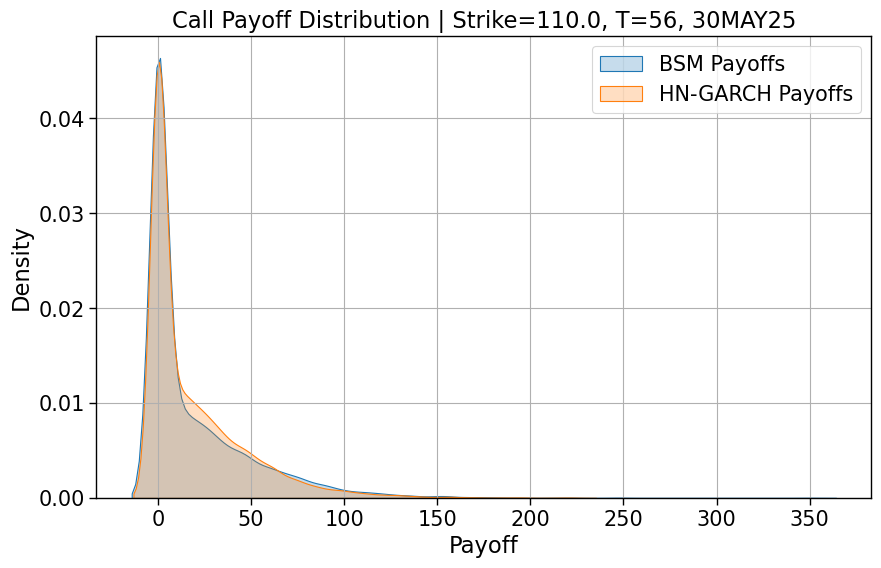

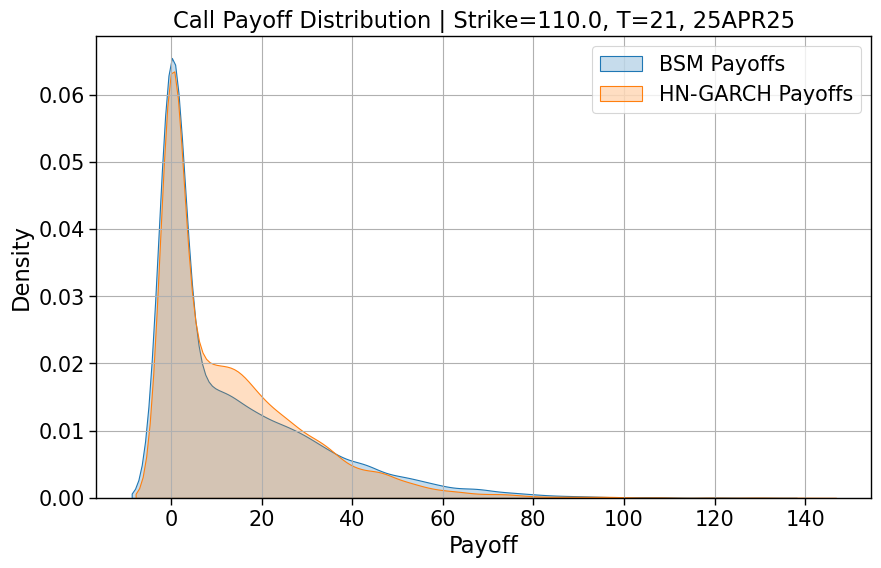

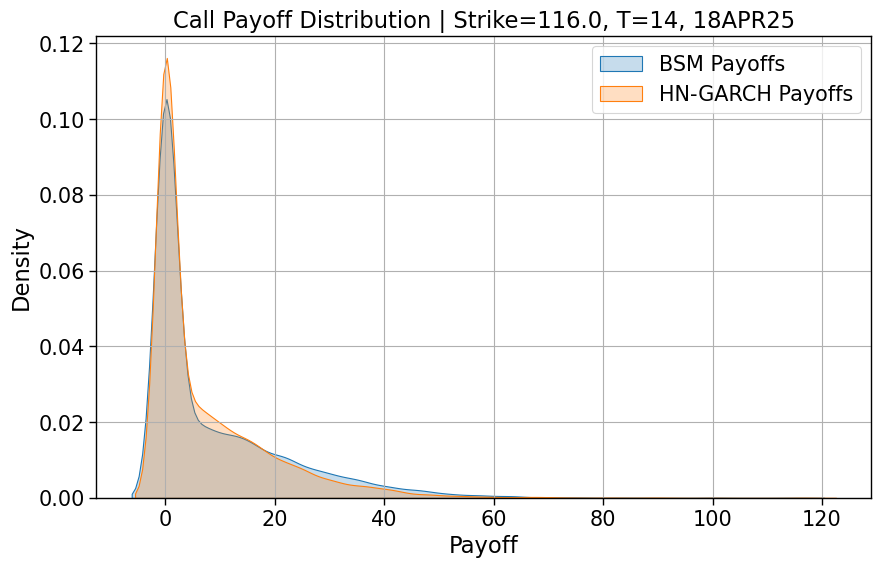

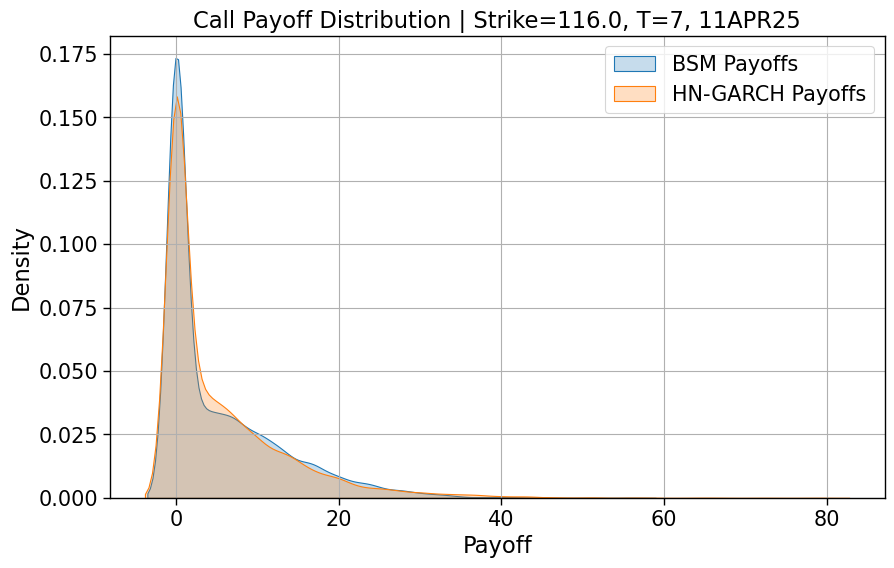

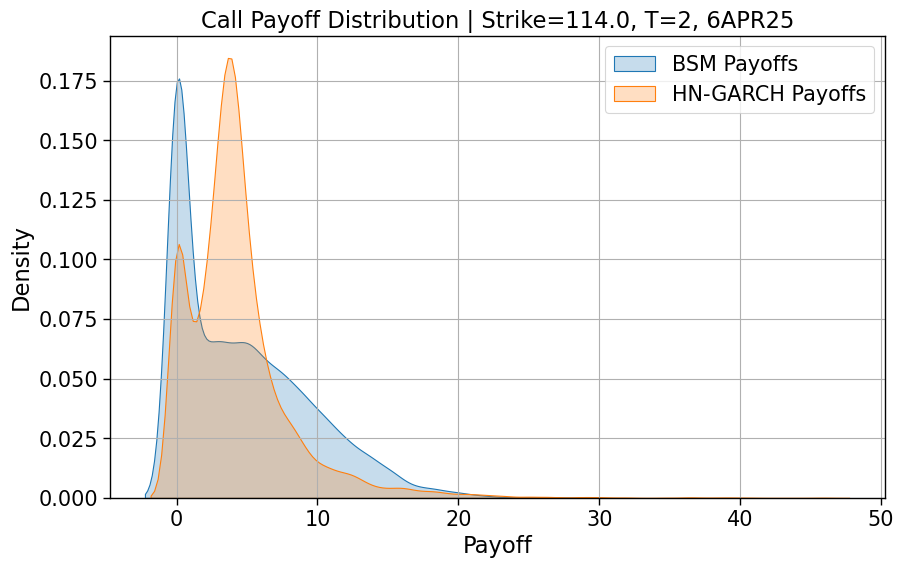

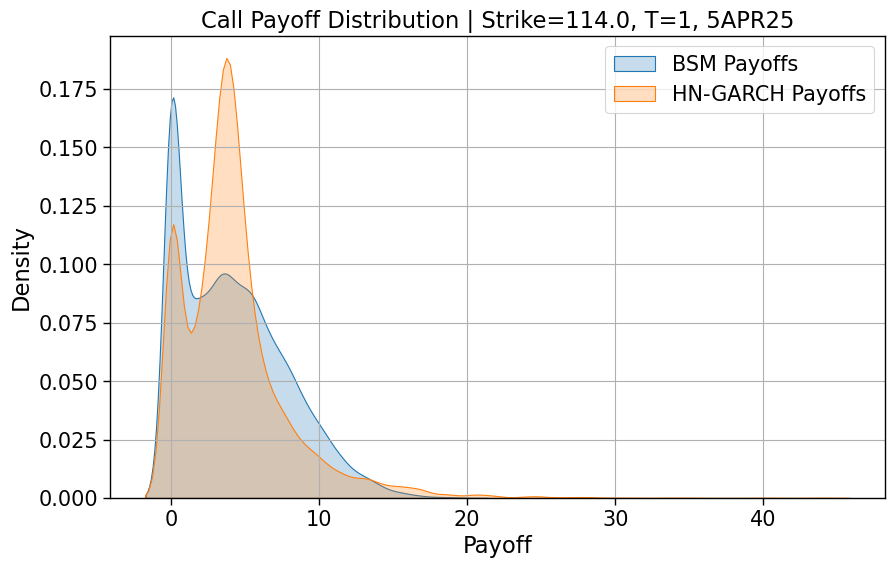

In [ ]:
# Calls
for i, row in df_calls.iterrows():
    K = row['Strike']
    T = row['Time to Maturity']
    sigma = row['Annualized Volatility']
    r = row['Daily Risk Free Rate']
    maturity_str = row['Maturity']  # Used for plot

    # BSM Payoffs
    bsm_payoffs = bsm_monte_carlo_payoff(
        S0=S,
        K=K,
        sigma=sigma,
        r=r,
        T=T,
        num_simulations=num_simulations,
        call=True
    )

    # Retrieve precomputed HN-GARCH payoffs
    hn_payoffs = row['HN Payoffs']

    # Plot distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(bsm_payoffs, label='BSM Payoffs', fill=True)
    sns.kdeplot(hn_payoffs, label='HN-GARCH Payoffs', fill=True)
    plt.title(f'Call Payoff Distribution | Strike={K}, T={int(T * 365)}, {maturity_str}')
    plt.xlabel('Payoff')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

It is clear from the plots that for longer maturities, the HN-GARCH and BSM payoff distributions are closely aligned, with only a slight edge in favor of HN-GARCH in the right tail. This suggests that for options with more time to expiry, both models agree on the distribution of outcomes, but HN-GARCH allows for slightly more upside potential, likely due to its ability to capture time-varying volatility.

However, at very short maturities (T = 1 and T = 2 days), the dynamics between the models become more complex. The HN-GARCH payoff distribution shifts away from zero, showing a **higher density around moderate positive payoffs** compared to BSM. This means that HN-GARCH assigns a **greater probability to the option finishing slightly in-the-money**, which is a significant departure from BSM’s shape, where the highest density remains at or near zero.

Interestingly, as the payoffs increase further into the right tail (e.g., deeper in-the-money scenarios), the BSM model starts to dominate again — showing more density than HN-GARCH in those extreme payoff regions. This suggests that while HN-GARCH expects some positive payoffs more frequently, it is more conservative about the magnitude of those payoffs. BSM, on the other hand, underestimates the frequency of moderate gains but allows for larger upside extremes in its distribution.

In conclusion, for very short-term calls, the HN-GARCH model shifts the payoff mass away from zero and toward moderate positive values, while BSM places more emphasis on either no payoff or larger rare events. This highlights a key behavioral difference: HN-GARCH anticipates smaller positive movements with higher confidence, while BSM allows for less frequent but larger upward jumps. These subtle shifts in density help explain the differences in pricing behavior at the short end of the maturity spectrum.

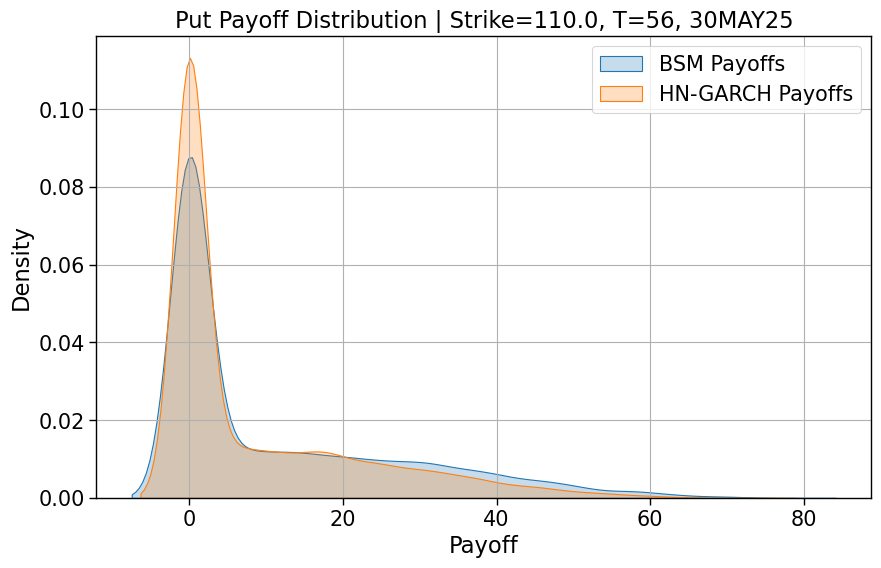

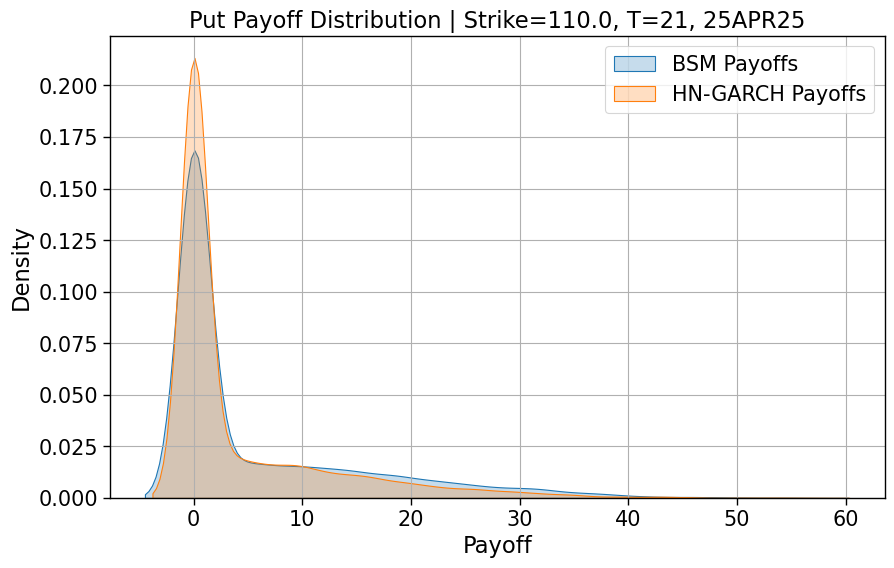

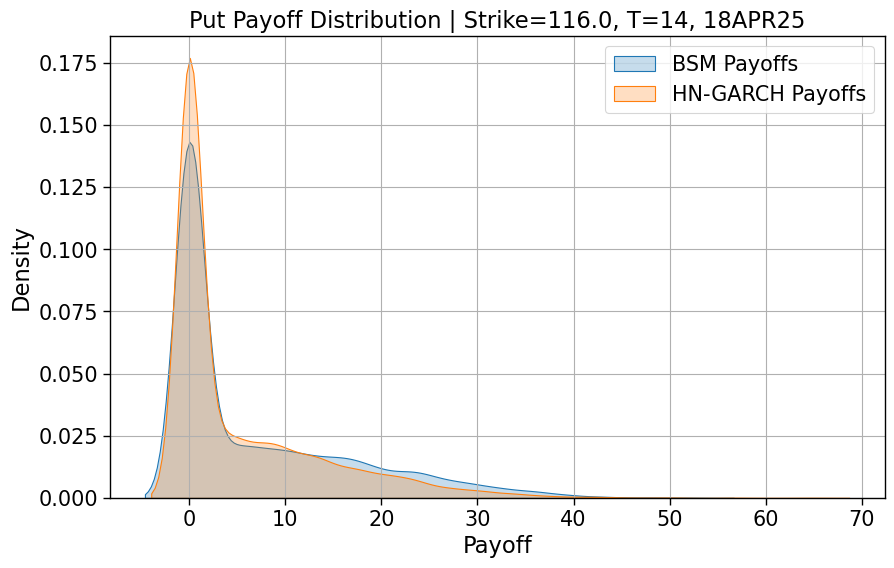

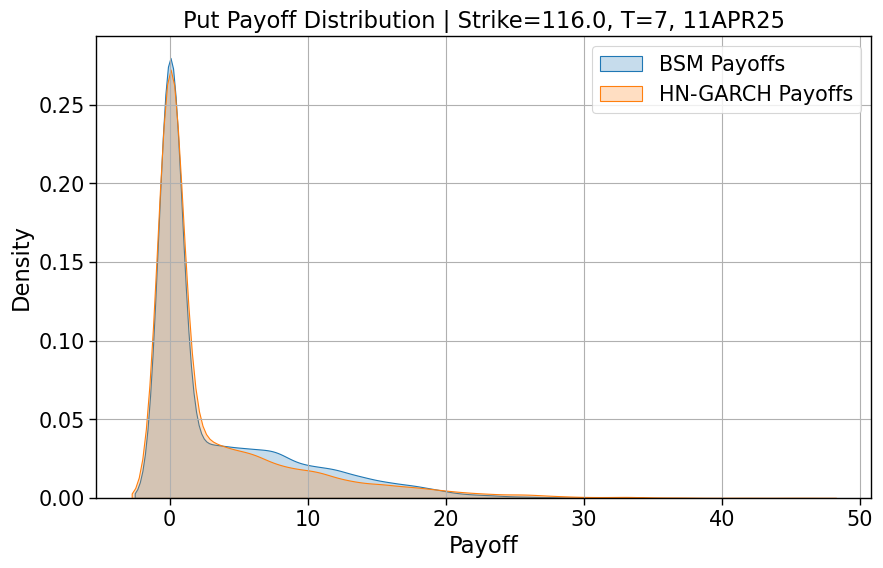

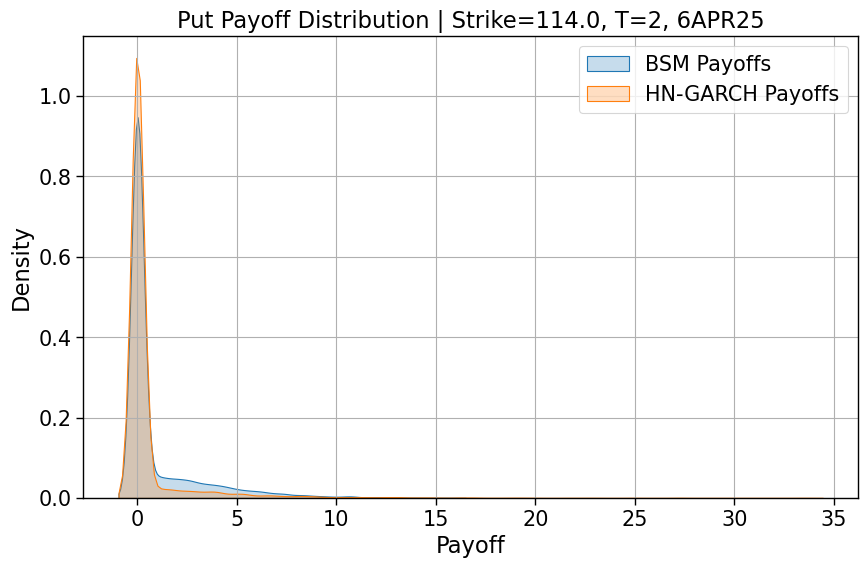

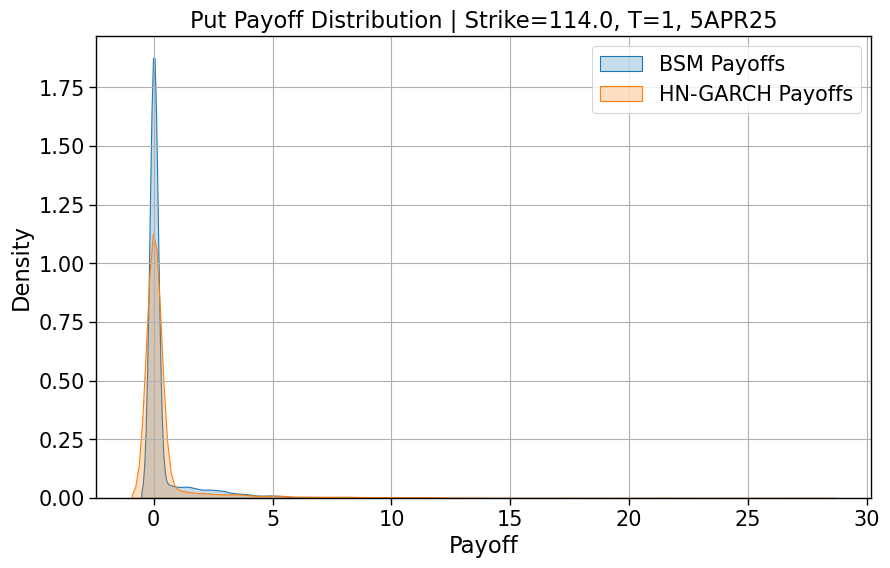

In [ ]:
# Puts
for i, row in df_puts.iterrows():
    K = row['Strike']
    T = row['Time to Maturity']
    sigma = row['Annualized Volatility']
    v_start = row['Daily Variance']
    r = row['Daily Risk Free Rate']
    maturity_str = row['Maturity']  # Used for plot

    # BSM Payoffs
    bsm_payoffs = bsm_monte_carlo_payoff(
        S0=S,
        K=K,
        sigma=sigma,
        r=r,
        T=T,
        num_simulations=num_simulations,
        call=False
    )

    # Retrieve precomputed HN-GARCH payoffs
    hn_payoffs = row['HN Payoffs']

    # Plot distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(bsm_payoffs, label='BSM Payoffs', fill=True)
    sns.kdeplot(hn_payoffs, label='HN-GARCH Payoffs', fill=True)
    plt.title(f'Put Payoff Distribution | Strike={K}, T={int(T * 365)}, {maturity_str}')
    plt.xlabel('Payoff')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

It is clear from the plots that the HN-GARCH payoff distributions are more concentrated around zero, as evidenced by the sharper and taller orange density curves near the origin in nearly all cases. This indicates that the HN-GARCH model is assigning greater probability to scenarios where the put option finishes out-of-the-money, resulting in zero payoff. Such clustering implies a lower perceived likelihood of significant downward movements in the underlying asset.

In contrast, the BSM model exhibits slightly fatter right tails in its payoff distributions—there is more probability mass associated with larger payoffs. This suggests that BSM assigns a higher likelihood to extreme downside scenarios, thereby anticipating greater potential value from the put. As a result, BSM effectively overweights downside risk relative to HN-GARCH, which is consistent with its tendency to produce higher put prices.

In conclusion, the HN-GARCH model generates payoff distributions that are more tightly clustered around zero, implying it underestimates the likelihood of large negative returns. Since put options derive their value from downside tail events, any model that underrepresents such risks will systematically underprice puts. This is precisely what we observe in the HN-GARCH simulations presented here.

#### d) Calculate or estimate the Greeks and compare to an approach that uses the BSM model/assumptions.

In [ ]:
df_calls[['Daily Risk Free Rate', 'Time to Maturity', 'Daily Variance']]

Daily Risk Free Rate  Time to Maturity  Daily Variance
0               0.000121          0.153425        0.001961
2               0.000123          0.057534        0.001961
4               0.000123          0.038356        0.001961
6               0.000124          0.019178        0.001255
8               0.000124          0.005479        0.001255
10              0.000124          0.002740        0.001255

In [ ]:
# Finite Differences Greeks for HN-GARCH
def compute_greeks_from_price(params, S0, K, v_start, r, T, base_price, num_simulations, call=True):
    # Set seed for reproducibility
    np.random.seed(42)

    h_S = 0.01 * S0  # 1% of stock price
    h_T = 1 / 360  # One day
    h_v = 0.01  # 1% change in annual volatility
    h_r = 0.01  # 1% annual rate change

    # Delta: dC/dS
    price_plus_S, _ = hn_garch_monte_carlo_simulation(params, S0 + h_S, K, v_start, r, T, num_simulations, call)
    price_minus_S, _ = hn_garch_monte_carlo_simulation(params, S0 - h_S, K, v_start, r, T, num_simulations, call)
    hn_delta = (price_plus_S - price_minus_S) / (2 * h_S)

    # Gamma: d²C/dS²
    hn_gamma = (price_plus_S - 2 * base_price + price_minus_S) / (h_S ** 2)

    # Vega: dC/dσ_annual (per 1% change in annual volatility)

    hv_annual = np.sqrt(v_start) * np.sqrt(360)  # Convert daily variance to annual volatility
    v_start_plus = ((hv_annual + h_v) / np.sqrt(360))**2
    v_start_minus = ((hv_annual - h_v) / np.sqrt(360))**2
    vega_plus, _ = hn_garch_monte_carlo_simulation(params, S0, K, v_start_plus, r, T, num_simulations, call)
    vega_minus, _ = hn_garch_monte_carlo_simulation(params, S0, K, v_start_minus, r, T, num_simulations, call)
    hn_vega = (vega_plus - vega_minus) / (2 * h_v)

    # Rho: dC/dr_annual (per 1% change in annual rate)
    r_annual = r * 360  # Convert daily rate to annual
    r_daily_plus = (r_annual + h_r) / 360
    r_daily_minus = (r_annual - h_r) / 360
    rho_plus, _ = hn_garch_monte_carlo_simulation(params, S0, K, v_start, r_daily_plus, T, num_simulations, call)
    rho_minus, _ = hn_garch_monte_carlo_simulation(params, S0, K, v_start, r_daily_minus, T, num_simulations, call)
    hn_rho = (rho_plus - rho_minus) / (2 * h_r)

    # Theta: dC/dT (negative for daily decay)
    theta_plus, _ = hn_garch_monte_carlo_simulation(params, S0, K, v_start, r, T + h_T, num_simulations, call)
    theta_minus, _ = hn_garch_monte_carlo_simulation(params, S0, K, v_start, r, T - h_T, num_simulations, call)
    hn_theta = -(theta_plus - theta_minus) / (2 * h_T)  # Negative for decay

    return {
        'HN_Delta': hn_delta,
        'HN_Gamma': hn_gamma,
        'HN_Vega': hn_vega,  # Per 1% annual volatility
        'HN_Rho': hn_rho,    # Per 1% annual rate
        'HN_Theta': hn_theta / 360  # Daily decay
    }

In [ ]:
# HN-GARCH Greeks for Calls
hn_deltas = []
hn_gammas = []
hn_vegas = []
hn_rhos = []
hn_thetas = []

# Compute Greeks and store them in lists
for _, row in df_calls.iterrows():
    greeks = compute_greeks_from_price(
        params=fitted_params,
        S0=S,
        K=row['Strike'],
        v_start=row['Daily Variance'],
        r=row['Daily Risk Free Rate'],
        T=row['Time to Maturity'],
        base_price=row['HN Price'],
        num_simulations=num_simulations,
        call=True
    )
    hn_deltas.append(greeks['HN_Delta'])
    hn_gammas.append(greeks['HN_Gamma'])
    hn_vegas.append(greeks['HN_Vega'])
    hn_rhos.append(greeks['HN_Rho'])
    hn_thetas.append(greeks['HN_Theta'])

# Add to DataFrame
df_calls['HN_Delta'] = hn_deltas
df_calls['HN_Gamma'] = hn_gammas
df_calls['HN_Vega'] = hn_vegas
df_calls['HN_Rho'] = hn_rhos
df_calls['HN_Theta'] = hn_thetas

# HN-GARCH Greeks for Puts
hn_deltas = []
hn_gammas = []
hn_vegas = []
hn_rhos = []
hn_thetas = []

# Compute Greeks and store them in lists
for _, row in df_puts.iterrows():
    greeks = compute_greeks_from_price(
        params=fitted_params,
        S0=S,
        K=row['Strike'],
        v_start=row['Daily Variance'],
        r=row['Daily Risk Free Rate'],
        T=row['Time to Maturity'],
        base_price=row['HN Price'],
        num_simulations=num_simulations,
        call=False  # PUT option
    )
    hn_deltas.append(greeks['HN_Delta'])
    hn_gammas.append(greeks['HN_Gamma'])
    hn_vegas.append(greeks['HN_Vega'])
    hn_rhos.append(greeks['HN_Rho'])
    hn_thetas.append(greeks['HN_Theta'])

# Add to DataFrame
df_puts['HN_Delta'] = hn_deltas
df_puts['HN_Gamma'] = hn_gammas
df_puts['HN_Vega'] = hn_vegas
df_puts['HN_Rho'] = hn_rhos
df_puts['HN_Theta'] = hn_thetas

In [ ]:
# Calls

# Step 1: Extract and rename Market Greeks
market_call_greeks = df_calls[['Maturity Date', 'Δ|Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy()
market_call_greeks.columns = ['Maturity Date', 'Market_Delta', 'Market_Gamma', 'Market_Theta', 'Market_Vega', 'Market_Rho']
market_call_greeks.index = df_calls['Maturity Date']

# Step 2: Prepare BSM Greeks DataFrame
bsm_call_greeks_df = pd.DataFrame(
    bsm_call_greeks,  # BSM Greek array
    columns=['BSM_Delta', 'BSM_Gamma', 'BSM_Theta', 'BSM_Vega', 'BSM_Rho'],
    index=df_calls['Maturity Date']
)

# Step 3: Prepare HN-GARCH Greeks DataFrame (already in df_calls)
hn_call_greeks_df = df_calls.set_index('Maturity Date')[
    ['HN_Delta', 'HN_Gamma', 'HN_Theta', 'HN_Vega', 'HN_Rho']
]

# Step 4: Combine all into a single DataFrame
comparison_df = pd.concat([market_call_greeks, bsm_call_greeks_df, hn_call_greeks_df], axis=1)

# Step 5: Compute differences
greeks = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
for greek in greeks:
    comparison_df[f'HN_Minus_Market_{greek}'] = comparison_df[f'HN_{greek}'] - comparison_df[f'Market_{greek}']
    comparison_df[f'HN_Minus_BSM_{greek}'] = comparison_df[f'HN_{greek}'] - comparison_df[f'BSM_{greek}']
    comparison_df[f'BSM_Minus_Market_{greek}'] = comparison_df[f'BSM_{greek}'] - comparison_df[f'Market_{greek}']

# Step 6: Round for clarity
comparison_df = comparison_df.round(4)

# Step 7: Display tables by Greek
for greek in greeks:
    cols = [
        f'Market_{greek}',
        f'BSM_{greek}',
        f'HN_{greek}',
        f'HN_Minus_Market_{greek}',
        f'HN_Minus_BSM_{greek}',
        f'BSM_Minus_Market_{greek}'
    ]
    print(f"\nComparison Table for Calls {greek}:")
    print(comparison_df[cols])
    print("-" * 75)


Comparison Table for Calls Delta:
               Market_Delta  BSM_Delta  HN_Delta  HN_Minus_Market_Delta  \
Maturity Date                                                             
2025-05-30           0.6267     0.6448    0.7060                 0.0793   
2025-04-25           0.6335     0.6691    0.7939                 0.1604   
2025-04-18           0.5352     0.5689    0.6726                 0.1374   
2025-04-11           0.5254     0.5742    0.5679                 0.0425   
2025-04-06           0.6012     0.7086    0.8566                 0.2554   
2025-04-05           0.6192     0.7747    0.8566                 0.2375   

               HN_Minus_BSM_Delta  BSM_Minus_Market_Delta  
Maturity Date                                              
2025-05-30                 0.0611                  0.0181  
2025-04-25                 0.1249                  0.0355  
2025-04-18                 0.1037                  0.0337  
2025-04-11                -0.0062                  0.0487  
2025

In [ ]:
# Puts

# Step 1: Extract and rename Market Greeks
market_put_greeks = df_puts[['Maturity Date', 'Δ|Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy()
market_put_greeks.columns = ['Maturity Date', 'Market_Delta', 'Market_Gamma', 'Market_Theta', 'Market_Vega', 'Market_Rho']
market_put_greeks.index = df_puts['Maturity Date']

# Step 2: Prepare BSM Greeks DataFrame
bsm_put_greeks_df = pd.DataFrame(
    bsm_put_greeks,  # BSM Greek array for puts
    columns=['BSM_Delta', 'BSM_Gamma', 'BSM_Theta', 'BSM_Vega', 'BSM_Rho'],
    index=df_puts['Maturity Date']
)

# Step 3: Prepare HN-GARCH Greeks DataFrame (already in df_puts)
hn_put_greeks_df = df_puts.set_index('Maturity Date')[
    ['HN_Delta', 'HN_Gamma', 'HN_Theta', 'HN_Vega', 'HN_Rho']
]

# Step 4: Combine all into a single DataFrame
put_comparison_df = pd.concat([market_put_greeks, bsm_put_greeks_df, hn_put_greeks_df], axis=1)

# Step 5: Compute differences
greeks = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
for greek in greeks:
    put_comparison_df[f'HN_Minus_Market_{greek}'] = put_comparison_df[f'HN_{greek}'] - put_comparison_df[f'Market_{greek}']
    put_comparison_df[f'HN_Minus_BSM_{greek}'] = put_comparison_df[f'HN_{greek}'] - put_comparison_df[f'BSM_{greek}']
    put_comparison_df[f'BSM_Minus_Market_{greek}'] = put_comparison_df[f'BSM_{greek}'] - put_comparison_df[f'Market_{greek}']

# Step 6: Round for clarity
put_comparison_df = put_comparison_df.round(4)

# Step 7: Display tables by Greek
for greek in greeks:
    cols = [
        f'Market_{greek}',
        f'BSM_{greek}',
        f'HN_{greek}',
        f'HN_Minus_Market_{greek}',
        f'HN_Minus_BSM_{greek}',
        f'BSM_Minus_Market_{greek}'
    ]
    print(f"\nComparison Table for Puts {greek}:")
    print(put_comparison_df[cols])
    print("-" * 75)



Comparison Table for Puts Delta:
               Market_Delta  BSM_Delta  HN_Delta  HN_Minus_Market_Delta  \
Maturity Date                                                             
2025-05-30          -0.3733    -0.3552   -0.3435                 0.0298   
2025-04-25          -0.3664    -0.3309   -0.2887                 0.0777   
2025-04-18          -0.4648    -0.4311   -0.4249                 0.0399   
2025-04-11          -0.4746    -0.4258   -0.3589                 0.1157   
2025-04-06          -0.3988    -0.2914   -0.1145                 0.2842   
2025-04-05          -0.3808    -0.2253   -0.1145                 0.2663   

               HN_Minus_BSM_Delta  BSM_Minus_Market_Delta  
Maturity Date                                              
2025-05-30                 0.0117                  0.0181  
2025-04-25                 0.0422                  0.0355  
2025-04-18                 0.0062                  0.0337  
2025-04-11                 0.0670                  0.0487  
2025-

#### e) What do you find? How do results compare to the market and to BSM? Can you draw any insights?

**Gamma, Vega, Theta & Rho**
- While Delta estimates remain relatively stable and intuitive, the other Greeks often appear erratic (e.g., incorrect signs or unrealistic magnitudes).
- This inconsistency can be traced back to the finite difference method used to compute these sensitivities in conjunction with Monte Carlo simulation noise.

Vega

Computing Vega using finite differences involves bumping volatility up and down by 1%. However, this estimate can be easily distorted by simulation noise, leading to exaggerated or incorrect values.

Suppose the base HN-GARCH price is:

- Base price: $3.00

- Price with +1% vol bump: $3.05

- Price with –1% vol bump: $2.96

Then estimated Vega is: (3.05 – 2.96) / (2 × 0.01) = 4.50

Now, introduce Monte Carlo randomness (e.g.):

- Price with +1% vol bump: $3.30

- Price with –1% vol bump: $2.70

Now Vega becomes: (3.30 – 2.70) / (2 × 0.01) = 30.00

So the Vega appears huge, not because the option is actually that sensitive to volatility, but because random variations in simulation output distorted the estimate.

The same applies to Gamma, Theta, and Rho:
- Gamma is a second derivative, so it's even more prone to instability.
- Theta uses time decay, which often results in very small price differences over 1-day shifts, this also can be dominated by noise.
- Rho involves bumping the interest rate, which has a subtle effect on drift and discounting; in short maturities, the changes can be negligible or erratic, and are often overshadowed by noise.

We will only analyze cases where at least two Greeks yield interpretable and stable values, ensuring that the results are meaningful and not dominated by noise.

 **Calls**

**Delta**
- The HN-GARCH Deltas are consistently higher than both Market and BSM Deltas, particularly for shorter maturities (e.g., 04/06 and 04/05). This suggests the HN-GARCH model attributes greater sensitivity of the option price to movements in the underlying asset.
- The only exception is 04/11, where the HN Delta is slightly below the BSM Delta but still remains close to the market value — indicating reasonable alignment.
- The BSM model tends to slightly overestimate the Market Delta across most maturities. The deviation grows as the option approaches expiration, reflecting the model’s assumption of constant volatility.
- These patterns are expected. The HN-GARCH framework captures time-varying volatility not present in BSM. This results in higher option price responsiveness (i.e., higher Delta).

**Theta**
- While most maturities do not produce interpretable results, there are still two maturities that appear "well-behaved".
- 18/04 and 11/04 shows as that HN-GARCH is aligned with the Market Theta and consistenly producing Thetas more sensitive than the ones computed by BSM.
- This makes sense, since BSM is a constant-volatility model and is unable to anticipate higher short-term volatility, resulting in an underestimation of time decay.

**Puts**

**Delta**
- The HN-GARCH Deltas for puts are consistently less negative than both Market and BSM Deltas across all maturities, with the gap widening sharply for short-dated options (e.g., 04/06 and 04/05).
- This suggests that the HN-GARCH model understates downside sensitivity, i.e., it predicts that put option prices are less reactive to downward moves in the underlying asset.
- The BSM Deltas are generally closer to market Deltas, although they too slightly underestimate the steepness of the slope—particularly as maturity shortens.

Parameters:
- λ = 0.13: This suppresses the drift under the risk-neutral measure, reducing downside exposure, and is especially impactful for put options.
- γ = 0.13 (leverage effect): Moderate, but insufficient to induce strong variance spikes after negative shocks, meaning puts don’t react strongly to downside paths.
- α = 0.0005 and β = 0.16: These imply a low and fast-decaying variance process, so volatility doesn’t build up enough to boost put value sensitivity as maturity shortens.

As a result, HN-GARCH’s structural asymmetry does not amplify the downside Delta as expected. Instead, it produces flattened (less negative) Deltas, particularly where tail-risk sensitivity matters most.

**Gamma**
- On the 2 maturities where Gamma seems to be computed correctly, it is clear that HN-GARCH estimator is consistently lower than both Market and BSM estimates.
- This means the HN-GARCH model antecipates less curvature in the price sensitivity of puts with respect to the underlying - Delta changes slower than the market implies. This goes in line with the lower change in the Option price facing a change on the underlying price.
- Dates considered: 11/04 and 30/05

**Theta**
- HN-GARCH Theta is significantly less negative than market Theta, especially for near-expiry maturities. For longer maturities, the differences are smaller and acceptable.
- This leads to an underestimation of time decay, which could result in mispriced options and flawed risk management if used in trading or hedging.
- If HN-GARCH Theta is too low, the model overestimates the option price after a day passes, because it understates time decay. This is especially problematic for short-dated puts, where time value erodes rapidly. As a result, the model can overprice these options, ignoring how aggressively the market discounts them due to limited time and higher short-term risk.
- Not considering 04/05/2025.

Nonetheless, these analysis should be taken with a critical eye as the Monte Carlo simulation used in the Heston Model seems to produce inconsistent and overly sensitive price changes for small perturbations, leading to numerical instability in most greeks, showing some limitations of the model.